## Imports

In [2]:
import numpy as np
import math
import datascience
import scipy
from datascience import *
from scipy import *
from scipy.signal import find_peaks, find_peaks_cwt, savgol_filter
import sklearn
from sklearn.metrics import mean_absolute_error
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.rcParams["figure.figsize"] = (10,7)
import time

## Data
`Peak_Interval_List.csv` and `Ig110postbakemap9476.CSV` from
Graphite Raman Mapping (Project 31) on Box.

x,y
500,1.11038
500.137,0.985766
500.274,0.951698
500.411,0.957243
500.547,0.893833
500.684,0.883336
500.821,0.872838
500.958,0.889714
501.095,0.849866
501.232,0.835878


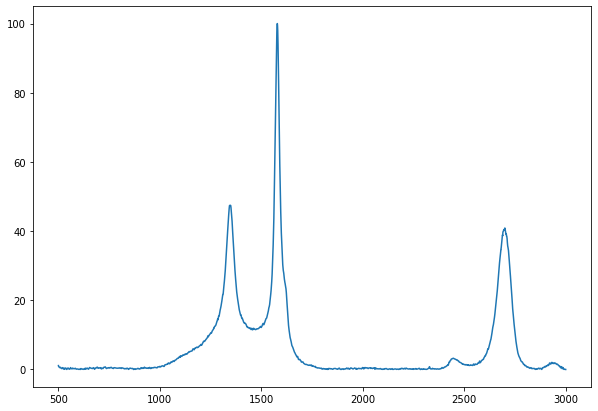

In [8]:
peak_intervals = Table().read_table("Peak_Interval_List.csv")
sample_spectrum = Table().read_table("JQ2a2_16.csv")
plots.plot(sample_spectrum.column("x"), sample_spectrum.column("y"))
sample_spectrum

In [9]:
peak_intervals

Peak Name,Peak Number,Optional?,Min Bound X,Max Bound X
Pre-D,1,Yes,1000,1320
D,2,No,1340,1360
D-G shoulder,3,Yes,1370,1550
G,4,No,1560,1600
D' shoulder,5,No,1600,1630
T+D,6,Yes,2300,2500
G'_3Da,7,No,2640,2685
G'_2D,8,No,2685,2720
G'_3DB,9,No,2700,2740
D'+D,10,No,2850,2950


Constraints: difference - 8 & 9
ratio: 7 & 9
Change 7 upper bound & 8 lower bound to be 2685
Link: https://stackoverflow.com/questions/20075714/scipy-minimize-with-constraints

## Driver Function
`spectrum`: table with two columns: x and y <br>  
`num_peaks`: int, how many peaks to fit with <br>  
`baseline`: string, type of function to fit baseline with  <br>  
`peak_type`: lorentz/gaussian, later add option to choose others (examples in the matlab, should be able to express with the same parameters) <br>  
`error`: MAE, MSE, etc. <br>  
`tolerance`: to within what error should we fit <br>  
`num_iterations`: how many iterations should we go through <br>  
`window_len`: length of savitsky-golay filter window <br>  
`polyorder`: order of polynomial to fit samples in savitsky-golay

In [29]:
def fit_spectrum(spectrum, num_peaks, baseline, peak_type, error_type, tolerance, num_iterations, window_len, polyorder):
    start_time = time.time()
    # Restrict data x to 500-3500
    restricted_spectrum = spectrum.where("x", are.between_or_equal_to(500, min(3500, max(spectrum.column("x")))))
    # Smooth signal with Savitsky-Golay filter
    smoothed_y = scipy.signal.savgol_filter(restricted_spectrum.column("y"), window_len, polyorder)
    smoothed_spectrum = Table().with_columns("x", restricted_spectrum.column("x"), "y", smoothed_y)
    # Remove baseline
    spectrum_baseline_removed = remove_baseline(smoothed_spectrum, baseline)
    # Normalize spectrum
    normalized_y = ((spectrum_baseline_removed.column("y") - min(spectrum_baseline_removed.column("y")))
                    / (max(spectrum_baseline_removed.column("y")) - min(spectrum_baseline_removed.column("y"))))
    normalized_spectrum = Table().with_columns("x", spectrum_baseline_removed.column("x"), "y", normalized_y)
    # Identify peaks
    detected_peaks = detect_peaks(normalized_spectrum, num_peaks)
    # Reconstruct spectra
    peaks = create_peaks(peak_type, detected_peaks)

    # Create loss function that we will optimize
    def error(guess_array):
        # first num_peaks elems are amp, next are cen, next are wid
        amp = guess_array[0:num_peaks]
        cen = guess_array[num_peaks:2*num_peaks]
        wid = guess_array[2*num_peaks:3*num_peaks]
        guess_peaks = Table().with_columns("Peak #", range(num_peaks),
                                          "amp", amp, "cen", cen, "wid", wid)
        reconstructed = reconstruct_spectrum(normalized_spectrum, guess_peaks)
        # choose error
        if error_type == "MAE":
            e = sklearn.metrics.mean_absolute_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "MSE":
            e = sklearn.metrics.mean_squared_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "MAPE":
            e = sklearn.metrics.mean_absolute_percentage_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "RMSPE":
            e = RMSPE(normalized_spectrum.column("y"), reconstructed)
        else:
            raise Exception("Error type not supported")
        #print(e)
        return e
    
    # change this from numpy appending to normal python list operations
    initial_guess = np.append(np.append(peaks.column("amp"), peaks.column("cen").astype(int)), peaks.column("wid"))

    # create bounds
    amp_bounds = [(0.0001, 300) for i in range(num_peaks)]
    min_x = peak_intervals.column("Min Bound X")
    max_x = peak_intervals.column("Max Bound X")
    cen_bounds = [(min_x[i], max_x[i]) for i in range(num_peaks)]
    wid_bounds = [(0.0001, 400) for i in range(num_peaks)]
    bounds = amp_bounds + cen_bounds + wid_bounds
    
    # ensure center of peak 9 > peak 8
    cons1 = {"type": "ineq", "fun": lambda arr: arr[num_peaks + 8] - arr[num_peaks + 7]}
    # upper bound for peak 7 : peak 9 (amplitude)
    cons2 = {"type": "ineq", "fun": lambda arr: arr[6] / arr[9] - 0.45}
    # lower bound for peak 7 : peak 9 (amplitude)
    cons3 = {"type": "ineq", "fun": lambda arr: -(arr[6] / arr[9]) + 0.55}
    
    result = scipy.optimize.minimize(error, initial_guess, bounds=bounds, tol=tolerance,
                                     options={"maxiter": num_iterations}, constraints=constraints).x
    final_error = error(result)
    
    # plot result
    result_matrix = Table().with_columns("Peak #", np.arange(num_peaks),
                                        "amp", result[0:num_peaks],
                                        "cen", result[num_peaks:2*num_peaks],
                                        "wid", result[2*num_peaks:3*num_peaks])
    print(result_matrix)
    reconstructed_y = reconstruct_spectrum(normalized_spectrum, result_matrix)
    
    guess_and_real = Table().with_columns("Real", normalized_y, "Reconstructed", reconstructed_y, "x", normalized_spectrum.column("x"))
    # guess_and_real.plot("x")
    
    
    # Temporary test code
    # Plotting individual peaks
    test_plot = guess_and_real
    for i in range(num_peaks):
        parameters_i = result_matrix.row(i)
        amp_i = parameters_i.item("amp")
        cen_i = parameters_i.item("cen")
        wid_i = parameters_i.item("wid")
        peak_i = [lorentz(x, amp_i, cen_i, wid_i) for x in normalized_spectrum.column("x")]
        test_plot = test_plot.with_columns(f"Peak {i}", peak_i)
    # test_plot.plot("x")
    plots.plot(test_plot.column("x"), test_plot.column("Real"), label="Real")
    plots.plot(test_plot.column("x"), test_plot.column("Reconstructed"), label="Reconstructed")
    for i in range(num_peaks):
        plots.plot(test_plot.column("x"), test_plot.column(f"Peak {i}"), label=f"Peak {i}")
    plots.legend()
    
    
    
    end_time = time.time()
    print(f"Runtime of the program is {end_time - start_time}")
    return (result, final_error)

In [10]:
# returns a table with the same columns and dimensions as spectrum
def remove_baseline(spectrum, func):
    x = spectrum.column("x")
    y = spectrum.column("y")
    if func == "linear":
        y_new = y - ((x - x[0]) / (x[-1] - x[0])) * (y[-1] - y[0])
        return Table().with_columns("x", x, "y", y_new)
    if func == "quadratic":
        return
    if func == "automatic":
        return

In [11]:
# returns an array with num_peaks x-values set to the midpoint of their bounds
# add option to remove peaks that are not required for lower num_peaks
def detect_peaks(spectra, num_peaks):
    midpoints = (peak_intervals.column("Min Bound X") + peak_intervals.column("Max Bound X")) / 2
    return midpoints

In [12]:
# returns a matrix of initial guesses
# dimensions 4 x num_peaks (4 = num parameters - x)
def create_peaks(peak_type, detected_peaks):
    if peak_type == "lorentz":
        parameter_matrix = Table(["Peak #", "amp", "cen", "wid"])
        for i in np.arange(len(detected_peaks)):
            amp = guess_amp()
            cen = detected_peaks[i]
            wid = guess_wid()
            parameter_matrix.append([i, amp, cen, wid])
        return parameter_matrix
    elif peak_type == "gaussian":
        return False

In [24]:
def guess_amp():
    return 100

In [25]:
def guess_wid():
    return 100

In [15]:
# x - values where the function is calculated
# y_0 - baseline
# amp - area
# cen - peak's center position
# wid - controls full width half maximum of the function
def lorentz(x, amp, cen, wid):
    return (amp/np.pi)*(wid / ((x - cen) ** 2 + wid ** 2))

In [16]:
# x - values where the function is calculated
# y_0 - baseline
# height - height of peak
# center - center of peak
# std - standard deviation
def gaussian(x, y_0, amp, cen, wid):
    std=wid/2.355
    return (amp / (std * np.sqrt(2*np.pi))) * (np.e ** -(((x - center) ** 2)) / 2 * std ** 2) + y_0

In [17]:
# returns an array of y values for each x value in spectrum. y values obtained using peak_parameters
def reconstruct_spectrum(spectrum, peak_parameters):
    def reconstruct_sum(x):
        peaks = peak_parameters.with_columns("x", [x for i in range(peak_parameters.num_rows)])
        sum_peaks = peaks.apply(lorentz, "x", "amp", "cen", "wid")
        return np.sum(sum_peaks)
    reconstructed = [reconstruct_sum(x) for x in spectrum.column("x")]
    return reconstructed

In [18]:
def RMSPE(y_true, y_pred):
    EPSILON = 1e-10
    return (np.sqrt(np.mean(np.square((y_true + EPSILON - y_pred) / y_true + EPSILON)))) * 100

## Demo

May take up to 3.5 minutes to run with 0.000001 tolerance

Peak # | amp  | cen  | wid
0      | 100  | 1160 | 100
1      | 100  | 1350 | 100
2      | 100  | 1460 | 100
3      | 100  | 1580 | 100
4      | 100  | 1615 | 100
5      | 100  | 2400 | 100
6      | 100  | 2665 | 100
7      | 100  | 2700 | 100
8      | 100  | 2720 | 100
9      | 100  | 2900 | 100
... (1 rows omitted)
Peak # | amp  | cen  | wid
0      | 100  | 1160 | 100
1      | 100  | 1350 | 100
2      | 100  | 1460 | 100
3      | 100  | 1580 | 100
4      | 100  | 1615 | 100
5      | 100  | 2400 | 100
6      | 100  | 2665 | 100
7      | 100  | 2700 | 100
8      | 100  | 2720 | 100
9      | 100  | 2900 | 100
... (1 rows omitted)
Peak # | amp  | cen  | wid
0      | 100  | 1160 | 100
1      | 100  | 1350 | 100
2      | 100  | 1460 | 100
3      | 100  | 1580 | 100
4      | 100  | 1615 | 100
5      | 100  | 2400 | 100
6      | 100  | 2665 | 100
7      | 100  | 2700 | 100
8      | 100  | 2720 | 100
9      | 100  | 2900 | 100
... (1 rows omitted)
Peak # | amp  | cen  | wid
0      | 100  | 116

Peak # | amp  | cen  | wid
0      | 100  | 1160 | 100
1      | 100  | 1350 | 100
2      | 100  | 1460 | 100
3      | 100  | 1580 | 100
4      | 100  | 1615 | 100
5      | 100  | 2400 | 100
6      | 100  | 2665 | 100
7      | 100  | 2700 | 100
8      | 100  | 2720 | 100
9      | 100  | 2900 | 100
... (1 rows omitted)
Peak # | amp  | cen  | wid
0      | 100  | 1160 | 100
1      | 100  | 1350 | 100
2      | 100  | 1460 | 100
3      | 100  | 1580 | 100
4      | 100  | 1615 | 100
5      | 100  | 2400 | 100
6      | 100  | 2665 | 100
7      | 100  | 2700 | 100
8      | 100  | 2720 | 100
9      | 100  | 2900 | 100
... (1 rows omitted)
Peak # | amp  | cen  | wid
0      | 100  | 1160 | 100
1      | 100  | 1350 | 100
2      | 100  | 1460 | 100
3      | 100  | 1580 | 100
4      | 100  | 1615 | 100
5      | 100  | 2400 | 100
6      | 100  | 2665 | 100
7      | 100  | 2700 | 100
8      | 100  | 2720 | 100
9      | 100  | 2900 | 100
... (1 rows omitted)
Peak # | amp  | cen  | wid
0      | 100  | 116

Peak # | amp     | cen  | wid
0      | 99.9997 | 1160 | 100
1      | 99.9997 | 1350 | 100
2      | 99.9997 | 1460 | 100
3      | 99.9997 | 1580 | 100
4      | 99.9997 | 1615 | 100
5      | 99.9997 | 2400 | 100
6      | 99.9997 | 2665 | 100
7      | 99.9997 | 2700 | 100
8      | 99.9997 | 2720 | 100
9      | 99.9997 | 2900 | 100
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9997 | 1160 | 100
1      | 99.9997 | 1350 | 100
2      | 99.9997 | 1460 | 100
3      | 99.9997 | 1580 | 100
4      | 99.9997 | 1615 | 100
5      | 99.9997 | 2400 | 100
6      | 99.9997 | 2665 | 100
7      | 99.9997 | 2700 | 100
8      | 99.9997 | 2720 | 100
9      | 99.9997 | 2900 | 100
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9997 | 1160 | 100
1      | 99.9997 | 1350 | 100
2      | 99.9997 | 1460 | 100
3      | 99.9997 | 1580 | 100
4      | 99.9997 | 1615 | 100
5      | 99.9997 | 2400 | 100
6      | 99.9997 | 2665 | 100
7      | 99.9997 | 2700 | 100
8      | 99.9997 | 2720 | 10

Peak # | amp     | cen  | wid
0      | 99.9994 | 1160 | 100
1      | 99.9994 | 1350 | 100
2      | 99.9994 | 1460 | 100
3      | 99.9994 | 1580 | 100
4      | 99.9994 | 1615 | 100
5      | 99.9993 | 2400 | 100
6      | 99.9994 | 2665 | 100
7      | 99.9994 | 2700 | 100
8      | 99.9994 | 2720 | 100
9      | 99.9994 | 2900 | 100
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9994 | 1160 | 100
1      | 99.9994 | 1350 | 100
2      | 99.9994 | 1460 | 100
3      | 99.9994 | 1580 | 100
4      | 99.9994 | 1615 | 100
5      | 99.9993 | 2400 | 100
6      | 99.9994 | 2665 | 100
7      | 99.9994 | 2700 | 100
8      | 99.9994 | 2720 | 100
9      | 99.9994 | 2900 | 100
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9994 | 1160 | 100
1      | 99.9994 | 1350 | 100
2      | 99.9994 | 1460 | 100
3      | 99.9994 | 1580 | 100
4      | 99.9994 | 1615 | 100
5      | 99.9993 | 2400 | 100
6      | 99.9994 | 2665 | 100
7      | 99.9994 | 2700 | 100
8      | 99.9994 | 2720 | 10

Peak # | amp     | cen  | wid
0      | 99.9994 | 1160 | 100
1      | 99.9994 | 1350 | 100
2      | 99.9994 | 1460 | 100
3      | 99.9994 | 1580 | 100
4      | 99.9994 | 1615 | 100
5      | 99.9993 | 2400 | 100
6      | 99.9994 | 2665 | 100
7      | 99.9994 | 2700 | 100
8      | 99.9994 | 2720 | 100
9      | 99.9994 | 2900 | 100
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9994 | 1160 | 100
1      | 99.9994 | 1350 | 100
2      | 99.9994 | 1460 | 100
3      | 99.9994 | 1580 | 100
4      | 99.9994 | 1615 | 100
5      | 99.9993 | 2400 | 100
6      | 99.9994 | 2665 | 100
7      | 99.9994 | 2700 | 100
8      | 99.9994 | 2720 | 100
9      | 99.9994 | 2900 | 100
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9994 | 1160 | 100
1      | 99.9994 | 1350 | 100
2      | 99.9994 | 1460 | 100
3      | 99.9994 | 1580 | 100
4      | 99.9994 | 1615 | 100
5      | 99.9993 | 2400 | 100
6      | 99.9994 | 2665 | 100
7      | 99.9994 | 2700 | 100
8      | 99.9994 | 2720 | 10

Peak # | amp     | cen  | wid
0      | 99.9982 | 1160 | 100
1      | 99.9981 | 1350 | 100
2      | 99.9982 | 1460 | 100
3      | 99.9983 | 1580 | 99.9999
4      | 99.9982 | 1615 | 100
5      | 99.998  | 2400 | 100
6      | 99.9981 | 2665 | 100
7      | 99.9981 | 2700 | 100
8      | 99.9981 | 2720 | 100
9      | 99.9981 | 2900 | 100
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9982 | 1160 | 100
1      | 99.9981 | 1350 | 100
2      | 99.9982 | 1460 | 100
3      | 99.9983 | 1580 | 99.9999
4      | 99.9982 | 1615 | 100
5      | 99.998  | 2400 | 100
6      | 99.9981 | 2665 | 100
7      | 99.9981 | 2700 | 100
8      | 99.9981 | 2720 | 100
9      | 99.9981 | 2900 | 100
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9982 | 1160 | 100
1      | 99.9981 | 1350 | 100
2      | 99.9982 | 1460 | 100
3      | 99.9983 | 1580 | 99.9999
4      | 99.9982 | 1615 | 100
5      | 99.998  | 2400 | 100
6      | 99.9981 | 2665 | 100
7      | 99.9981 | 2700 | 100
8      | 99.9981

Peak # | amp     | cen  | wid
0      | 99.9934 | 1160 | 100.001
1      | 99.9932 | 1350 | 100.001
2      | 99.9933 | 1460 | 100.001
3      | 99.9937 | 1580 | 99.9998
4      | 99.9936 | 1615 | 100
5      | 99.9928 | 2400 | 100
6      | 99.9929 | 2665 | 100
7      | 99.9929 | 2700 | 100
8      | 99.9929 | 2720 | 100
9      | 99.993  | 2900 | 100.001
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9934 | 1160 | 100.001
1      | 99.9932 | 1350 | 100.001
2      | 99.9933 | 1460 | 100.001
3      | 99.9937 | 1580 | 99.9998
4      | 99.9936 | 1615 | 100
5      | 99.9928 | 2400 | 100
6      | 99.9929 | 2665 | 100
7      | 99.9929 | 2700 | 100
8      | 99.9929 | 2720 | 100
9      | 99.993  | 2900 | 100.001
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9934 | 1160 | 100.001
1      | 99.9932 | 1350 | 100.001
2      | 99.9933 | 1460 | 100.001
3      | 99.9937 | 1580 | 99.9998
4      | 99.9936 | 1615 | 100
5      | 99.9928 | 2400 | 100
6      | 99.9929 | 2665 | 100
7 

Peak # | amp     | cen  | wid
0      | 99.9744 | 1160 | 100.004
1      | 99.9735 | 1350 | 100.003
2      | 99.9738 | 1460 | 100.002
3      | 99.9753 | 1580 | 99.9991
4      | 99.9749 | 1615 | 99.9998
5      | 99.972  | 2400 | 100.002
6      | 99.9722 | 2665 | 100.002
7      | 99.9723 | 2700 | 100.002
8      | 99.9723 | 2720 | 100.002
9      | 99.9727 | 2900 | 100.002
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9744 | 1160 | 100.004
1      | 99.9735 | 1350 | 100.003
2      | 99.9738 | 1460 | 100.002
3      | 99.9753 | 1580 | 99.9991
4      | 99.9749 | 1615 | 99.9998
5      | 99.972  | 2400 | 100.002
6      | 99.9722 | 2665 | 100.002
7      | 99.9723 | 2700 | 100.002
8      | 99.9723 | 2720 | 100.002
9      | 99.9727 | 2900 | 100.002
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9744 | 1160 | 100.004
1      | 99.9735 | 1350 | 100.003
2      | 99.9738 | 1460 | 100.002
3      | 99.9753 | 1580 | 99.9991
4      | 99.9749 | 1615 | 99.9998
5      | 99.972  |

Peak # | amp     | cen  | wid
0      | 99.9744 | 1160 | 100.004
1      | 99.9735 | 1350 | 100.003
2      | 99.9738 | 1460 | 100.002
3      | 99.9753 | 1580 | 99.9991
4      | 99.9749 | 1615 | 99.9998
5      | 99.972  | 2400 | 100.002
6      | 99.9722 | 2665 | 100.002
7      | 99.9723 | 2700 | 100.002
8      | 99.9723 | 2720 | 100.002
9      | 99.9727 | 2900 | 100.002
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9744 | 1160 | 100.004
1      | 99.9735 | 1350 | 100.003
2      | 99.9738 | 1460 | 100.002
3      | 99.9753 | 1580 | 99.9991
4      | 99.9749 | 1615 | 99.9998
5      | 99.972  | 2400 | 100.002
6      | 99.9722 | 2665 | 100.002
7      | 99.9723 | 2700 | 100.002
8      | 99.9723 | 2720 | 100.002
9      | 99.9727 | 2900 | 100.002
... (1 rows omitted)
Peak # | amp     | cen  | wid
0      | 99.9744 | 1160 | 100.004
1      | 99.9735 | 1350 | 100.003
2      | 99.9738 | 1460 | 100.002
3      | 99.9753 | 1580 | 99.9991
4      | 99.9749 | 1615 | 99.9998
5      | 99.972  |

Peak # | amp     | cen     | wid
0      | 99.8981 | 1160    | 100.015
1      | 99.8945 | 1350    | 100.011
2      | 99.8958 | 1460    | 100.01
3      | 99.9016 | 1580    | 99.9964
4      | 99.9002 | 1614.99 | 99.9993
5      | 99.8887 | 2400    | 100.007
6      | 99.8895 | 2665    | 100.007
7      | 99.8898 | 2700    | 100.008
8      | 99.8899 | 2720    | 100.008
9      | 99.8916 | 2900    | 100.009
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 99.8981 | 1160    | 100.015
1      | 99.8945 | 1350    | 100.011
2      | 99.8958 | 1460    | 100.01
3      | 99.9016 | 1580    | 99.9964
4      | 99.9002 | 1614.99 | 99.9993
5      | 99.8887 | 2400    | 100.007
6      | 99.8895 | 2665    | 100.007
7      | 99.8898 | 2700    | 100.008
8      | 99.8899 | 2720    | 100.008
9      | 99.8916 | 2900    | 100.009
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 99.8981 | 1160    | 100.015
1      | 99.8945 | 1350    | 100.011
2      | 99.8958 | 1460    | 100.01
3      | 99

Peak # | amp     | cen     | wid
0      | 99.8981 | 1160    | 100.015
1      | 99.8945 | 1350    | 100.011
2      | 99.8958 | 1460    | 100.01
3      | 99.9016 | 1580    | 99.9964
4      | 99.9002 | 1614.99 | 99.9993
5      | 99.8887 | 2400    | 100.007
6      | 99.8895 | 2665    | 100.007
7      | 99.8898 | 2700    | 100.008
8      | 99.8899 | 2720    | 100.008
9      | 99.8916 | 2900    | 100.009
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 99.8981 | 1160    | 100.015
1      | 99.8945 | 1350    | 100.011
2      | 99.8958 | 1460    | 100.01
3      | 99.9016 | 1580    | 99.9964
4      | 99.9002 | 1614.99 | 99.9993
5      | 99.8887 | 2400    | 100.007
6      | 99.8895 | 2665    | 100.007
7      | 99.8898 | 2700    | 100.008
8      | 99.8899 | 2720    | 100.008
9      | 99.8916 | 2900    | 100.009
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 99.8981 | 1160    | 100.015
1      | 99.8945 | 1350    | 100.011
2      | 99.8958 | 1460    | 100.01
3      | 99

Peak # | amp     | cen     | wid
0      | 99.5932 | 1159.99 | 100.061
1      | 99.5785 | 1350    | 100.046
2      | 99.5839 | 1460.01 | 100.039
3      | 99.6071 | 1580    | 99.9855
4      | 99.6015 | 1614.97 | 99.9973
5      | 99.5554 | 2400    | 100.026
6      | 99.5588 | 2665    | 100.03
7      | 99.5597 | 2700    | 100.03
8      | 99.5602 | 2720    | 100.031
9      | 99.567  | 2900.01 | 100.037
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 99.5932 | 1159.99 | 100.061
1      | 99.5785 | 1350    | 100.046
2      | 99.5839 | 1460.01 | 100.039
3      | 99.6071 | 1580    | 99.9855
4      | 99.6015 | 1614.97 | 99.9973
5      | 99.5554 | 2400    | 100.026
6      | 99.5588 | 2665    | 100.03
7      | 99.5597 | 2700    | 100.03
8      | 99.5602 | 2720    | 100.031
9      | 99.567  | 2900.01 | 100.037
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 99.5932 | 1159.99 | 100.061
1      | 99.5785 | 1350    | 100.046
2      | 99.5839 | 1460.01 | 100.039
3      | 99.

Peak # | amp     | cen     | wid
0      | 98.3733 | 1159.94 | 100.243
1      | 98.3144 | 1349.99 | 100.183
2      | 98.3362 | 1460.06 | 100.156
3      | 98.4288 | 1579.99 | 99.9419
4      | 98.4065 | 1614.89 | 99.9891
5      | 98.2222 | 2400    | 100.105
6      | 98.2359 | 2665.01 | 100.118
7      | 98.2393 | 2700.01 | 100.121
8      | 98.2415 | 2720.01 | 100.122
9      | 98.2685 | 2900.02 | 100.148
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 98.3733 | 1159.94 | 100.243
1      | 98.3144 | 1349.99 | 100.183
2      | 98.3362 | 1460.06 | 100.156
3      | 98.4288 | 1579.99 | 99.9419
4      | 98.4065 | 1614.89 | 99.9891
5      | 98.2222 | 2400    | 100.105
6      | 98.2359 | 2665.01 | 100.118
7      | 98.2393 | 2700.01 | 100.121
8      | 98.2415 | 2720.01 | 100.122
9      | 98.2685 | 2900.02 | 100.148
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 98.3733 | 1159.94 | 100.243
1      | 98.3144 | 1349.99 | 100.183
2      | 98.3362 | 1460.06 | 100.156
3      |

Peak # | amp     | cen     | wid
0      | 98.3733 | 1159.94 | 100.243
1      | 98.3144 | 1349.99 | 100.183
2      | 98.3362 | 1460.06 | 100.156
3      | 98.4288 | 1579.99 | 99.9419
4      | 98.4065 | 1614.89 | 99.9891
5      | 98.2222 | 2400    | 100.105
6      | 98.2359 | 2665.01 | 100.118
7      | 98.2393 | 2700.01 | 100.121
8      | 98.2415 | 2720.01 | 100.122
9      | 98.2685 | 2900.02 | 100.148
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 98.3733 | 1159.94 | 100.243
1      | 98.3144 | 1349.99 | 100.183
2      | 98.3362 | 1460.06 | 100.156
3      | 98.4288 | 1579.99 | 99.9419
4      | 98.4065 | 1614.89 | 99.9891
5      | 98.2222 | 2400    | 100.105
6      | 98.2359 | 2665.01 | 100.118
7      | 98.2393 | 2700.01 | 100.121
8      | 98.2415 | 2720.01 | 100.122
9      | 98.2685 | 2900.02 | 100.148
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 98.3733 | 1159.94 | 100.243
1      | 98.3144 | 1349.99 | 100.183
2      | 98.3362 | 1460.06 | 100.156
3      |

Peak # | amp     | cen     | wid
0      | 93.4939 | 1159.76 | 100.971
1      | 93.2584 | 1349.98 | 100.73
2      | 93.3456 | 1460.23 | 100.623
3      | 93.7159 | 1579.97 | 99.7678
4      | 93.6264 | 1614.56 | 99.9562
5      | 92.8895 | 2400.01 | 100.42
6      | 92.9444 | 2665.03 | 100.473
7      | 92.9577 | 2700.04 | 100.483
8      | 92.9666 | 2720.05 | 100.488
9      | 93.0748 | 2900.08 | 100.591
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 93.4939 | 1159.76 | 100.971
1      | 93.2584 | 1349.98 | 100.73
2      | 93.3456 | 1460.23 | 100.623
3      | 93.7159 | 1579.97 | 99.7678
4      | 93.6264 | 1614.56 | 99.9562
5      | 92.8895 | 2400.01 | 100.42
6      | 92.9444 | 2665.03 | 100.473
7      | 92.9577 | 2700.04 | 100.483
8      | 92.9666 | 2720.05 | 100.488
9      | 93.0748 | 2900.08 | 100.591
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 93.4939 | 1159.76 | 100.971
1      | 93.2584 | 1349.98 | 100.73
2      | 93.3456 | 1460.23 | 100.623
3      | 93.7

Peak # | amp     | cen     | wid
0      | 93.4939 | 1159.76 | 100.971
1      | 93.2584 | 1349.98 | 100.73
2      | 93.3456 | 1460.23 | 100.623
3      | 93.7159 | 1579.97 | 99.7678
4      | 93.6264 | 1614.56 | 99.9562
5      | 92.8895 | 2400.01 | 100.42
6      | 92.9444 | 2665.03 | 100.473
7      | 92.9577 | 2700.04 | 100.483
8      | 92.9666 | 2720.05 | 100.488
9      | 93.0748 | 2900.08 | 100.591
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 73.9761 | 1159.04 | 103.884
1      | 73.0341 | 1349.91 | 102.92
2      | 73.3829 | 1460.91 | 102.494
3      | 74.8643 | 1579.89 | 99.0711
4      | 74.5063 | 1613.25 | 99.8249
5      | 71.5585 | 2400.04 | 101.681
6      | 71.7783 | 2665.13 | 101.892
7      | 71.8316 | 2700.17 | 101.933
8      | 71.867  | 2720.18 | 101.954
9      | 72.2997 | 2900.32 | 102.365
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 73.9761 | 1159.04 | 103.884
1      | 73.0341 | 1349.91 | 102.92
2      | 73.3829 | 1460.91 | 102.494
3      | 74.

Peak # | amp     | cen     | wid
0      | 73.9761 | 1159.04 | 103.884
1      | 73.0341 | 1349.91 | 102.92
2      | 73.3829 | 1460.91 | 102.494
3      | 74.8643 | 1579.89 | 99.0711
4      | 74.5063 | 1613.25 | 99.8249
5      | 71.5585 | 2400.04 | 101.681
6      | 71.7783 | 2665.13 | 101.892
7      | 71.8316 | 2700.17 | 101.933
8      | 71.867  | 2720.18 | 101.954
9      | 72.2997 | 2900.32 | 102.365
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 73.9761 | 1159.04 | 103.884
1      | 73.0341 | 1349.91 | 102.92
2      | 73.3829 | 1460.91 | 102.494
3      | 74.8643 | 1579.89 | 99.0711
4      | 74.5063 | 1613.25 | 99.8249
5      | 71.5585 | 2400.04 | 101.681
6      | 71.7783 | 2665.13 | 101.892
7      | 71.8316 | 2700.17 | 101.933
8      | 71.867  | 2720.18 | 101.954
9      | 72.2997 | 2900.32 | 102.365
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 73.9761 | 1159.04 | 103.884
1      | 73.0341 | 1349.91 | 102.92
2      | 73.3829 | 1460.91 | 102.494
3      | 74

Peak # | amp      | cen     | wid
0      | 8.50028  | 1156.64 | 113.656
1      | 5.18821  | 1349.69 | 110.267
2      | 6.41446  | 1463.21 | 108.768
3      | 11.623   | 1579.61 | 96.734
4      | 10.3644  | 1608.83 | 99.3843
5      | 0.0001   | 2400.14 | 105.911
6      | 0.772689 | 2665.47 | 106.651
7      | 0.960293 | 2700.59 | 106.796
8      | 1.08479  | 2720.65 | 106.87
9      | 2.60609  | 2901.13 | 108.314
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 8.50028  | 1156.64 | 113.656
1      | 5.18821  | 1349.69 | 110.267
2      | 6.41446  | 1463.21 | 108.768
3      | 11.623   | 1579.61 | 96.734
4      | 10.3644  | 1608.83 | 99.3843
5      | 0.0001   | 2400.14 | 105.911
6      | 0.772689 | 2665.47 | 106.651
7      | 0.960293 | 2700.59 | 106.796
8      | 1.08479  | 2720.65 | 106.87
9      | 2.60609  | 2901.13 | 108.314
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 8.50028  | 1156.64 | 113.656
1      | 5.18821  | 1349.69 | 110.267
2      | 6.41446  | 1463

Peak # | amp      | cen     | wid
0      | 8.50028  | 1156.64 | 113.656
1      | 5.18821  | 1349.69 | 110.267
2      | 6.41446  | 1463.21 | 108.768
3      | 11.623   | 1579.61 | 96.734
4      | 10.3644  | 1608.83 | 99.3843
5      | 0.0001   | 2400.14 | 105.911
6      | 0.772689 | 2665.47 | 106.651
7      | 0.960293 | 2700.59 | 106.796
8      | 1.08479  | 2720.65 | 106.87
9      | 2.60609  | 2901.13 | 108.314
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 8.50028  | 1156.64 | 113.656
1      | 5.18821  | 1349.69 | 110.267
2      | 6.41446  | 1463.21 | 108.768
3      | 11.623   | 1579.61 | 96.734
4      | 10.3644  | 1608.83 | 99.3843
5      | 0.0001   | 2400.14 | 105.911
6      | 0.772689 | 2665.47 | 106.651
7      | 0.960293 | 2700.59 | 106.796
8      | 1.08479  | 2720.65 | 106.87
9      | 2.60609  | 2901.13 | 108.314
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 8.50028  | 1156.64 | 113.656
1      | 5.18821  | 1349.69 | 110.267
2      | 6.41446  | 1463

Peak # | amp     | cen     | wid
0      | 42.1245 | 1157.87 | 108.638
1      | 40.0296 | 1349.8  | 106.494
2      | 40.8052 | 1462.03 | 105.546
3      | 44.0997 | 1579.76 | 97.9342
4      | 43.3036 | 1611.1  | 99.6106
5      | 36.748  | 2400.09 | 103.739
6      | 37.2367 | 2665.3  | 104.207
7      | 37.3553 | 2700.38 | 104.299
8      | 37.4341 | 2720.41 | 104.345
9      | 38.3963 | 2900.72 | 105.259
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 42.1245 | 1157.87 | 108.638
1      | 40.0296 | 1349.8  | 106.494
2      | 40.8052 | 1462.03 | 105.546
3      | 44.0997 | 1579.76 | 97.9342
4      | 43.3036 | 1611.1  | 99.6106
5      | 36.748  | 2400.09 | 103.739
6      | 37.2367 | 2665.3  | 104.207
7      | 37.3553 | 2700.38 | 104.299
8      | 37.4341 | 2720.41 | 104.345
9      | 38.3963 | 2900.72 | 105.259
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 42.1245 | 1157.87 | 108.638
1      | 40.0296 | 1349.8  | 106.494
2      | 40.8052 | 1462.03 | 105.546
3      |

Peak # | amp        | cen     | wid
0      | 0.0001     | 1160.4  | 130.735
1      | 0.00010001 | 1347.66 | 78.8446
2      | 0.0001     | 1452.24 | 116.707
3      | 0.0001     | 1579.76 | 80.948
4      | 0.0001     | 1600    | 86.4755
5      | 0.0001     | 2396.63 | 111.863
6      | 0.0001     | 2664.84 | 109.585
7      | 0.0001     | 2700.08 | 109.585
8      | 0.0001     | 2720.2  | 109.594
9      | 0.0001     | 2901.28 | 110.928
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 0.0001     | 1160.4  | 130.735
1      | 0.0001     | 1347.66 | 78.8446
2      | 0.00010001 | 1452.24 | 116.707
3      | 0.0001     | 1579.76 | 80.948
4      | 0.0001     | 1600    | 86.4755
5      | 0.0001     | 2396.63 | 111.863
6      | 0.0001     | 2664.84 | 109.585
7      | 0.0001     | 2700.08 | 109.585
8      | 0.0001     | 2720.2  | 109.594
9      | 0.0001     | 2901.28 | 110.928
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 0.0001     | 1160.4  | 130.735
1      | 0.0

Peak # | amp    | cen     | wid
0      | 0.0001 | 1160.4  | 130.735
1      | 0.0001 | 1347.66 | 78.8446
2      | 0.0001 | 1452.24 | 116.707
3      | 0.0001 | 1579.76 | 80.948
4      | 0.0001 | 1600    | 86.4755
5      | 0.0001 | 2396.63 | 111.863
6      | 0.0001 | 2664.84 | 109.585
7      | 0.0001 | 2700.08 | 109.585
8      | 0.0001 | 2720.2  | 109.594
9      | 0.0001 | 2901.28 | 110.928
... (1 rows omitted)
Peak # | amp    | cen     | wid
0      | 0.0001 | 1160.4  | 130.735
1      | 0.0001 | 1347.66 | 78.8446
2      | 0.0001 | 1452.24 | 116.707
3      | 0.0001 | 1579.76 | 80.948
4      | 0.0001 | 1600    | 86.4755
5      | 0.0001 | 2396.63 | 111.863
6      | 0.0001 | 2664.84 | 109.585
7      | 0.0001 | 2700.08 | 109.585
8      | 0.0001 | 2720.2  | 109.594
9      | 0.0001 | 2901.28 | 110.928
... (1 rows omitted)
Peak # | amp    | cen     | wid
0      | 0.0001 | 1160.4  | 130.735
1      | 0.0001 | 1347.66 | 78.8446
2      | 0.0001 | 1452.24 | 116.707
3      | 0.0001 | 1579.76 | 80.948
4

Peak # | amp     | cen     | wid
0      | 23.672  | 1158.98 | 118.317
1      | 22.4948 | 1348.87 | 94.3823
2      | 22.9306 | 1457.74 | 110.435
3      | 24.782  | 1579.76 | 90.4934
4      | 24.3346 | 1606.24 | 93.8568
5      | 20.6507 | 2398.57 | 107.298
6      | 20.9253 | 2665.1  | 106.563
7      | 20.992  | 2700.25 | 106.615
8      | 21.0362 | 2720.32 | 106.644
9      | 21.577  | 2900.96 | 107.742
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 23.672  | 1158.98 | 118.317
1      | 22.4948 | 1348.87 | 94.3823
2      | 22.9306 | 1457.74 | 110.435
3      | 24.782  | 1579.76 | 90.4934
4      | 24.3346 | 1606.24 | 93.8568
5      | 20.6507 | 2398.57 | 107.298
6      | 20.9253 | 2665.1  | 106.563
7      | 20.992  | 2700.25 | 106.615
8      | 21.0362 | 2720.32 | 106.644
9      | 21.577  | 2900.96 | 107.742
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 23.672  | 1158.98 | 118.317
1      | 22.4948 | 1348.87 | 94.3823
2      | 22.9306 | 1457.74 | 110.435
3      |

Peak # | amp     | cen     | wid
0      | 23.672  | 1158.98 | 118.317
1      | 22.4948 | 1348.87 | 94.3823
2      | 22.9306 | 1457.74 | 110.435
3      | 24.782  | 1579.76 | 90.4934
4      | 24.3346 | 1606.24 | 93.8568
5      | 20.6507 | 2398.57 | 107.298
6      | 20.9253 | 2665.1  | 106.563
7      | 20.992  | 2700.25 | 106.615
8      | 21.0362 | 2720.32 | 106.644
9      | 21.577  | 2900.96 | 107.742
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 23.672  | 1158.98 | 118.317
1      | 22.4948 | 1348.87 | 94.3823
2      | 22.9306 | 1457.74 | 110.435
3      | 24.782  | 1579.76 | 90.4934
4      | 24.3346 | 1606.24 | 93.8568
5      | 20.6507 | 2398.57 | 107.298
6      | 20.9253 | 2665.1  | 106.563
7      | 20.992  | 2700.25 | 106.615
8      | 21.0362 | 2720.32 | 106.644
9      | 21.577  | 2900.96 | 107.742
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 23.672  | 1158.98 | 118.317
1      | 22.4948 | 1348.87 | 94.3823
2      | 22.9306 | 1457.74 | 110.435
3      |

Peak # | amp     | cen     | wid
0      | 1.45441 | 1159.72 | 128.038
1      | 22.1274 | 1347.73 | 83.1125
2      | 9.32413 | 1453.87 | 115.585
3      | 15.7331 | 1580.89 | 84.075
4      | 15.1272 | 1602.47 | 89.1652
5      | 0.0001  | 2395.63 | 113.209
6      | 2.83808 | 2668.15 | 105.059
7      | 5.93003 | 2700.38 | 103.294
8      | 5.13635 | 2718.41 | 103.55
9      | 0.0001  | 2899.68 | 111.713
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 1.45441 | 1159.72 | 128.038
1      | 22.1274 | 1347.73 | 83.1125
2      | 9.32413 | 1453.87 | 115.585
3      | 15.7331 | 1580.89 | 84.075
4      | 15.1272 | 1602.47 | 89.1652
5      | 0.0001  | 2395.63 | 113.209
6      | 2.83808 | 2668.15 | 105.059
7      | 5.93003 | 2700.38 | 103.294
8      | 5.13635 | 2718.41 | 103.55
9      | 0.0001  | 2899.68 | 111.713
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 1.45441 | 1159.72 | 128.038
1      | 22.1274 | 1347.73 | 83.1125
2      | 9.32413 | 1453.87 | 115.585
3      | 15.

Peak # | amp     | cen     | wid
0      | 14.3809 | 1159.29 | 122.382
1      | 22.3412 | 1348.39 | 89.6694
2      | 17.2406 | 1456.12 | 112.589
3      | 20.9979 | 1580.23 | 87.8093
4      | 20.4842 | 1604.66 | 91.8948
5      | 12.0149 | 2397.34 | 109.77
6      | 13.3614 | 2666.37 | 105.934
7      | 14.6933 | 2700.3  | 105.226
8      | 14.3871 | 2719.52 | 105.35
9      | 12.5538 | 2900.43 | 109.403
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 14.3809 | 1159.29 | 122.382
1      | 22.3412 | 1348.39 | 89.6694
2      | 17.2406 | 1456.12 | 112.589
3      | 20.9979 | 1580.23 | 87.8093
4      | 20.4842 | 1604.66 | 91.8948
5      | 12.0149 | 2397.34 | 109.77
6      | 13.3614 | 2666.37 | 105.934
7      | 14.6933 | 2700.3  | 105.226
8      | 14.3871 | 2719.52 | 105.35
9      | 12.5538 | 2900.43 | 109.403
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 14.3809 | 1159.29 | 122.382
1      | 22.3412 | 1348.39 | 89.6694
2      | 17.2406 | 1456.12 | 112.589
3      | 20.

Peak # | amp     | cen     | wid
0      | 14.3809 | 1159.29 | 122.382
1      | 22.3412 | 1348.39 | 89.6694
2      | 17.2406 | 1456.12 | 112.589
3      | 20.9979 | 1580.23 | 87.8093
4      | 20.4842 | 1604.66 | 91.8948
5      | 12.0149 | 2397.34 | 109.77
6      | 13.3614 | 2666.37 | 105.934
7      | 14.6933 | 2700.3  | 105.226
8      | 14.3871 | 2719.52 | 105.35
9      | 12.5538 | 2900.43 | 109.403
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 14.3809 | 1159.29 | 122.382
1      | 22.3412 | 1348.39 | 89.6694
2      | 17.2406 | 1456.12 | 112.589
3      | 20.9979 | 1580.23 | 87.8093
4      | 20.4842 | 1604.66 | 91.8948
5      | 12.0149 | 2397.34 | 109.77
6      | 13.3614 | 2666.37 | 105.934
7      | 14.6933 | 2700.3  | 105.226
8      | 14.3871 | 2719.52 | 105.35
9      | 12.5538 | 2900.43 | 109.403
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 14.3809 | 1159.29 | 122.382
1      | 22.3412 | 1348.39 | 89.6694
2      | 17.2406 | 1456.12 | 112.589
3      | 20.

Peak # | amp     | cen     | wid
0      | 12.8763 | 1158.84 | 124.672
1      | 28.3438 | 1347.39 | 86.3972
2      | 14.6499 | 1455.12 | 114.304
3      | 21.5243 | 1580.63 | 85.9793
4      | 20.5556 | 1603.51 | 90.6959
5      | 8.54313 | 2396.47 | 111.226
6      | 11.8903 | 2667.06 | 104.79
7      | 13.4773 | 2699.81 | 103.65
8      | 12.0813 | 2718.34 | 104.031
9      | 0.73791 | 2900.18 | 110.644
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 12.8763 | 1158.84 | 124.672
1      | 28.3438 | 1347.39 | 86.3972
2      | 14.6499 | 1455.12 | 114.304
3      | 21.5243 | 1580.63 | 85.9793
4      | 20.5556 | 1603.51 | 90.6959
5      | 8.54313 | 2396.47 | 111.226
6      | 11.8903 | 2667.06 | 104.79
7      | 13.4773 | 2699.81 | 103.65
8      | 12.0813 | 2718.34 | 104.031
9      | 0.73791 | 2900.18 | 110.644
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 12.8763 | 1158.84 | 124.672
1      | 28.3438 | 1347.39 | 86.3972
2      | 14.6499 | 1455.12 | 114.304
3      | 21.

Peak # | amp     | cen     | wid
0      | 13.2385 | 1159.03 | 126.354
1      | 30.35   | 1346.95 | 82.7374
2      | 14.5214 | 1453.97 | 115.222
3      | 21.8027 | 1580.74 | 84.258
4      | 20.8232 | 1602.56 | 89.3479
5      | 11.3397 | 2396.07 | 111.708
6      | 14.5062 | 2667.04 | 104.868
7      | 16.093  | 2699.67 | 103.697
8      | 14.517  | 2718.16 | 104.136
9      | 2.00357 | 2900.22 | 110.805
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 13.2385 | 1159.03 | 126.354
1      | 30.35   | 1346.95 | 82.7374
2      | 14.5214 | 1453.97 | 115.222
3      | 21.8027 | 1580.74 | 84.258
4      | 20.8232 | 1602.56 | 89.3479
5      | 11.3397 | 2396.07 | 111.708
6      | 14.5062 | 2667.04 | 104.868
7      | 16.093  | 2699.67 | 103.697
8      | 14.517  | 2718.16 | 104.136
9      | 2.00357 | 2900.22 | 110.805
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 13.2385 | 1159.03 | 126.354
1      | 30.35   | 1346.95 | 82.7374
2      | 14.5214 | 1453.97 | 115.222
3      | 2

Peak # | amp     | cen     | wid
0      | 13.2385 | 1159.03 | 126.354
1      | 30.35   | 1346.95 | 82.7374
2      | 14.5214 | 1453.97 | 115.222
3      | 21.8027 | 1580.74 | 84.258
4      | 20.8232 | 1602.56 | 89.3479
5      | 11.3397 | 2396.07 | 111.708
6      | 14.5062 | 2667.04 | 104.868
7      | 16.093  | 2699.67 | 103.697
8      | 14.517  | 2718.16 | 104.136
9      | 2.00357 | 2900.22 | 110.805
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 13.2385 | 1159.03 | 126.354
1      | 30.35   | 1346.95 | 82.7374
2      | 14.5214 | 1453.97 | 115.222
3      | 21.8027 | 1580.74 | 84.258
4      | 20.8232 | 1602.56 | 89.3479
5      | 11.3397 | 2396.07 | 111.708
6      | 14.5062 | 2667.04 | 104.868
7      | 16.093  | 2699.67 | 103.697
8      | 14.517  | 2718.16 | 104.136
9      | 2.00357 | 2900.22 | 110.805
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 13.2385 | 1159.03 | 126.354
1      | 30.35   | 1346.95 | 82.7374
2      | 14.5214 | 1453.97 | 115.222
3      | 2

Peak # | amp     | cen     | wid
0      | 12.3976 | 1159.19 | 131.267
1      | 36.9745 | 1345.69 | 72.4787
2      | 12.5331 | 1450.97 | 118.032
3      | 22.4815 | 1581.21 | 79.362
4      | 21.2519 | 1600    | 85.6287
5      | 12.1051 | 2394.62 | 113.836
6      | 18.2755 | 2667.61 | 104.415
7      | 20.3962 | 2699.27 | 102.913
8      | 18.0721 | 2717.26 | 103.659
9      | 2.11102 | 2900.23 | 111.59
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 12.3976 | 1159.19 | 131.267
1      | 36.9745 | 1345.69 | 72.4787
2      | 12.5331 | 1450.97 | 118.032
3      | 22.4815 | 1581.21 | 79.362
4      | 21.2519 | 1600    | 85.6287
5      | 12.1051 | 2394.62 | 113.836
6      | 18.2755 | 2667.61 | 104.415
7      | 20.3962 | 2699.27 | 102.913
8      | 18.0721 | 2717.26 | 103.659
9      | 2.11102 | 2900.23 | 111.59
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 12.3976 | 1159.19 | 131.267
1      | 36.9745 | 1345.69 | 72.4787
2      | 12.5331 | 1450.97 | 118.032
3      | 22.

Peak # | amp     | cen     | wid
0      | 12.3976 | 1159.19 | 131.267
1      | 36.9745 | 1345.69 | 72.4787
2      | 12.5331 | 1450.97 | 118.032
3      | 22.4815 | 1581.21 | 79.362
4      | 21.2519 | 1600    | 85.6287
5      | 12.1051 | 2394.62 | 113.836
6      | 18.2755 | 2667.61 | 104.415
7      | 20.3962 | 2699.27 | 102.913
8      | 18.0721 | 2717.26 | 103.659
9      | 2.11102 | 2900.23 | 111.59
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 12.3976 | 1159.19 | 131.267
1      | 36.9745 | 1345.69 | 72.4787
2      | 12.5331 | 1450.97 | 118.032
3      | 22.4815 | 1581.21 | 79.362
4      | 21.2519 | 1600    | 85.6287
5      | 12.1051 | 2394.62 | 113.836
6      | 18.2755 | 2667.61 | 104.415
7      | 20.3962 | 2699.27 | 102.913
8      | 18.0721 | 2717.26 | 103.659
9      | 2.11102 | 2900.23 | 111.59
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 12.3976 | 1159.19 | 131.267
1      | 36.9745 | 1345.69 | 72.4787
2      | 12.5331 | 1450.97 | 118.032
3      | 22.

Peak # | amp     | cen     | wid
0      | 9.83997 | 1159.25 | 141.024
1      | 51.1385 | 1343.21 | 51.7425
2      | 7.29103 | 1445.22 | 123.742
3      | 23.7696 | 1582.34 | 69.6336
4      | 21.9273 | 1600    | 78.3485
5      | 11.798  | 2391.6  | 118.283
6      | 23.5248 | 2669.13 | 103.074
7      | 26.9894 | 2698.47 | 100.663
8      | 22.9883 | 2715.19 | 102.096
9      | 0.0001  | 2900.14 | 113.438
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 9.83997 | 1159.25 | 141.024
1      | 51.1385 | 1343.21 | 51.7425
2      | 7.29103 | 1445.22 | 123.742
3      | 23.7696 | 1582.34 | 69.6336
4      | 21.9273 | 1600    | 78.3485
5      | 11.798  | 2391.6  | 118.283
6      | 23.5248 | 2669.13 | 103.074
7      | 26.9894 | 2698.47 | 100.663
8      | 22.9883 | 2715.19 | 102.096
9      | 0.0001  | 2900.14 | 113.438
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 9.83997 | 1159.25 | 141.024
1      | 51.1385 | 1343.21 | 51.7425
2      | 7.29103 | 1445.22 | 123.742
3      |

Peak # | amp     | cen     | wid
0      | 0.0001  | 1160.36 | 176.486
1      | 90.0012 | 1340    | 0.0001
2      | 0.0001  | 1424.31 | 143.862
3      | 24.5007 | 1586.2  | 33.6873
4      | 20.837  | 1600    | 51.3988
5      | 9.74119 | 2380.96 | 134.116
6      | 36.7561 | 2674.38 | 99.9314
7      | 45.1516 | 2696.41 | 94.2037
8      | 36.2352 | 2708.9  | 97.7523
9      | 0.0001  | 2899.8  | 119.949
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 0.0001     | 1160.36 | 176.486
1      | 90.0012    | 1340    | 0.0001
2      | 0.00010001 | 1424.31 | 143.862
3      | 24.5007    | 1586.2  | 33.6873
4      | 20.837     | 1600    | 51.3988
5      | 9.74119    | 2380.96 | 134.116
6      | 36.7561    | 2674.38 | 99.9314
7      | 45.1516    | 2696.41 | 94.2037
8      | 36.2352    | 2708.9  | 97.7523
9      | 0.0001     | 2899.8  | 119.949
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 0.0001  | 1160.36 | 176.486
1      | 90.0012 | 1340    | 0.0001
2      | 0.0001

Peak # | amp     | cen     | wid
0      | 0.0001  | 1160.36 | 176.486
1      | 90.0012 | 1340    | 0.0001
2      | 0.0001  | 1424.31 | 143.862
3      | 24.5007 | 1586.2  | 33.6873
4      | 20.837  | 1600    | 51.3988
5      | 9.74119 | 2380.96 | 134.116
6      | 36.7561 | 2674.38 | 99.9314
7      | 45.1516 | 2696.41 | 94.2037
8      | 36.2352 | 2708.9  | 97.7523
9      | 0.0001  | 2899.8  | 119.949
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 0.0001  | 1160.36 | 176.486
1      | 90.0012 | 1340    | 0.00010001
2      | 0.0001  | 1424.31 | 143.862
3      | 24.5007 | 1586.2  | 33.6873
4      | 20.837  | 1600    | 51.3988
5      | 9.74119 | 2380.96 | 134.116
6      | 36.7561 | 2674.38 | 99.9314
7      | 45.1516 | 2696.41 | 94.2037
8      | 36.2352 | 2708.9  | 97.7523
9      | 0.0001  | 2899.8  | 119.949
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 0.0001  | 1160.36 | 176.486
1      | 90.0012 | 1340    | 0.0001
2      | 0.0001  | 1424.31 | 143.862
3      

Peak # | amp        | cen     | wid
0      | 6.56001    | 1159.62 | 152.845
1      | 64.0927    | 1342.14 | 34.495
2      | 4.86072    | 1438.25 | 130.448
3      | 24.0133    | 1583.63 | 57.6514
4      | 21.5639    | 1600    | 69.3653
5      | 11.1124    | 2388.05 | 123.561
6      | 27.9352    | 2670.88 | 102.027
7      | 33.0435    | 2697.78 | 98.5102
8      | 27.4039    | 2713.1  | 100.648
9      | 0.00010001 | 2900.03 | 115.608
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 6.56001 | 1159.62 | 152.845
1      | 64.0927 | 1342.14 | 34.495
2      | 4.86072 | 1438.25 | 130.448
3      | 24.0133 | 1583.63 | 57.6514
4      | 21.5639 | 1600    | 69.3653
5      | 11.1124 | 2388.05 | 123.561
6      | 27.9352 | 2670.88 | 102.027
7      | 33.0435 | 2697.78 | 98.5102
8      | 27.4039 | 2713.1  | 100.648
9      | 0.0001  | 2900.03 | 115.608
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 6.56001 | 1159.62 | 152.845
1      | 64.0927 | 1342.14 | 34.495
2      | 4.8607

Peak # | amp     | cen     | wid
0      | 6.56001 | 1159.62 | 152.845
1      | 64.0927 | 1342.14 | 34.495
2      | 4.86072 | 1438.25 | 130.448
3      | 24.0133 | 1583.63 | 57.6514
4      | 21.5639 | 1600    | 69.3653
5      | 11.1124 | 2388.05 | 123.561
6      | 27.9352 | 2670.88 | 102.027
7      | 33.0435 | 2697.78 | 98.5102
8      | 27.4039 | 2713.1  | 100.648
9      | 0.0001  | 2900.03 | 115.608
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 6.56001 | 1159.62 | 152.845
1      | 64.0927 | 1342.14 | 34.495
2      | 4.86072 | 1438.25 | 130.448
3      | 24.0133 | 1583.63 | 57.6514
4      | 21.5639 | 1600    | 69.3653
5      | 11.1124 | 2388.05 | 123.561
6      | 27.9352 | 2670.88 | 102.027
7      | 33.0435 | 2697.78 | 98.5102
8      | 27.4039 | 2713.1  | 100.648
9      | 0.0001  | 2900.03 | 115.608
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 6.56001 | 1159.62 | 152.845
1      | 64.0927 | 1342.14 | 34.495
2      | 4.86072 | 1438.25 | 130.448
3      | 24

Peak # | amp     | cen     | wid
0      | 8.40278 | 1159.42 | 146.203
1      | 56.8147 | 1342.74 | 44.1851
2      | 6.22613 | 1442.16 | 126.68
3      | 23.8764 | 1582.9  | 64.3833
4      | 21.7681 | 1600    | 74.4123
5      | 11.4976 | 2390.05 | 120.596
6      | 25.4573 | 2669.89 | 102.615
7      | 29.6422 | 2698.17 | 99.7199
8      | 24.9231 | 2714.27 | 101.461
9      | 0.0001  | 2900.09 | 114.389
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 8.40278 | 1159.42 | 146.203
1      | 56.8147 | 1342.74 | 44.1851
2      | 6.22613 | 1442.16 | 126.68
3      | 23.8764 | 1582.9  | 64.3833
4      | 21.7681 | 1600    | 74.4123
5      | 11.4976 | 2390.05 | 120.596
6      | 25.4573 | 2669.89 | 102.615
7      | 29.6422 | 2698.17 | 99.7199
8      | 24.9231 | 2714.27 | 101.461
9      | 0.0001  | 2900.09 | 114.389
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 8.40278 | 1159.42 | 146.203
1      | 56.8147 | 1342.74 | 44.1851
2      | 6.22613 | 1442.16 | 126.68
3      | 23

Peak # | amp     | cen     | wid
0      | 7.18655 | 1159.55 | 150.587
1      | 61.6182 | 1342.34 | 37.7896
2      | 5.32495 | 1439.58 | 129.167
3      | 23.9668 | 1583.38 | 59.9403
4      | 21.6333 | 1600    | 71.0813
5      | 11.2434 | 2388.73 | 122.553
6      | 27.0927 | 2670.54 | 102.227
7      | 31.887  | 2697.92 | 98.9215
8      | 26.5604 | 2713.5  | 100.924
9      | 0.0001  | 2900.05 | 115.194
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 7.18655 | 1159.55 | 150.587
1      | 61.6182 | 1342.34 | 37.7896
2      | 5.32495 | 1439.58 | 129.167
3      | 23.9668 | 1583.38 | 59.9403
4      | 21.6333 | 1600    | 71.0813
5      | 11.2434 | 2388.73 | 122.553
6      | 27.0927 | 2670.54 | 102.227
7      | 31.887  | 2697.92 | 98.9215
8      | 26.5604 | 2713.5  | 100.924
9      | 0.0001  | 2900.05 | 115.194
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 7.18655 | 1159.55 | 150.587
1      | 61.6182 | 1342.34 | 37.7896
2      | 5.32495 | 1439.58 | 129.167
3      |

Peak # | amp     | cen     | wid
0      | 7.18655 | 1159.55 | 150.587
1      | 61.6182 | 1342.34 | 37.7896
2      | 5.32495 | 1439.58 | 129.167
3      | 23.9668 | 1583.38 | 59.9403
4      | 21.6333 | 1600    | 71.0813
5      | 11.2434 | 2388.73 | 122.553
6      | 27.0927 | 2670.54 | 102.227
7      | 31.887  | 2697.92 | 98.9215
8      | 26.5604 | 2713.5  | 100.924
9      | 0.0001  | 2900.05 | 115.194
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 7.18655 | 1159.55 | 150.587
1      | 61.6182 | 1342.34 | 37.7896
2      | 5.32495 | 1439.58 | 129.167
3      | 23.9668 | 1583.38 | 59.9403
4      | 21.6333 | 1600    | 71.0813
5      | 11.2434 | 2388.73 | 122.553
6      | 27.0927 | 2670.54 | 102.227
7      | 31.887  | 2697.92 | 98.9215
8      | 26.5604 | 2713.5  | 100.924
9      | 0.0001  | 2900.05 | 115.194
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 7.18655 | 1159.55 | 150.587
1      | 61.6182 | 1342.34 | 37.7896
2      | 5.32495 | 1439.58 | 129.167
3      |

Peak # | amp     | cen     | wid
0      | 7.94312 | 1159.47 | 147.86
1      | 58.6301 | 1342.59 | 41.768
2      | 5.88554 | 1441.19 | 127.62
3      | 23.9106 | 1583.08 | 62.7041
4      | 21.7171 | 1600    | 73.1534
5      | 11.4015 | 2389.55 | 121.335
6      | 26.0754 | 2670.14 | 102.468
7      | 30.4906 | 2698.07 | 99.4182
8      | 25.5419 | 2713.98 | 101.258
9      | 0.0001  | 2900.07 | 114.693
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 7.94312 | 1159.47 | 147.86
1      | 58.6301 | 1342.59 | 41.768
2      | 5.88554 | 1441.19 | 127.62
3      | 23.9106 | 1583.08 | 62.7041
4      | 21.7171 | 1600    | 73.1534
5      | 11.4015 | 2389.55 | 121.335
6      | 26.0754 | 2670.14 | 102.468
7      | 30.4906 | 2698.07 | 99.4182
8      | 25.5419 | 2713.98 | 101.258
9      | 0.0001  | 2900.07 | 114.693
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 7.94312 | 1159.47 | 147.86
1      | 58.6301 | 1342.59 | 41.768
2      | 5.88554 | 1441.19 | 127.62
3      | 23.9106 

Peak # | amp     | cen     | wid
0      | 8.40412 | 1159.25 | 153.257
1      | 63.2452 | 1345.39 | 19.1334
2      | 0.0001  | 1438.09 | 130.981
3      | 26.627  | 1583.82 | 55.8958
4      | 23.3896 | 1600    | 68.4966
5      | 11.0416 | 2387.67 | 123.955
6      | 27.2248 | 2671.46 | 101.681
7      | 32.701  | 2697.9  | 97.7683
8      | 26.7765 | 2712.82 | 100.077
9      | 0.0001  | 2900.02 | 115.766
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 8.40412 | 1159.25 | 153.257
1      | 63.2452 | 1345.39 | 19.1334
2      | 0.0001  | 1438.09 | 130.981
3      | 26.627  | 1583.82 | 55.8958
4      | 23.3896 | 1600    | 68.4966
5      | 11.0416 | 2387.67 | 123.955
6      | 27.2248 | 2671.46 | 101.681
7      | 32.701  | 2697.9  | 97.7683
8      | 26.7765 | 2712.82 | 100.077
9      | 0.0001  | 2900.02 | 115.766
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 8.40412 | 1159.25 | 153.257
1      | 63.2452 | 1345.39 | 19.1334
2      | 0.0001  | 1438.09 | 130.981
3      |

Peak # | amp     | cen     | wid
0      | 8.40412 | 1159.25 | 153.257
1      | 63.2452 | 1345.39 | 19.1334
2      | 0.0001  | 1438.09 | 130.981
3      | 26.627  | 1583.82 | 55.8958
4      | 23.3896 | 1600    | 68.4966
5      | 11.0416 | 2387.67 | 123.955
6      | 27.2248 | 2671.46 | 101.681
7      | 32.701  | 2697.9  | 97.7683
8      | 26.7765 | 2712.82 | 100.077
9      | 0.0001  | 2900.02 | 115.766
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 8.40412 | 1159.25 | 153.257
1      | 63.2452 | 1345.39 | 19.1334
2      | 0.0001  | 1438.09 | 130.981
3      | 26.627  | 1583.82 | 55.8958
4      | 23.3896 | 1600    | 68.4966
5      | 11.0416 | 2387.67 | 123.955
6      | 27.2248 | 2671.46 | 101.681
7      | 32.701  | 2697.9  | 97.7683
8      | 26.7765 | 2712.82 | 100.077
9      | 0.0001  | 2900.02 | 115.766
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 8.40412 | 1159.25 | 153.257
1      | 63.2452 | 1345.39 | 19.1334
2      | 0.0001  | 1438.09 | 130.981
3      |

Peak # | amp     | cen     | wid
0      | 8.06594 | 1159.41 | 149.298
1      | 59.8598 | 1343.34 | 35.7373
2      | 4.31744 | 1440.36 | 128.516
3      | 24.6343 | 1583.28 | 60.8901
4      | 22.1627 | 1600    | 71.9126
5      | 11.3056 | 2389.05 | 122.033
6      | 26.3816 | 2670.49 | 102.259
7      | 31.0795 | 2698.03 | 98.9786
8      | 25.8708 | 2713.67 | 100.944
9      | 0.0001  | 2900.06 | 114.979
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 8.06594 | 1159.41 | 149.298
1      | 59.8598 | 1343.34 | 35.7373
2      | 4.31744 | 1440.36 | 128.516
3      | 24.6343 | 1583.28 | 60.8901
4      | 22.1627 | 1600    | 71.9126
5      | 11.3056 | 2389.05 | 122.033
6      | 26.3816 | 2670.49 | 102.259
7      | 31.0795 | 2698.03 | 98.9786
8      | 25.8708 | 2713.67 | 100.944
9      | 0.0001  | 2900.06 | 114.979
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 8.06594 | 1159.41 | 149.298
1      | 59.8598 | 1343.34 | 35.7373
2      | 4.31744 | 1440.36 | 128.516
3      |

Peak # | amp     | cen     | wid
0      | 8.06594 | 1159.41 | 149.298
1      | 59.8598 | 1343.34 | 35.7373
2      | 4.31744 | 1440.36 | 128.516
3      | 24.6343 | 1583.28 | 60.8901
4      | 22.1627 | 1600    | 71.9126
5      | 11.3056 | 2389.05 | 122.033
6      | 26.3816 | 2670.49 | 102.259
7      | 31.0795 | 2698.03 | 98.9786
8      | 25.8708 | 2713.67 | 100.944
9      | 0.0001  | 2900.06 | 114.979
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 8.06594 | 1159.41 | 149.298
1      | 59.8598 | 1343.34 | 35.7373
2      | 4.31744 | 1440.36 | 128.516
3      | 24.6343 | 1583.28 | 60.8901
4      | 22.1627 | 1600    | 71.9126
5      | 11.3056 | 2389.05 | 122.033
6      | 26.3816 | 2670.49 | 102.259
7      | 31.0795 | 2698.03 | 98.9786
8      | 25.8708 | 2713.67 | 100.944
9      | 0.0001  | 2900.06 | 114.979
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 8.06594 | 1159.41 | 149.298
1      | 59.8598 | 1343.34 | 35.7373
2      | 4.31744 | 1440.36 | 128.516
3      |

Peak # | amp     | cen     | wid
0      | 12.3898 | 1158.11 | 136.266
1      | 41.238  | 1347.39 | 22.6442
2      | 0.0001  | 1448.41 | 121.638
3      | 27.9573 | 1582.27 | 71.7917
4      | 24.8533 | 1600    | 80.8852
5      | 10.68   | 2392.46 | 116.638
6      | 18.869  | 2669.68 | 102.853
7      | 22.5823 | 2699.15 | 100.079
8      | 18.8593 | 2715.67 | 101.545
9      | 0.0001  | 2900.19 | 112.718
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 12.3898 | 1158.11 | 136.266
1      | 41.238  | 1347.39 | 22.6442
2      | 0.0001  | 1448.41 | 121.638
3      | 27.9573 | 1582.27 | 71.7917
4      | 24.8533 | 1600    | 80.8852
5      | 10.68   | 2392.46 | 116.638
6      | 18.869  | 2669.68 | 102.853
7      | 22.5823 | 2699.15 | 100.079
8      | 18.8593 | 2715.67 | 101.545
9      | 0.0001  | 2900.19 | 112.718
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 12.3898 | 1158.11 | 136.266
1      | 41.238  | 1347.39 | 22.6442
2      | 0.0001  | 1448.41 | 121.638
3      |

Peak # | amp     | cen     | wid
0      | 16.4697 | 1157.38 | 133.472
1      | 44.4413 | 1349.23 | 32.7303
2      | 6.80894 | 1450.35 | 120.321
3      | 32.0839 | 1582.06 | 73.6039
4      | 28.1356 | 1600    | 82.7424
5      | 8.51477 | 2392.74 | 115.929
6      | 15.2213 | 2670.45 | 102.189
7      | 19.6677 | 2699.56 | 98.9974
8      | 16.0506 | 2715.72 | 100.569
9      | 0.0001  | 2900.07 | 112.326
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 16.4697 | 1157.38 | 133.472
1      | 44.4413 | 1349.23 | 32.7303
2      | 6.80894 | 1450.35 | 120.321
3      | 32.0839 | 1582.06 | 73.6039
4      | 28.1356 | 1600    | 82.7424
5      | 8.51477 | 2392.74 | 115.929
6      | 15.2213 | 2670.45 | 102.189
7      | 19.6677 | 2699.56 | 98.9974
8      | 16.0506 | 2715.72 | 100.569
9      | 0.0001  | 2900.07 | 112.326
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 16.4697 | 1157.38 | 133.472
1      | 44.4413 | 1349.23 | 32.7303
2      | 6.80894 | 1450.35 | 120.321
3      |

Peak # | amp     | cen     | wid
0      | 16.4697 | 1157.38 | 133.472
1      | 44.4413 | 1349.23 | 32.7303
2      | 6.80894 | 1450.35 | 120.321
3      | 32.0839 | 1582.06 | 73.6039
4      | 28.1356 | 1600    | 82.7424
5      | 8.51477 | 2392.74 | 115.929
6      | 15.2213 | 2670.45 | 102.189
7      | 19.6677 | 2699.56 | 98.9974
8      | 16.0506 | 2715.72 | 100.569
9      | 0.0001  | 2900.07 | 112.326
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 16.4697 | 1157.38 | 133.472
1      | 44.4413 | 1349.23 | 32.7303
2      | 6.80894 | 1450.35 | 120.321
3      | 32.0839 | 1582.06 | 73.6039
4      | 28.1356 | 1600    | 82.7424
5      | 8.51477 | 2392.74 | 115.929
6      | 15.2213 | 2670.45 | 102.189
7      | 19.6677 | 2699.56 | 98.9974
8      | 16.0506 | 2715.72 | 100.569
9      | 0.0001  | 2900.07 | 112.326
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 16.4697 | 1157.38 | 133.472
1      | 44.4413 | 1349.23 | 32.7303
2      | 6.80894 | 1450.35 | 120.321
3      |

Peak # | amp      | cen     | wid
0      | 14.4767  | 1157.72 | 139.67
1      | 49.1189  | 1346.42 | 30.9741
2      | 3.71597  | 1446.65 | 123.612
3      | 30.34    | 1582.66 | 67.5145
4      | 26.3495  | 1600    | 78.0679
5      | 9.72111  | 2391.08 | 118.415
6      | 18.8119  | 2670.92 | 101.922
7      | 23.7635  | 2699.06 | 98.3882
8      | 19.3887  | 2714.75 | 100.29
9      | 0.176291 | 2900.08 | 113.336
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 14.4767  | 1157.72 | 139.67
1      | 49.1189  | 1346.42 | 30.9741
2      | 3.71597  | 1446.65 | 123.612
3      | 30.34    | 1582.66 | 67.5145
4      | 26.3495  | 1600    | 78.0679
5      | 9.72111  | 2391.08 | 118.415
6      | 18.8119  | 2670.92 | 101.922
7      | 23.7635  | 2699.06 | 98.3882
8      | 19.3887  | 2714.75 | 100.29
9      | 0.176291 | 2900.08 | 113.336
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 14.4767  | 1157.72 | 139.67
1      | 49.1189  | 1346.42 | 30.9741
2      | 3.71597  | 1446.

Peak # | amp      | cen     | wid
0      | 14.4767  | 1157.72 | 139.67
1      | 49.1189  | 1346.42 | 30.9741
2      | 3.71597  | 1446.65 | 123.612
3      | 30.34    | 1582.66 | 67.5145
4      | 26.3495  | 1600    | 78.0679
5      | 9.72111  | 2391.08 | 118.415
6      | 18.8119  | 2670.92 | 101.922
7      | 23.7635  | 2699.06 | 98.3882
8      | 19.3887  | 2714.75 | 100.29
9      | 0.176291 | 2900.08 | 113.336
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 14.4767  | 1157.72 | 139.67
1      | 49.1189  | 1346.42 | 30.9741
2      | 3.71597  | 1446.65 | 123.612
3      | 30.34    | 1582.66 | 67.5145
4      | 26.3495  | 1600    | 78.0679
5      | 9.72111  | 2391.08 | 118.415
6      | 18.8119  | 2670.92 | 101.922
7      | 23.7635  | 2699.06 | 98.3882
8      | 19.3887  | 2714.75 | 100.29
9      | 0.176291 | 2900.08 | 113.336
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 14.4767  | 1157.72 | 139.67
1      | 49.1189  | 1346.42 | 30.9741
2      | 3.71597  | 1446.

Peak # | amp       | cen     | wid
0      | 14.6706   | 1157.44 | 140.338
1      | 45.7103   | 1346.21 | 25.9182
2      | 0.0247408 | 1446.38 | 123.901
3      | 29.6093   | 1582.81 | 65.8571
4      | 25.243    | 1600    | 77.1239
5      | 10.3747   | 2390.86 | 118.61
6      | 18.8591   | 2671.03 | 101.912
7      | 23.9324   | 2699.01 | 98.2336
8      | 19.433    | 2714.62 | 100.281
9      | 0.0001    | 2900.16 | 113.385
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 14.6706   | 1157.44 | 140.338
1      | 45.7103   | 1346.21 | 25.9182
2      | 0.0247408 | 1446.38 | 123.901
3      | 29.6093   | 1582.81 | 65.8571
4      | 25.243    | 1600    | 77.1239
5      | 10.3747   | 2390.86 | 118.61
6      | 18.8591   | 2671.03 | 101.912
7      | 23.9324   | 2699.01 | 98.2336
8      | 19.433    | 2714.62 | 100.281
9      | 0.0001    | 2900.16 | 113.385
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 14.6706   | 1157.44 | 140.338
1      | 45.7103   | 1346.21 | 25.91

Peak # | amp     | cen     | wid
0      | 15.4974 | 1157.17 | 139.999
1      | 46.1441 | 1346.98 | 27.9586
2      | 1.13453 | 1446.72 | 123.721
3      | 30.6835 | 1582.89 | 65.6529
4      | 25.9703 | 1600    | 77.2196
5      | 9.91057 | 2390.78 | 118.595
6      | 17.8043 | 2671.36 | 101.66
7      | 23.2137 | 2699.12 | 97.7631
8      | 18.6813 | 2714.55 | 99.9011
9      | 0.0001  | 2900.12 | 113.345
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 15.4974 | 1157.17 | 139.999
1      | 46.1441 | 1346.98 | 27.9586
2      | 1.13453 | 1446.72 | 123.721
3      | 30.6835 | 1582.89 | 65.6529
4      | 25.9703 | 1600    | 77.2196
5      | 9.91057 | 2390.78 | 118.595
6      | 17.8043 | 2671.36 | 101.66
7      | 23.2137 | 2699.12 | 97.7631
8      | 18.6813 | 2714.55 | 99.9011
9      | 0.0001  | 2900.12 | 113.345
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 15.4974 | 1157.17 | 139.999
1      | 46.1441 | 1346.98 | 27.9586
2      | 1.13453 | 1446.72 | 123.721
3      | 3

Peak # | amp     | cen     | wid
0      | 15.4974 | 1157.17 | 139.999
1      | 46.1441 | 1346.98 | 27.9586
2      | 1.13453 | 1446.72 | 123.721
3      | 30.6835 | 1582.89 | 65.6529
4      | 25.9703 | 1600    | 77.2196
5      | 9.91057 | 2390.78 | 118.595
6      | 17.8043 | 2671.36 | 101.66
7      | 23.2137 | 2699.12 | 97.7631
8      | 18.6813 | 2714.55 | 99.9011
9      | 0.0001  | 2900.12 | 113.345
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 15.4974 | 1157.17 | 139.999
1      | 46.1441 | 1346.98 | 27.9586
2      | 1.13453 | 1446.72 | 123.721
3      | 30.6835 | 1582.89 | 65.6529
4      | 25.9703 | 1600    | 77.2196
5      | 9.91057 | 2390.78 | 118.595
6      | 17.8043 | 2671.36 | 101.66
7      | 23.2137 | 2699.12 | 97.7631
8      | 18.6813 | 2714.55 | 99.9011
9      | 0.0001  | 2900.12 | 113.345
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 15.4974 | 1157.17 | 139.999
1      | 46.1441 | 1346.98 | 27.9586
2      | 1.13453 | 1446.72 | 123.721
3      | 3

Peak # | amp      | cen     | wid
0      | 16.4458  | 1156.47 | 142.353
1      | 47.8611  | 1347.8  | 30.7496
2      | 0.711589 | 1445.74 | 124.875
3      | 32.2394  | 1583.37 | 61.3098
4      | 26.3441  | 1600    | 74.8033
5      | 9.36721  | 2389.7  | 119.828
6      | 16.9429  | 2672.46 | 100.843
7      | 23.5052  | 2699.11 | 96.1474
8      | 18.4635  | 2713.82 | 98.7626
9      | 0.0001   | 2900.06 | 113.725
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 16.4458  | 1156.47 | 142.353
1      | 47.8611  | 1347.8  | 30.7496
2      | 0.711589 | 1445.74 | 124.875
3      | 32.2394  | 1583.37 | 61.3098
4      | 26.3441  | 1600    | 74.8033
5      | 9.36721  | 2389.7  | 119.828
6      | 16.9429  | 2672.46 | 100.843
7      | 23.5052  | 2699.11 | 96.1474
8      | 18.4635  | 2713.82 | 98.7626
9      | 0.0001   | 2900.06 | 113.725
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 16.4458  | 1156.47 | 142.353
1      | 47.8611  | 1347.8  | 30.7496
2      | 0.711589 | 

Peak # | amp      | cen     | wid
0      | 16.4458  | 1156.47 | 142.353
1      | 47.8611  | 1347.8  | 30.7496
2      | 0.711589 | 1445.74 | 124.875
3      | 32.2394  | 1583.37 | 61.3098
4      | 26.3441  | 1600    | 74.8033
5      | 9.36721  | 2389.7  | 119.828
6      | 16.9429  | 2672.46 | 100.843
7      | 23.5052  | 2699.11 | 96.1474
8      | 18.4635  | 2713.82 | 98.7626
9      | 0.0001   | 2900.06 | 113.725
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 18.2175  | 1155.35 | 147.435
1      | 50.2056  | 1348.72 | 31.5442
2      | 0.0001   | 1443.4  | 127.418
3      | 34.726   | 1584.26 | 52.5992
4      | 26.7166  | 1600    | 69.7728
5      | 8.94203  | 2387.58 | 122.317
6      | 15.9048  | 2674.36 | 99.5347
7      | 24.4607  | 2699.05 | 93.417
8      | 18.4474  | 2712.48 | 96.8991
9      | 0.334219 | 2900.01 | 114.531
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 18.2175  | 1155.35 | 147.435
1      | 50.2056  | 1348.72 | 31.5442
2      | 0.0001   | 1

Peak # | amp      | cen     | wid
0      | 18.2175  | 1155.35 | 147.435
1      | 50.2056  | 1348.72 | 31.5442
2      | 0.0001   | 1443.4  | 127.418
3      | 34.726   | 1584.26 | 52.5992
4      | 26.7166  | 1600    | 69.7728
5      | 8.94203  | 2387.58 | 122.317
6      | 15.9048  | 2674.36 | 99.5347
7      | 24.4607  | 2699.05 | 93.417
8      | 18.4474  | 2712.48 | 96.8991
9      | 0.334219 | 2900.01 | 114.531
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 18.2175  | 1155.35 | 147.435
1      | 50.2056  | 1348.72 | 31.5442
2      | 0.0001   | 1443.4  | 127.418
3      | 34.726   | 1584.26 | 52.5992
4      | 26.7166  | 1600    | 69.7728
5      | 8.94203  | 2387.58 | 122.317
6      | 15.9048  | 2674.36 | 99.5347
7      | 24.4607  | 2699.05 | 93.417
8      | 18.4474  | 2712.48 | 96.8991
9      | 0.334219 | 2900.01 | 114.531
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 18.2175  | 1155.35 | 147.435
1      | 50.2056  | 1348.72 | 31.5442
2      | 0.0001   | 14

Peak # | amp     | cen     | wid
0      | 37.0027 | 1141.85 | 218.002
1      | 75.9666 | 1360    | 40.8244
2      | 0.0001  | 1410.19 | 162.657
3      | 63.1369 | 1596.23 | 0.0001
4      | 28.1776 | 1600    | 1.03909
5      | 3.33972 | 2359.14 | 156.285
6      | 1.58803 | 2690    | 83.5633
7      | 36.2664 | 2698.38 | 58.8474
8      | 17.8401 | 2700    | 73.4835
9      | 9.4471  | 2899.27 | 125.711
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.0027 | 1141.85 | 218.002
1      | 75.9666 | 1360    | 40.8244
2      | 0.0001  | 1410.19 | 162.657
3      | 63.1369 | 1596.23 | 0.0001
4      | 28.1776 | 1600    | 1.03909
5      | 3.33972 | 2359.14 | 156.285
6      | 1.58803 | 2690    | 83.5633
7      | 36.2664 | 2698.38 | 58.8474
8      | 17.8401 | 2700    | 73.4835
9      | 9.4471  | 2899.27 | 125.711
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.0027 | 1141.85 | 218.002
1      | 75.9666 | 1360    | 40.8244
2      | 0.0001  | 1410.19 | 162.657
3      | 6

Peak # | amp     | cen     | wid
0      | 37.0027 | 1141.85 | 218.002
1      | 75.9666 | 1360    | 40.8244
2      | 0.0001  | 1410.19 | 162.657
3      | 63.1369 | 1596.23 | 0.0001
4      | 28.1776 | 1600    | 1.03909
5      | 3.33972 | 2359.14 | 156.285
6      | 1.58803 | 2690    | 83.5633
7      | 36.2664 | 2698.38 | 58.8474
8      | 17.8401 | 2700    | 73.4835
9      | 9.4471  | 2899.27 | 125.711
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.0027 | 1141.85 | 218.002
1      | 75.9666 | 1360    | 40.8244
2      | 0.0001  | 1410.19 | 162.657
3      | 63.1369 | 1596.23 | 0.0001
4      | 28.1776 | 1600    | 1.03909
5      | 3.33972 | 2359.14 | 156.285
6      | 1.58803 | 2690    | 83.5633
7      | 36.2664 | 2698.38 | 58.8474
8      | 17.8401 | 2700    | 73.4835
9      | 9.4471  | 2899.27 | 125.711
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.0027 | 1141.85 | 218.002
1      | 75.9666 | 1360    | 40.8244
2      | 0.0001  | 1410.19 | 162.657
3      | 6

Peak # | amp     | cen     | wid
0      | 24.8142 | 1150.61 | 172.216
1      | 59.252  | 1352.68 | 34.8031
2      | 0.0001  | 1431.74 | 139.793
3      | 44.7029 | 1588.47 | 34.1282
4      | 27.2297 | 1600    | 45.6358
5      | 6.97469 | 2377.59 | 134.245
6      | 10.8772 | 2679.85 | 93.9261
7      | 28.6064 | 2698.81 | 81.2773
8      | 18.2341 | 2708.1  | 88.6763
9      | 3.53435 | 2899.75 | 118.457
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.8142 | 1150.61 | 172.216
1      | 59.252  | 1352.68 | 34.8031
2      | 0.0001  | 1431.74 | 139.793
3      | 44.7029 | 1588.47 | 34.1282
4      | 27.2297 | 1600    | 45.6358
5      | 6.97469 | 2377.59 | 134.245
6      | 10.8772 | 2679.85 | 93.9261
7      | 28.6064 | 2698.81 | 81.2773
8      | 18.2341 | 2708.1  | 88.6763
9      | 3.53435 | 2899.75 | 118.457
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.8142 | 1150.61 | 172.216
1      | 59.252  | 1352.68 | 34.8031
2      | 0.0001  | 1431.74 | 139.793
3      |

Peak # | amp     | cen     | wid
0      | 20.9138 | 1153.42 | 157.564
1      | 53.9032 | 1350.34 | 32.8762
2      | 0.0001  | 1438.63 | 132.476
3      | 38.8039 | 1585.98 | 45.0494
4      | 26.9263 | 1600    | 59.9071
5      | 8.13791 | 2383.5  | 127.192
6      | 13.8498 | 2676.61 | 97.2423
7      | 26.1552 | 2698.95 | 88.4551
8      | 18.3603 | 2710.69 | 93.5381
9      | 1.64223 | 2899.9  | 116.136
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 20.9138    | 1153.42 | 157.564
1      | 53.9032    | 1350.34 | 32.8762
2      | 0.00010001 | 1438.63 | 132.476
3      | 38.8039    | 1585.98 | 45.0494
4      | 26.9263    | 1600    | 59.9071
5      | 8.13791    | 2383.5  | 127.192
6      | 13.8498    | 2676.61 | 97.2423
7      | 26.1552    | 2698.95 | 88.4551
8      | 18.3603    | 2710.69 | 93.5381
9      | 1.64223    | 2899.9  | 116.136
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.9138 | 1153.42 | 157.564
1      | 53.9032 | 1350.34 | 32.8762
2      | 0.0

Peak # | amp     | cen     | wid
0      | 20.9138 | 1153.42 | 157.564
1      | 53.9032 | 1350.34 | 32.8762
2      | 0.0001  | 1438.63 | 132.476
3      | 38.8039 | 1585.98 | 45.0494
4      | 26.9263 | 1600    | 59.9071
5      | 8.13791 | 2383.5  | 127.192
6      | 13.8498 | 2676.61 | 97.2423
7      | 26.1552 | 2698.95 | 88.4551
8      | 18.3603 | 2710.69 | 93.5381
9      | 1.64223 | 2899.9  | 116.136
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.9138 | 1153.42 | 157.564
1      | 53.9032 | 1350.34 | 32.8762
2      | 0.0001  | 1438.63 | 132.476
3      | 38.8039 | 1585.98 | 45.0494
4      | 26.9263 | 1600    | 59.9071
5      | 8.13791 | 2383.5  | 127.192
6      | 13.8498 | 2676.61 | 97.2423
7      | 26.1552 | 2698.95 | 88.4551
8      | 18.3603 | 2710.69 | 93.5381
9      | 1.64223 | 2899.9  | 116.136
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.9138 | 1153.42 | 157.564
1      | 53.9032 | 1350.34 | 32.8762
2      | 0.0001  | 1438.63 | 132.476
3      |

Peak # | amp     | cen     | wid
0      | 36.9211 | 1142.01 | 205.597
1      | 72.1897 | 1356.91 | 39.9543
2      | 0.0001  | 1416.87 | 156.275
3      | 61.9011 | 1594.62 | 0.0001
4      | 28.8319 | 1600    | 11.7814
5      | 5.92222 | 2363.25 | 150.658
6      | 3.37629 | 2690    | 84.3405
7      | 35.0629 | 2698.28 | 61.5659
8      | 17.8044 | 2700    | 75.2391
9      | 2.94143 | 2899.37 | 123.683
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 36.9211 | 1142.01 | 205.597
1      | 72.1897 | 1356.91 | 39.9543
2      | 0.0001  | 1416.87 | 156.275
3      | 61.9011 | 1594.62 | 0.0001
4      | 28.8319 | 1600    | 11.7814
5      | 5.92222 | 2363.25 | 150.658
6      | 3.37629 | 2690    | 84.3405
7      | 35.0629 | 2698.28 | 61.5659
8      | 17.8044 | 2700    | 75.2391
9      | 2.94143 | 2899.37 | 123.683
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 36.9211 | 1142.01 | 205.597
1      | 72.1897 | 1356.91 | 39.9543
2      | 0.0001  | 1416.87 | 156.275
3      | 6

Peak # | amp     | cen     | wid
0      | 36.9211 | 1142.01 | 205.597
1      | 72.1897 | 1356.91 | 39.9543
2      | 0.0001  | 1416.87 | 156.275
3      | 61.9011 | 1594.62 | 0.0001
4      | 28.8319 | 1600    | 11.7814
5      | 5.92222 | 2363.25 | 150.658
6      | 3.37629 | 2690    | 84.3405
7      | 35.0629 | 2698.28 | 61.5659
8      | 17.8044 | 2700    | 75.2391
9      | 2.94143 | 2899.37 | 123.683
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 36.9211 | 1142.01 | 205.597
1      | 72.1897 | 1356.91 | 39.9543
2      | 0.0001  | 1416.87 | 156.275
3      | 61.9011 | 1594.62 | 0.0001
4      | 28.8319 | 1600    | 11.7814
5      | 5.92222 | 2363.25 | 150.658
6      | 3.37629 | 2690    | 84.3405
7      | 35.0629 | 2698.28 | 61.5659
8      | 17.8044 | 2700    | 75.2391
9      | 2.94143 | 2899.37 | 123.683
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 36.9211 | 1142.01 | 205.597
1      | 72.1897 | 1356.91 | 39.9543
2      | 0.0001  | 1416.87 | 156.275
3      | 6

Peak # | amp     | cen     | wid
0      | 26.862  | 1149.18 | 175.413
1      | 60.6984 | 1352.78 | 35.5064
2      | 0.0001  | 1430.54 | 141.319
3      | 47.3867 | 1589.19 | 28.3094
4      | 27.6344 | 1600    | 42.0239
5      | 7.31457 | 2375.97 | 135.912
6      | 9.95794 | 2681.58 | 92.448
7      | 29.4652 | 2698.7  | 78.4633
8      | 18.1537 | 2706.71 | 86.7383
9      | 2.125   | 2899.71 | 118.94
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 26.862  | 1149.18 | 175.413
1      | 60.6984 | 1352.78 | 35.5064
2      | 0.0001  | 1430.54 | 141.319
3      | 47.3867 | 1589.19 | 28.3094
4      | 27.6344 | 1600    | 42.0239
5      | 7.31457 | 2375.97 | 135.912
6      | 9.95794 | 2681.58 | 92.448
7      | 29.4652 | 2698.7  | 78.4633
8      | 18.1537 | 2706.71 | 86.7383
9      | 2.125   | 2899.71 | 118.94
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 26.862  | 1149.18 | 175.413
1      | 60.6984 | 1352.78 | 35.5064
2      | 0.0001  | 1430.54 | 141.319
3      | 47.

Peak # | amp     | cen     | wid
0      | 23.1516 | 1151.82 | 164.279
1      | 56.4596 | 1351.26 | 33.8657
2      | 0.0001  | 1435.59 | 135.803
3      | 42.0329 | 1587.19 | 38.7516
4      | 27.1927 | 1600    | 53.1792
5      | 7.82816 | 2380.67 | 130.473
6      | 12.3857 | 2678.48 | 95.4386
7      | 27.4005 | 2698.86 | 84.696
8      | 18.2825 | 2709.19 | 90.98
9      | 1.82385 | 2899.83 | 117.191
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 23.1516 | 1151.82 | 164.279
1      | 56.4596 | 1351.26 | 33.8657
2      | 0.0001  | 1435.59 | 135.803
3      | 42.0329 | 1587.19 | 38.7516
4      | 27.1927 | 1600    | 53.1792
5      | 7.82816 | 2380.67 | 130.473
6      | 12.3857 | 2678.48 | 95.4386
7      | 27.4005 | 2698.86 | 84.696
8      | 18.2825 | 2709.19 | 90.98
9      | 1.82385 | 2899.83 | 117.191
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 23.1516 | 1151.82 | 164.279
1      | 56.4596 | 1351.26 | 33.8657
2      | 0.0001  | 1435.59 | 135.803
3      | 42.03

Peak # | amp     | cen     | wid
0      | 23.1516 | 1151.82 | 164.279
1      | 56.4596 | 1351.26 | 33.8657
2      | 0.0001  | 1435.59 | 135.803
3      | 42.0329 | 1587.19 | 38.7516
4      | 27.1927 | 1600    | 53.1792
5      | 7.82816 | 2380.67 | 130.473
6      | 12.3857 | 2678.48 | 95.4386
7      | 27.4005 | 2698.86 | 84.696
8      | 18.2825 | 2709.19 | 90.98
9      | 1.82385 | 2899.83 | 117.191
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 23.1516 | 1151.82 | 164.279
1      | 56.4596 | 1351.26 | 33.8657
2      | 0.0001  | 1435.59 | 135.803
3      | 42.0329 | 1587.19 | 38.7516
4      | 27.1927 | 1600    | 53.1792
5      | 7.82816 | 2380.67 | 130.473
6      | 12.3857 | 2678.48 | 95.4386
7      | 27.4005 | 2698.86 | 84.696
8      | 18.2825 | 2709.19 | 90.98
9      | 1.82385 | 2899.83 | 117.191
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 23.1516 | 1151.82 | 164.279
1      | 56.4596 | 1351.26 | 33.8657
2      | 0.0001  | 1435.59 | 135.803
3      | 42.03

Peak # | amp     | cen     | wid
0      | 36.0941 | 1142.68 | 195.277
1      | 68.9593 | 1356.26 | 38.3983
2      | 0.0001  | 1422.26 | 151.079
3      | 60.2236 | 1591.93 | 0.0001
4      | 28.8869 | 1600    | 21.3573
5      | 8.50389 | 2366.87 | 145.9
6      | 4.44994 | 2690    | 85.6223
7      | 33.4669 | 2698.54 | 64.5471
8      | 17.5218 | 2700    | 77.1869
9      | 2.41461 | 2899.44 | 122.018
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 36.0941 | 1142.68 | 195.277
1      | 68.9593 | 1356.26 | 38.3983
2      | 0.0001  | 1422.26 | 151.079
3      | 60.2236 | 1591.93 | 0.0001
4      | 28.8869 | 1600    | 21.3573
5      | 8.50389 | 2366.87 | 145.9
6      | 4.44994 | 2690    | 85.6223
7      | 33.4669 | 2698.54 | 64.5471
8      | 17.5218 | 2700    | 77.1869
9      | 2.41461 | 2899.44 | 122.018
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 36.0941 | 1142.68 | 195.277
1      | 68.9593 | 1356.26 | 38.3983
2      | 0.0001  | 1422.26 | 151.079
3      | 60.22

Peak # | amp     | cen     | wid
0      | 36.0941 | 1142.68 | 195.277
1      | 68.9593 | 1356.26 | 38.3983
2      | 0.0001  | 1422.26 | 151.079
3      | 60.2236 | 1591.93 | 0.0001
4      | 28.8869 | 1600    | 21.3573
5      | 8.50389 | 2366.87 | 145.9
6      | 4.44994 | 2690    | 85.6223
7      | 33.4669 | 2698.54 | 64.5471
8      | 17.5218 | 2700    | 77.1869
9      | 2.41461 | 2899.44 | 122.018
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 28.0942 | 1148.33 | 176.117
1      | 61.2331 | 1353.17 | 35.5967
2      | 0.0001  | 1430.5  | 141.637
3      | 48.9797 | 1589    | 23.9529
4      | 27.8397 | 1600    | 41.0269
5      | 8.08621 | 2375.4  | 136.364
6      | 9.3551  | 2682.88 | 91.6899
7      | 29.7172 | 2698.74 | 77.0014
8      | 17.992  | 2705.68 | 85.7126
9      | 2.04946 | 2899.68 | 119.034
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 28.0942 | 1148.33 | 176.117
1      | 61.2331 | 1353.17 | 35.5967
2      | 0.0001  | 1430.5  | 141.637
3      | 48

Peak # | amp     | cen     | wid
0      | 28.0942 | 1148.33 | 176.117
1      | 61.2331 | 1353.17 | 35.5967
2      | 0.0001  | 1430.5  | 141.637
3      | 48.9797 | 1589    | 23.9529
4      | 27.8397 | 1600    | 41.0269
5      | 8.08621 | 2375.4  | 136.364
6      | 9.3551  | 2682.88 | 91.6899
7      | 29.7172 | 2698.74 | 77.0014
8      | 17.992  | 2705.68 | 85.7126
9      | 2.04946 | 2899.68 | 119.034
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 28.0942 | 1148.33 | 176.117
1      | 61.2331 | 1353.17 | 35.5967
2      | 0.0001  | 1430.5  | 141.637
3      | 48.9797 | 1589    | 23.9529
4      | 27.8397 | 1600    | 41.0269
5      | 8.08621 | 2375.4  | 136.364
6      | 9.3551  | 2682.88 | 91.6899
7      | 29.7172 | 2698.74 | 77.0014
8      | 17.992  | 2705.68 | 85.7126
9      | 2.04946 | 2899.68 | 119.034
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 28.0942 | 1148.33 | 176.117
1      | 61.2331 | 1353.17 | 35.5967
2      | 0.0001  | 1430.5  | 141.637
3      |

Peak # | amp     | cen     | wid
0      | 24.0498 | 1151.19 | 166.43
1      | 57.3271 | 1351.61 | 34.1803
2      | 0.0001  | 1434.66 | 136.863
3      | 43.2953 | 1587.52 | 36.0622
4      | 27.3103 | 1600    | 50.9708
5      | 7.87506 | 2379.71 | 131.543
6      | 11.8349 | 2679.28 | 94.7573
7      | 27.8215 | 2698.84 | 83.2977
8      | 18.2298 | 2708.55 | 90.0227
9      | 1.86485 | 2899.8  | 117.526
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.0498 | 1151.19 | 166.43
1      | 57.3271 | 1351.61 | 34.1803
2      | 0.0001  | 1434.66 | 136.863
3      | 43.2953 | 1587.52 | 36.0622
4      | 27.3103 | 1600    | 50.9708
5      | 7.87506 | 2379.71 | 131.543
6      | 11.8349 | 2679.28 | 94.7573
7      | 27.8215 | 2698.84 | 83.2977
8      | 18.2298 | 2708.55 | 90.0227
9      | 1.86485 | 2899.8  | 117.526
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.0498 | 1151.19 | 166.43
1      | 57.3271 | 1351.61 | 34.1803
2      | 0.0001  | 1434.66 | 136.863
3      | 43

Peak # | amp     | cen     | wid
0      | 24.0498 | 1151.19 | 166.43
1      | 57.3271 | 1351.61 | 34.1803
2      | 0.0001  | 1434.66 | 136.863
3      | 43.2953 | 1587.52 | 36.0622
4      | 27.3103 | 1600    | 50.9708
5      | 7.87506 | 2379.71 | 131.543
6      | 11.8349 | 2679.28 | 94.7573
7      | 27.8215 | 2698.84 | 83.2977
8      | 18.2298 | 2708.55 | 90.0227
9      | 1.86485 | 2899.8  | 117.526
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.0498 | 1151.19 | 166.43
1      | 57.3271 | 1351.61 | 34.1803
2      | 0.0001  | 1434.66 | 136.863
3      | 43.2953 | 1587.52 | 36.0622
4      | 27.3103 | 1600    | 50.9708
5      | 7.87506 | 2379.71 | 131.543
6      | 11.8349 | 2679.28 | 94.7573
7      | 27.8215 | 2698.84 | 83.2977
8      | 18.2298 | 2708.55 | 90.0227
9      | 1.86485 | 2899.8  | 117.526
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.0498 | 1151.19 | 166.43
1      | 57.3271 | 1351.61 | 34.1803
2      | 0.0001  | 1434.66 | 136.863
3      | 43

Peak # | amp     | cen     | wid
0      | 20.9293 | 1153.63 | 158.818
1      | 53.655  | 1350.39 | 32.6769
2      | 0.0001  | 1437.8  | 133.217
3      | 38.8387 | 1585.86 | 0.0001
4      | 27.2184 | 1600    | 59.044
5      | 7.65207 | 2383.16 | 127.758
6      | 14.5895 | 2685.55 | 97.2348
7      | 26.8953 | 2698.84 | 88.4787
8      | 18.9643 | 2706.59 | 93.558
9      | 1.50412 | 2899.89 | 116.381
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.9293 | 1153.63 | 158.818
1      | 53.655  | 1350.39 | 32.6769
2      | 0.0001  | 1437.8  | 133.217
3      | 38.8387 | 1585.86 | 0.0001
4      | 27.2184 | 1600    | 59.044
5      | 7.65207 | 2383.16 | 127.758
6      | 14.5895 | 2685.55 | 97.2348
7      | 26.8953 | 2698.84 | 88.4787
8      | 18.9643 | 2706.59 | 93.558
9      | 1.50412 | 2899.89 | 116.381
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.9293 | 1153.63 | 158.818
1      | 53.655  | 1350.39 | 32.6769
2      | 0.0001  | 1437.8  | 133.217
3      | 38.83

Peak # | amp     | cen     | wid
0      | 22.6187 | 1152.31 | 162.939
1      | 55.643  | 1351.05 | 33.4908
2      | 0.0001  | 1436.1  | 135.191
3      | 41.2515 | 1586.76 | 19.5237
4      | 27.2682 | 1600    | 54.6733
5      | 7.77279 | 2381.29 | 129.807
6      | 13.0982 | 2682.15 | 95.8935
7      | 27.3967 | 2698.84 | 85.6737
8      | 18.5666 | 2707.65 | 91.6441
9      | 1.69942 | 2899.84 | 117.001
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 22.6187    | 1152.31 | 162.939
1      | 55.643     | 1351.05 | 33.4908
2      | 0.00010001 | 1436.1  | 135.191
3      | 41.2515    | 1586.76 | 19.5237
4      | 27.2682    | 1600    | 54.6733
5      | 7.77279    | 2381.29 | 129.807
6      | 13.0982    | 2682.15 | 95.8935
7      | 27.3967    | 2698.84 | 85.6737
8      | 18.5666    | 2707.65 | 91.6441
9      | 1.69942    | 2899.84 | 117.001
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 22.6187 | 1152.31 | 162.939
1      | 55.643  | 1351.05 | 33.4908
2      | 0.0

Peak # | amp     | cen     | wid
0      | 22.6187 | 1152.31 | 162.939
1      | 55.643  | 1351.05 | 33.4908
2      | 0.0001  | 1436.1  | 135.191
3      | 41.2515 | 1586.76 | 19.5237
4      | 27.2682 | 1600    | 54.6733
5      | 7.77279 | 2381.29 | 129.807
6      | 13.0982 | 2682.15 | 95.8935
7      | 27.3967 | 2698.84 | 85.6737
8      | 18.5666 | 2707.65 | 91.6441
9      | 1.69942 | 2899.84 | 117.001
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 22.6187 | 1152.31 | 162.939
1      | 55.643  | 1351.05 | 33.4908
2      | 0.0001  | 1436.1  | 135.191
3      | 41.2515 | 1586.76 | 19.5237
4      | 27.2682 | 1600    | 54.6733
5      | 7.77279 | 2381.29 | 129.807
6      | 13.0982 | 2682.15 | 95.8935
7      | 27.3967 | 2698.84 | 85.6737
8      | 18.5666 | 2707.65 | 91.6441
9      | 1.69942 | 2899.84 | 117.001
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 22.6187 | 1152.31 | 162.939
1      | 55.643  | 1351.05 | 33.4908
2      | 0.0001  | 1436.1  | 135.191
3      |

Peak # | amp        | cen     | wid
0      | 0.0001     | 1182.81 | 55.9875
1      | 5.97832    | 1340    | 14.6382
2      | 0.0001     | 1482.07 | 83.166
3      | 0.0001     | 1560.6  | 0.0001
4      | 27.47      | 1600    | 165.271
5      | 6.54315    | 2428.16 | 77.1429
6      | 43.1412    | 2690    | 128.208
7      | 9.3289     | 2699.59 | 153.385
8      | 23.1063    | 2700.08 | 137.67
9      | 0.00010001 | 2901.1  | 100.63
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 0.0001  | 1182.81 | 55.9875
1      | 5.97832 | 1340    | 14.6382
2      | 0.0001  | 1482.07 | 83.166
3      | 0.0001  | 1560.6  | 0.0001
4      | 27.47   | 1600    | 165.271
5      | 6.54315 | 2428.16 | 77.1429
6      | 43.1412 | 2690    | 128.208
7      | 9.3289  | 2699.59 | 153.385
8      | 23.1063 | 2700.08 | 137.67
9      | 0.0001  | 2901.1  | 100.63
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 0.0001  | 1182.81 | 55.9875
1      | 5.97832 | 1340    | 14.6382
2      | 0.0001  | 1

Peak # | amp     | cen     | wid
0      | 0.0001  | 1182.81 | 55.9875
1      | 5.97832 | 1340    | 14.6382
2      | 0.0001  | 1482.07 | 83.166
3      | 0.0001  | 1560.6  | 0.0001
4      | 27.47   | 1600    | 165.271
5      | 6.54315 | 2428.16 | 77.1429
6      | 43.1412 | 2690    | 128.208
7      | 9.3289  | 2699.59 | 153.385
8      | 23.1063 | 2700.08 | 137.67
9      | 0.0001  | 2901.1  | 100.63
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 0.0001  | 1182.81 | 55.9875
1      | 5.97832 | 1340    | 14.6382
2      | 0.0001  | 1482.07 | 83.166
3      | 0.0001  | 1560.6  | 0.0001
4      | 27.47   | 1600    | 165.271
5      | 6.54315 | 2428.16 | 77.1429
6      | 43.1412 | 2690    | 128.208
7      | 9.3289  | 2699.59 | 153.385
8      | 23.1063 | 2700.08 | 137.67
9      | 0.0001  | 2901.1  | 100.63
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 0.0001  | 1182.81 | 55.9875
1      | 5.97832 | 1340    | 14.6382
2      | 0.0001  | 1482.07 | 83.166
3      | 0.0001  

Peak # | amp     | cen     | wid
0      | 20.0284 | 1155.8  | 150.691
1      | 49.9554 | 1349.78 | 31.3318
2      | 0.0001  | 1441.37 | 129.233
3      | 36.5274 | 1583.76 | 17.2878
4      | 27.2913 | 1600    | 67.3389
5      | 7.63197 | 2386.66 | 123.776
6      | 16.5387 | 2683.05 | 99.5942
7      | 25.3276 | 2698.92 | 93.4281
8      | 19.0865 | 2706.78 | 96.915
9      | 1.50481 | 2899.99 | 115.126
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.0284 | 1155.8  | 150.691
1      | 49.9554 | 1349.78 | 31.3318
2      | 0.0001  | 1441.37 | 129.233
3      | 36.5274 | 1583.76 | 17.2878
4      | 27.2913 | 1600    | 67.3389
5      | 7.63197 | 2386.66 | 123.776
6      | 16.5387 | 2683.05 | 99.5942
7      | 25.3276 | 2698.92 | 93.4281
8      | 19.0865 | 2706.78 | 96.915
9      | 1.50481 | 2899.99 | 115.126
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.0284 | 1155.8  | 150.691
1      | 49.9554 | 1349.78 | 31.3318
2      | 0.0001  | 1441.37 | 129.233
3      | 3

Peak # | amp     | cen     | wid
0      | 3.24584 | 1167.88 | 107.114
1      | 27.878  | 1342.44 | 21.6191
2      | 0.0001  | 1460.1  | 108.117
3      | 13.5669 | 1560    | 0.0001
4      | 31.2029 | 1600    | 114.972
5      | 10.6816 | 2405.62 | 102.272
6      | 29.6033 | 2690    | 112.411
7      | 18.2637 | 2699.08 | 121.135
8      | 21.1956 | 2700    | 115.474
9      | 0.0001  | 2900.48 | 108.52
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 3.24584 | 1167.88 | 107.114
1      | 27.878  | 1342.44 | 21.6191
2      | 0.0001  | 1460.1  | 108.117
3      | 13.5669 | 1560    | 0.0001
4      | 31.2029 | 1600    | 114.972
5      | 10.6816 | 2405.62 | 102.272
6      | 29.6033 | 2690    | 112.411
7      | 18.2637 | 2699.08 | 121.135
8      | 21.1956 | 2700    | 115.474
9      | 0.0001  | 2900.48 | 108.52
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 3.24584 | 1167.88 | 107.114
1      | 27.878  | 1342.44 | 21.6191
2      | 0.0001  | 1460.1  | 108.117
3      | 13.

Peak # | amp     | cen     | wid
0      | 3.24584 | 1167.88 | 107.114
1      | 27.878  | 1342.44 | 21.6191
2      | 0.0001  | 1460.1  | 108.117
3      | 13.5669 | 1560    | 0.00010001
4      | 31.2029 | 1600    | 114.972
5      | 10.6816 | 2405.62 | 102.272
6      | 29.6033 | 2690    | 112.411
7      | 18.2637 | 2699.08 | 121.135
8      | 21.1956 | 2700    | 115.474
9      | 0.0001  | 2900.48 | 108.52
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 3.24584 | 1167.88 | 107.114
1      | 27.878  | 1342.44 | 21.6191
2      | 0.0001  | 1460.1  | 108.117
3      | 13.5669 | 1560    | 0.0001
4      | 31.2029 | 1600    | 114.972
5      | 10.6816 | 2405.62 | 102.272
6      | 29.6033 | 2690    | 112.411
7      | 18.2637 | 2699.08 | 121.135
8      | 21.1956 | 2700    | 115.474
9      | 0.0001  | 2900.48 | 108.52
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 3.24584 | 1167.88 | 107.114
1      | 27.878  | 1342.44 | 21.6191
2      | 0.0001  | 1460.1  | 108.117
3      |

Peak # | amp     | cen     | wid
0      | 14.4341 | 1159.83 | 136.165
1      | 42.5962 | 1347.34 | 28.0942
2      | 0.0001  | 1447.61 | 122.194
3      | 28.8737 | 1575.84 | 11.5251
4      | 28.5952 | 1600    | 83.2169
5      | 8.64854 | 2392.98 | 116.608
6      | 20.8937 | 2685.37 | 103.867
7      | 22.9729 | 2698.98 | 102.664
8      | 19.7896 | 2704.52 | 103.101
9      | 1.00323 | 2900.15 | 112.924
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 14.4341 | 1159.83 | 136.165
1      | 42.5962 | 1347.34 | 28.0942
2      | 0.0001  | 1447.61 | 122.194
3      | 28.8737 | 1575.84 | 11.5251
4      | 28.5952 | 1600    | 83.2169
5      | 8.64854 | 2392.98 | 116.608
6      | 20.8937 | 2685.37 | 103.867
7      | 22.9729 | 2698.98 | 102.664
8      | 19.7896 | 2704.52 | 103.101
9      | 1.00323 | 2900.15 | 112.924
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 14.4341 | 1159.83 | 136.165
1      | 42.5962 | 1347.34 | 28.0942
2      | 0.0001  | 1447.61 | 122.194
3      |

Peak # | amp     | cen     | wid
0      | 19.1174 | 1156.46 | 148.325
1      | 48.757  | 1349.38 | 30.8046
2      | 0.0001  | 1442.38 | 128.087
3      | 35.281  | 1582.47 | 16.3494
4      | 27.5036 | 1600    | 69.9247
5      | 7.79752 | 2387.69 | 122.609
6      | 17.2479 | 2683.43 | 100.29
7      | 24.9441 | 2698.93 | 94.9321
8      | 19.201  | 2706.42 | 97.9225
9      | 1.42313 | 2900.01 | 114.767
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 19.1174 | 1156.46 | 148.325
1      | 48.757  | 1349.38 | 30.8046
2      | 0.0001  | 1442.38 | 128.087
3      | 35.281  | 1582.47 | 16.3494
4      | 27.5036 | 1600    | 69.9247
5      | 7.79752 | 2387.69 | 122.609
6      | 17.2479 | 2683.43 | 100.29
7      | 24.9441 | 2698.93 | 94.9321
8      | 19.201  | 2706.42 | 97.9225
9      | 1.42313 | 2900.01 | 114.767
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 19.1174 | 1156.46 | 148.325
1      | 48.757  | 1349.38 | 30.8046
2      | 0.0001  | 1442.38 | 128.087
3      | 3

Peak # | amp     | cen     | wid
0      | 19.1174 | 1156.46 | 148.325
1      | 48.757  | 1349.38 | 30.8046
2      | 0.0001  | 1442.38 | 128.087
3      | 35.281  | 1582.47 | 16.3494
4      | 27.5036 | 1600    | 69.9247
5      | 7.79752 | 2387.69 | 122.609
6      | 17.2479 | 2683.43 | 100.29
7      | 24.9441 | 2698.93 | 94.9321
8      | 19.201  | 2706.42 | 97.9225
9      | 1.42313 | 2900.01 | 114.767
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 19.1174 | 1156.46 | 148.325
1      | 48.757  | 1349.38 | 30.8046
2      | 0.0001  | 1442.38 | 128.087
3      | 35.281  | 1582.47 | 16.3494
4      | 27.5036 | 1600    | 69.9247
5      | 7.79752 | 2387.69 | 122.609
6      | 17.2479 | 2683.43 | 100.29
7      | 24.9441 | 2698.93 | 94.9321
8      | 19.201  | 2706.42 | 97.9225
9      | 1.42313 | 2900.01 | 114.767
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 19.1174 | 1156.46 | 148.325
1      | 48.757  | 1349.38 | 30.8046
2      | 0.0001  | 1442.38 | 128.087
3      | 3

Peak # | amp      | cen     | wid
0      | 17.6147  | 1157.29 | 144.793
1      | 46.7545  | 1347.2  | 28.9694
2      | 2.14154  | 1444    | 126.269
3      | 34.7277  | 1580.42 | 0.0001
4      | 27.8592  | 1600    | 73.9606
5      | 9.63667  | 2389.22 | 120.757
6      | 18.2062  | 2686.54 | 101.268
7      | 24.2798  | 2698.94 | 97.0063
8      | 19.2641  | 2705.28 | 99.3251
9      | 0.819246 | 2900.07 | 114.199
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 17.6147  | 1157.29 | 144.793
1      | 46.7545  | 1347.2  | 28.9694
2      | 2.14154  | 1444    | 126.269
3      | 34.7277  | 1580.42 | 0.0001
4      | 27.8592  | 1600    | 73.9606
5      | 9.63667  | 2389.22 | 120.757
6      | 18.2062  | 2686.54 | 101.268
7      | 24.2798  | 2698.94 | 97.0063
8      | 19.2641  | 2705.28 | 99.3251
9      | 0.819246 | 2900.07 | 114.199
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 17.6147  | 1157.29 | 144.793
1      | 46.7545  | 1347.2  | 28.9694
2      | 2.14154  | 14

Peak # | amp      | cen     | wid
0      | 17.6147  | 1157.29 | 144.793
1      | 46.7545  | 1347.2  | 28.9694
2      | 2.14154  | 1444    | 126.269
3      | 34.7277  | 1580.42 | 0.0001
4      | 27.8592  | 1600    | 73.9606
5      | 9.63667  | 2389.22 | 120.757
6      | 18.2062  | 2686.54 | 101.268
7      | 24.2798  | 2698.94 | 97.0063
8      | 19.2641  | 2705.28 | 99.3251
9      | 0.819246 | 2900.07 | 114.199
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 17.6147  | 1157.29 | 144.793
1      | 46.7545  | 1347.2  | 28.9694
2      | 2.14154  | 1444    | 126.269
3      | 34.7277  | 1580.42 | 0.0001
4      | 27.8592  | 1600    | 73.9606
5      | 9.63667  | 2389.22 | 120.757
6      | 18.2062  | 2686.54 | 101.268
7      | 24.2798  | 2698.94 | 97.0063
8      | 19.2641  | 2705.28 | 99.3251
9      | 0.819246 | 2900.07 | 114.199
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 17.6147  | 1157.29 | 144.793
1      | 46.7545  | 1347.2  | 28.9694
2      | 2.14154  | 14

Peak # | amp      | cen     | wid
0      | 18.5297  | 1156.78 | 146.944
1      | 47.9739  | 1348.53 | 30.0869
2      | 0.837575 | 1443.01 | 127.376
3      | 35.0646  | 1581.67 | 9.95548
4      | 27.6427  | 1600    | 71.5031
5      | 8.51678  | 2388.29 | 121.885
6      | 17.6227  | 2684.65 | 100.672
7      | 24.6843  | 2698.93 | 95.7433
8      | 19.2257  | 2705.97 | 98.471
9      | 1.18696  | 2900.04 | 114.545
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 18.5297  | 1156.78 | 146.944
1      | 47.9739  | 1348.53 | 30.0869
2      | 0.837575 | 1443.01 | 127.376
3      | 35.0646  | 1581.67 | 9.95548
4      | 27.6427  | 1600    | 71.5031
5      | 8.51678  | 2388.29 | 121.885
6      | 17.6227  | 2684.65 | 100.672
7      | 24.6843  | 2698.93 | 95.7433
8      | 19.2257  | 2705.97 | 98.471
9      | 1.18696  | 2900.04 | 114.545
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 18.5297  | 1156.78 | 146.944
1      | 47.9739  | 1348.53 | 30.0869
2      | 0.837575 | 14

Peak # | amp      | cen     | wid
0      | 18.8961  | 1156.58 | 147.805
1      | 48.4621  | 1349.06 | 30.5344
2      | 0.315395 | 1442.62 | 127.819
3      | 35.1995  | 1582.17 | 13.9422
4      | 27.556   | 1600    | 70.5189
5      | 8.06831  | 2387.91 | 122.336
6      | 17.389   | 2683.89 | 100.434
7      | 24.8463  | 2698.93 | 95.2375
8      | 19.2103  | 2706.25 | 98.129
9      | 1.33422  | 2900.02 | 114.684
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 18.8961  | 1156.58 | 147.805
1      | 48.4621  | 1349.06 | 30.5344
2      | 0.315395 | 1442.62 | 127.819
3      | 35.1995  | 1582.17 | 13.9422
4      | 27.556   | 1600    | 70.5189
5      | 8.06831  | 2387.91 | 122.336
6      | 17.389   | 2683.89 | 100.434
7      | 24.8463  | 2698.93 | 95.2375
8      | 19.2103  | 2706.25 | 98.129
9      | 1.33422  | 2900.02 | 114.684
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 18.8961  | 1156.58 | 147.805
1      | 48.4621  | 1349.06 | 30.5344
2      | 0.315395 | 14

Peak # | amp      | cen     | wid
0      | 18.8961  | 1156.58 | 147.805
1      | 48.4621  | 1349.06 | 30.5344
2      | 0.315395 | 1442.62 | 127.819
3      | 35.1995  | 1582.17 | 13.9422
4      | 27.556   | 1600    | 70.5189
5      | 8.06831  | 2387.91 | 122.336
6      | 17.389   | 2683.89 | 100.434
7      | 24.8463  | 2698.93 | 95.2375
8      | 19.2103  | 2706.25 | 98.129
9      | 1.33422  | 2900.02 | 114.684
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 18.8961  | 1156.58 | 147.805
1      | 48.4621  | 1349.06 | 30.5344
2      | 0.315395 | 1442.62 | 127.819
3      | 35.1995  | 1582.17 | 13.9422
4      | 27.556   | 1600    | 70.5189
5      | 8.06831  | 2387.91 | 122.336
6      | 17.389   | 2683.89 | 100.434
7      | 24.8463  | 2698.93 | 95.2375
8      | 19.2103  | 2706.25 | 98.129
9      | 1.33422  | 2900.02 | 114.684
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 18.8961  | 1156.58 | 147.805
1      | 48.4621  | 1349.06 | 30.5344
2      | 0.315395 | 14

Peak # | amp     | cen     | wid
0      | 25.5587 | 1153.44 | 152.297
1      | 51.2318 | 1340    | 24.0986
2      | 6.71872 | 1441.8  | 129.005
3      | 57.1478 | 1574.74 | 0.0001
4      | 32.7393 | 1600    | 68.1595
5      | 22.5589 | 2385.56 | 123.735
6      | 14.1197 | 2688.44 | 98.0072
7      | 23.9775 | 2698.92 | 90.1987
8      | 17.1672 | 2701.58 | 94.6941
9      | 0.0001  | 2900.1  | 115.066
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.5587 | 1153.44 | 152.297
1      | 51.2318 | 1340    | 24.0986
2      | 6.71872 | 1441.8  | 129.005
3      | 57.1478 | 1574.74 | 0.0001
4      | 32.7393 | 1600    | 68.1595
5      | 22.5589 | 2385.56 | 123.735
6      | 14.1197 | 2688.44 | 98.0072
7      | 23.9775 | 2698.92 | 90.1987
8      | 17.1672 | 2701.58 | 94.6941
9      | 0.0001  | 2900.1  | 115.066
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.5587 | 1153.44 | 152.297
1      | 51.2318 | 1340    | 24.0986
2      | 6.71872 | 1441.8  | 129.005
3      | 5

Peak # | amp     | cen     | wid
0      | 25.5587 | 1153.44 | 152.297
1      | 51.2318 | 1340    | 24.0986
2      | 6.71872 | 1441.8  | 129.005
3      | 57.1478 | 1574.74 | 0.0001
4      | 32.7393 | 1600    | 68.1595
5      | 22.5589 | 2385.56 | 123.735
6      | 14.1197 | 2688.44 | 98.0072
7      | 23.9775 | 2698.92 | 90.1987
8      | 17.1672 | 2701.58 | 94.6941
9      | 0.0001  | 2900.1  | 115.066
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.5587 | 1153.44 | 152.297
1      | 51.2318 | 1340    | 24.0986
2      | 6.71872 | 1441.8  | 129.005
3      | 57.1478 | 1574.74 | 0.0001
4      | 32.7393 | 1600    | 68.1595
5      | 22.5589 | 2385.56 | 123.735
6      | 14.1197 | 2688.44 | 98.0072
7      | 23.9775 | 2698.92 | 90.1987
8      | 17.1672 | 2701.58 | 94.6941
9      | 0.0001  | 2900.1  | 115.066
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 21.3379  | 1155.43 | 149.452
1      | 49.4772  | 1345.74 | 28.1756
2      | 2.66222  | 1442.32 | 128.254
3     

Peak # | amp      | cen     | wid
0      | 21.3379  | 1155.43 | 149.452
1      | 49.4772  | 1345.74 | 28.1756
2      | 2.66222  | 1442.32 | 128.254
3      | 43.2436  | 1579.45 | 8.8324
4      | 29.4557  | 1600    | 69.6542
5      | 13.3791  | 2387.05 | 122.849
6      | 16.1908  | 2685.56 | 99.5445
7      | 24.5279  | 2698.93 | 93.3908
8      | 18.4615  | 2704.54 | 96.8701
9      | 0.845262 | 2900.05 | 114.824
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 21.3379  | 1155.43 | 149.452
1      | 49.4772  | 1345.74 | 28.1756
2      | 2.66222  | 1442.32 | 128.254
3      | 43.2436  | 1579.45 | 8.8324
4      | 29.4557  | 1600    | 69.6542
5      | 13.3791  | 2387.05 | 122.849
6      | 16.1908  | 2685.56 | 99.5445
7      | 24.5279  | 2698.93 | 93.3908
8      | 18.4615  | 2704.54 | 96.8701
9      | 0.845262 | 2900.05 | 114.824
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 21.3379  | 1155.43 | 149.452
1      | 49.4772  | 1345.74 | 28.1756
2      | 2.66222  | 14

Peak # | amp      | cen     | wid
0      | 19.3805  | 1156.35 | 148.132
1      | 48.6635  | 1348.4  | 30.0665
2      | 0.780901 | 1442.56 | 127.905
3      | 36.7951  | 1581.63 | 12.9286
4      | 27.9328  | 1600    | 70.3474
5      | 9.12174  | 2387.74 | 122.438
6      | 17.1513  | 2684.22 | 100.258
7      | 24.7832  | 2698.93 | 94.8712
8      | 19.0618  | 2705.91 | 97.8793
9      | 1.23723  | 2900.03 | 114.712
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 19.3805  | 1156.35 | 148.132
1      | 48.6635  | 1348.4  | 30.0665
2      | 0.780901 | 1442.56 | 127.905
3      | 36.7951  | 1581.63 | 12.9286
4      | 27.9328  | 1600    | 70.3474
5      | 9.12174  | 2387.74 | 122.438
6      | 17.1513  | 2684.22 | 100.258
7      | 24.7832  | 2698.93 | 94.8712
8      | 19.0618  | 2705.91 | 97.8793
9      | 1.23723  | 2900.03 | 114.712
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 19.3805  | 1156.35 | 148.132
1      | 48.6635  | 1348.4  | 30.0665
2      | 0.780901 | 

Peak # | amp      | cen     | wid
0      | 19.3805  | 1156.35 | 148.132
1      | 48.6635  | 1348.4  | 30.0665
2      | 0.780901 | 1442.56 | 127.905
3      | 36.7951  | 1581.63 | 12.9286
4      | 27.9328  | 1600    | 70.3474
5      | 9.12174  | 2387.74 | 122.438
6      | 17.1513  | 2684.22 | 100.258
7      | 24.7832  | 2698.93 | 94.8712
8      | 19.0618  | 2705.91 | 97.8793
9      | 1.23723  | 2900.03 | 114.712
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 19.3805  | 1156.35 | 148.132
1      | 48.6635  | 1348.4  | 30.0665
2      | 0.780901 | 1442.56 | 127.905
3      | 36.7951  | 1581.63 | 12.9286
4      | 27.9328  | 1600    | 70.3474
5      | 9.12174  | 2387.74 | 122.438
6      | 17.1513  | 2684.22 | 100.258
7      | 24.7832  | 2698.93 | 94.8712
8      | 19.0618  | 2705.91 | 97.8793
9      | 1.23723  | 2900.03 | 114.712
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 19.3805  | 1156.35 | 148.132
1      | 48.6635  | 1348.4  | 30.0665
2      | 0.780901 | 

Peak # | amp      | cen     | wid
0      | 24.722   | 1152.99 | 156.946
1      | 52.723   | 1343.9  | 26.5531
2      | 5.00391  | 1439.33 | 131.617
3      | 50.5252  | 1582.38 | 22.6551
4      | 29.3782  | 1600    | 62.0949
5      | 16.7642  | 2383.76 | 126.275
6      | 13.4902  | 2682.8  | 97.2286
7      | 25.243   | 2698.89 | 88.3333
8      | 17.6048  | 2705.83 | 93.498
9      | 0.623267 | 2900.02 | 115.87
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 24.722   | 1152.99 | 156.946
1      | 52.723   | 1343.9  | 26.5531
2      | 5.00391  | 1439.33 | 131.617
3      | 50.5252  | 1582.38 | 22.6551
4      | 29.3782  | 1600    | 62.0949
5      | 16.7642  | 2383.76 | 126.275
6      | 13.4902  | 2682.8  | 97.2286
7      | 25.243   | 2698.89 | 88.3333
8      | 17.6048  | 2705.83 | 93.498
9      | 0.623267 | 2900.02 | 115.87
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 24.722   | 1152.99 | 156.946
1      | 52.723   | 1343.9  | 26.5531
2      | 5.00391  | 1439

Peak # | amp     | cen     | wid
0      | 20.1038 | 1155.89 | 149.325
1      | 49.2132 | 1347.79 | 29.5907
2      | 1.35275 | 1442.12 | 128.408
3      | 38.6543 | 1581.73 | 14.2457
4      | 28.1285 | 1600    | 69.2299
5      | 10.1566 | 2387.2  | 122.957
6      | 16.6556 | 2684.03 | 99.8474
7      | 24.8454 | 2698.93 | 93.9859
8      | 18.8645 | 2705.9  | 97.286
9      | 1.15409 | 2900.03 | 114.868
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.1038 | 1155.89 | 149.325
1      | 49.2132 | 1347.79 | 29.5907
2      | 1.35275 | 1442.12 | 128.408
3      | 38.6543 | 1581.73 | 14.2457
4      | 28.1285 | 1600    | 69.2299
5      | 10.1566 | 2387.2  | 122.957
6      | 16.6556 | 2684.03 | 99.8474
7      | 24.8454 | 2698.93 | 93.9859
8      | 18.8645 | 2705.9  | 97.286
9      | 1.15409 | 2900.03 | 114.868
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.1038 | 1155.89 | 149.325
1      | 49.2132 | 1347.79 | 29.5907
2      | 1.35275 | 1442.12 | 128.408
3      | 3

Peak # | amp     | cen     | wid
0      | 20.1038 | 1155.89 | 149.325
1      | 49.2132 | 1347.79 | 29.5907
2      | 1.35275 | 1442.12 | 128.408
3      | 38.6543 | 1581.73 | 14.2457
4      | 28.1285 | 1600    | 69.2299
5      | 10.1566 | 2387.2  | 122.957
6      | 16.6556 | 2684.03 | 99.8474
7      | 24.8454 | 2698.93 | 93.9859
8      | 18.8645 | 2705.9  | 97.286
9      | 1.15409 | 2900.03 | 114.868
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.1038 | 1155.89 | 149.325
1      | 49.2132 | 1347.79 | 29.5907
2      | 1.35275 | 1442.12 | 128.408
3      | 38.6543 | 1581.73 | 14.2457
4      | 28.1285 | 1600    | 69.2299
5      | 10.1566 | 2387.2  | 122.957
6      | 16.6556 | 2684.03 | 99.8474
7      | 24.8454 | 2698.93 | 93.9859
8      | 18.8645 | 2705.9  | 97.286
9      | 1.15409 | 2900.03 | 114.868
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.1038 | 1155.89 | 149.325
1      | 49.2132 | 1347.79 | 29.5907
2      | 1.35275 | 1442.12 | 128.408
3      | 3

Peak # | amp     | cen     | wid
0      | 19.9449 | 1155.72 | 149.854
1      | 48.6566 | 1348.15 | 29.8449
2      | 2.25636 | 1441.9  | 128.665
3      | 37.8993 | 1581.89 | 14.1234
4      | 27.7192 | 1600    | 68.7418
5      | 9.81039 | 2386.96 | 123.235
6      | 16.4877 | 2684.54 | 99.6807
7      | 24.921  | 2698.93 | 93.6341
8      | 18.8223 | 2705.7  | 97.0521
9      | 1.09576 | 2900.02 | 114.948
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 19.9449 | 1155.72 | 149.854
1      | 48.6566 | 1348.15 | 29.8449
2      | 2.25636 | 1441.9  | 128.665
3      | 37.8993 | 1581.89 | 14.1234
4      | 27.7192 | 1600    | 68.7418
5      | 9.81039 | 2386.96 | 123.235
6      | 16.4877 | 2684.54 | 99.6807
7      | 24.921  | 2698.93 | 93.6341
8      | 18.8223 | 2705.7  | 97.0521
9      | 1.09576 | 2900.02 | 114.948
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 19.9449 | 1155.72 | 149.854
1      | 48.6566 | 1348.15 | 29.8449
2      | 2.25636 | 1441.9  | 128.665
3      |

Peak # | amp     | cen     | wid
0      | 19.9449 | 1155.72 | 149.854
1      | 48.6566 | 1348.15 | 29.8449
2      | 2.25636 | 1441.9  | 128.665
3      | 37.8993 | 1581.89 | 14.1234
4      | 27.7192 | 1600    | 68.7418
5      | 9.81039 | 2386.96 | 123.235
6      | 16.4877 | 2684.54 | 99.6807
7      | 24.921  | 2698.93 | 93.6341
8      | 18.8223 | 2705.7  | 97.0521
9      | 1.09576 | 2900.02 | 114.948
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 19.9449 | 1155.72 | 149.854
1      | 48.6566 | 1348.15 | 29.8449
2      | 2.25636 | 1441.9  | 128.665
3      | 37.8993 | 1581.89 | 14.1234
4      | 27.7192 | 1600    | 68.7418
5      | 9.81039 | 2386.96 | 123.235
6      | 16.4877 | 2684.54 | 99.6807
7      | 24.921  | 2698.93 | 93.6341
8      | 18.8223 | 2705.7  | 97.0521
9      | 1.09576 | 2900.02 | 114.948
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 19.9449 | 1155.72 | 149.854
1      | 48.6566 | 1348.15 | 29.8449
2      | 2.25636 | 1441.9  | 128.665
3      |

Peak # | amp      | cen     | wid
0      | 19.6091  | 1154.87 | 152.333
1      | 47.3208  | 1348.01 | 30.2319
2      | 5.49878  | 1440.91 | 129.786
3      | 36.8306  | 1582.52 | 13.5762
4      | 26.6241  | 1600    | 66.541
5      | 9.88716  | 2385.85 | 124.422
6      | 15.5652  | 2685.81 | 98.9009
7      | 25.108   | 2698.92 | 91.9597
8      | 18.4892  | 2705.35 | 95.9336
9      | 0.754846 | 2900.01 | 115.297
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 19.6091  | 1154.87 | 152.333
1      | 47.3208  | 1348.01 | 30.2319
2      | 5.49878  | 1440.91 | 129.786
3      | 36.8306  | 1582.52 | 13.5762
4      | 26.6241  | 1600    | 66.541
5      | 9.88716  | 2385.85 | 124.422
6      | 15.5652  | 2685.81 | 98.9009
7      | 25.108   | 2698.92 | 91.9597
8      | 18.4892  | 2705.35 | 95.9336
9      | 0.754846 | 2900.01 | 115.297
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 19.6091  | 1154.87 | 152.333
1      | 47.3208  | 1348.01 | 30.2319
2      | 5.49878  | 14

Peak # | amp      | cen     | wid
0      | 20.011   | 1152.77 | 158.458
1      | 45.9649  | 1347.86 | 30.402
2      | 9.77199  | 1438.49 | 132.538
3      | 37.5615  | 1582.68 | 13.9277
4      | 25.1772  | 1600    | 61.1754
5      | 10.9478  | 2383.11 | 127.317
6      | 13.2802  | 2687.6  | 96.9436
7      | 25.5346  | 2698.91 | 87.789
8      | 17.636   | 2704.51 | 93.1364
9      | 0.121884 | 2899.97 | 116.152
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 20.011   | 1152.77 | 158.458
1      | 45.9649  | 1347.86 | 30.402
2      | 9.77199  | 1438.49 | 132.538
3      | 37.5615  | 1582.68 | 13.9277
4      | 25.1772  | 1600    | 61.1754
5      | 10.9478  | 2383.11 | 127.317
6      | 13.2802  | 2687.6  | 96.9436
7      | 25.5346  | 2698.91 | 87.789
8      | 17.636   | 2704.51 | 93.1364
9      | 0.121884 | 2899.97 | 116.152
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 20.011   | 1152.77 | 158.458
1      | 45.9649  | 1347.86 | 30.402
2      | 9.77199  | 1438.

Peak # | amp      | cen     | wid
0      | 20.011   | 1152.77 | 158.458
1      | 45.9649  | 1347.86 | 30.402
2      | 9.77199  | 1438.49 | 132.538
3      | 37.5615  | 1582.68 | 13.9277
4      | 25.1772  | 1600    | 61.1754
5      | 10.9478  | 2383.11 | 127.317
6      | 13.2802  | 2687.6  | 96.9436
7      | 25.5346  | 2698.91 | 87.789
8      | 17.636   | 2704.51 | 93.1364
9      | 0.121884 | 2899.97 | 116.152
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 20.011   | 1152.77 | 158.458
1      | 45.9649  | 1347.86 | 30.402
2      | 9.77199  | 1438.49 | 132.538
3      | 37.5615  | 1582.68 | 13.9277
4      | 25.1772  | 1600    | 61.1754
5      | 10.9478  | 2383.11 | 127.317
6      | 13.2802  | 2687.6  | 96.9436
7      | 25.5346  | 2698.91 | 87.789
8      | 17.636   | 2704.51 | 93.1364
9      | 0.121884 | 2899.97 | 116.152
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 20.011   | 1152.77 | 158.458
1      | 45.9649  | 1347.86 | 30.402
2      | 9.77199  | 1438.

Peak # | amp     | cen     | wid
0      | 20.4291 | 1149.39 | 168.015
1      | 43.8784 | 1347.85 | 29.4027
2      | 15.0672 | 1434.76 | 136.864
3      | 37.6171 | 1581.71 | 14.5182
4      | 22.6382 | 1600.11 | 53.1262
5      | 12.7944 | 2378.81 | 131.853
6      | 10.063  | 2690    | 93.818
7      | 26.5712 | 2698.91 | 81.1296
8      | 16.6511 | 2702.81 | 88.6822
9      | 0.0001  | 2899.92 | 117.476
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.4291 | 1149.39 | 168.015
1      | 43.8784 | 1347.85 | 29.4027
2      | 15.0672 | 1434.76 | 136.864
3      | 37.6171 | 1581.71 | 14.5182
4      | 22.6382 | 1600.11 | 53.1262
5      | 12.7944 | 2378.81 | 131.853
6      | 10.063  | 2690    | 93.818
7      | 26.5712 | 2698.91 | 81.1296
8      | 16.6511 | 2702.81 | 88.6822
9      | 0.0001  | 2899.92 | 117.476
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.4291 | 1149.39 | 168.015
1      | 43.8784 | 1347.85 | 29.4027
2      | 15.0672 | 1434.76 | 136.864
3      | 3

Peak # | amp     | cen     | wid
0      | 20.4291 | 1149.39 | 168.015
1      | 43.8784 | 1347.85 | 29.4027
2      | 15.0672 | 1434.76 | 136.864
3      | 37.6171 | 1581.71 | 14.5182
4      | 22.6382 | 1600.11 | 53.1262
5      | 12.7944 | 2378.81 | 131.853
6      | 10.063  | 2690    | 93.818
7      | 26.5712 | 2698.91 | 81.1296
8      | 16.6511 | 2702.81 | 88.6822
9      | 0.0001  | 2899.92 | 117.476
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 20.4291 | 1149.39 | 168.015
1      | 43.8784 | 1347.85 | 29.4027
2      | 15.0672 | 1434.76 | 136.864
3      | 37.6171 | 1581.71 | 14.5182
4      | 22.6382 | 1600.11 | 53.1262
5      | 12.7944 | 2378.81 | 131.853
6      | 10.063  | 2690    | 93.818
7      | 26.5712 | 2698.91 | 81.1296
8      | 16.6511 | 2702.81 | 88.6822
9      | 0.0001  | 2899.92 | 117.476
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 21.6149  | 1144.74 | 181.469
1      | 43.3945  | 1347.79 | 27.7277
2      | 18.173   | 1429.43 | 143.091
3     

Peak # | amp      | cen     | wid
0      | 21.6149  | 1144.74 | 181.469
1      | 43.3945  | 1347.79 | 27.7277
2      | 18.173   | 1429.43 | 143.091
3      | 38.8954  | 1580.79 | 15.4872
4      | 19.715   | 1600.36 | 41.3476
5      | 15.1411  | 2372.77 | 138.296
6      | 5.95151  | 2690    | 89.466
7      | 28.5172  | 2698.91 | 71.7536
8      | 15.7211  | 2701.56 | 82.4425
9      | 0.618062 | 2899.82 | 119.362
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 21.6149  | 1144.74 | 181.469
1      | 43.3945  | 1347.79 | 27.7277
2      | 18.173   | 1429.43 | 143.091
3      | 38.8954  | 1580.79 | 15.4872
4      | 19.715   | 1600.36 | 41.3476
5      | 15.1411  | 2372.77 | 138.296
6      | 5.95151  | 2690    | 89.466
7      | 28.5172  | 2698.91 | 71.7536
8      | 15.7211  | 2701.56 | 82.4425
9      | 0.618062 | 2899.82 | 119.362
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 21.6149  | 1144.74 | 181.469
1      | 43.3945  | 1347.79 | 27.7277
2      | 18.173   | 14

Peak # | amp     | cen     | wid
0      | 27.7308 | 1114.37 | 269.666
1      | 37.8923 | 1346.53 | 19.0418
2      | 40.1027 | 1394.45 | 184.062
3      | 43.8604 | 1574.93 | 19.2962
4      | 0.0001  | 1601.86 | 0.0001
5      | 29.4354 | 2333.21 | 180.643
6      | 0.0001  | 2690    | 61.0409
7      | 41.7289 | 2698.89 | 10.1903
8      | 9.97154 | 2700    | 41.582
9      | 4.73656 | 2899.17 | 131.756
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 27.7308    | 1114.37 | 269.666
1      | 37.8923    | 1346.53 | 19.0418
2      | 40.1027    | 1394.45 | 184.062
3      | 43.8604    | 1574.93 | 19.2962
4      | 0.0001     | 1601.86 | 0.0001
5      | 29.4354    | 2333.21 | 180.643
6      | 0.00010001 | 2690    | 61.0409
7      | 41.7289    | 2698.89 | 10.1903
8      | 9.97154    | 2700    | 41.582
9      | 4.73656    | 2899.17 | 131.756
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 27.7308 | 1114.37 | 269.666
1      | 37.8923 | 1346.53 | 19.0418
2      | 40.1027

Peak # | amp     | cen     | wid
0      | 27.7308 | 1114.37 | 269.666
1      | 37.8923 | 1346.53 | 19.0418
2      | 40.1027 | 1394.45 | 184.062
3      | 43.8604 | 1574.93 | 19.2962
4      | 0.0001  | 1601.86 | 0.00010001
5      | 29.4354 | 2333.21 | 180.643
6      | 0.0001  | 2690    | 61.0409
7      | 41.7289 | 2698.89 | 10.1903
8      | 9.97154 | 2700    | 41.582
9      | 4.73656 | 2899.17 | 131.756
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 27.7308 | 1114.37 | 269.666
1      | 37.8923 | 1346.53 | 19.0418
2      | 40.1027 | 1394.45 | 184.062
3      | 43.8604 | 1574.93 | 19.2962
4      | 0.0001  | 1601.86 | 0.0001
5      | 29.4354 | 2333.21 | 180.643
6      | 0.0001  | 2690    | 61.0409
7      | 41.7289 | 2698.89 | 10.1903
8      | 9.97154 | 2700    | 41.582
9      | 4.73656 | 2899.17 | 131.756
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 27.7308 | 1114.37 | 269.666
1      | 37.8923 | 1346.53 | 19.0418
2      | 40.1027 | 1394.45 | 184.062
3      |

Peak # | amp     | cen     | wid
0      | 23.7702 | 1134.04 | 212.55
1      | 41.4555 | 1347.35 | 24.6668
2      | 25.9012 | 1417.1  | 157.53
3      | 40.6451 | 1578.72 | 16.8295
4      | 12.7674 | 1600.89 | 26.7765
5      | 20.1785 | 2358.83 | 153.219
6      | 3.85419 | 2690    | 79.4488
7      | 33.1731 | 2698.9  | 50.0583
8      | 13.6949 | 2701.01 | 68.043
9      | 2.06945 | 2899.59 | 123.73
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 23.7702 | 1134.04 | 212.55
1      | 41.4555 | 1347.35 | 24.6668
2      | 25.9012 | 1417.1  | 157.53
3      | 40.6451 | 1578.72 | 16.8295
4      | 12.7674 | 1600.89 | 26.7765
5      | 20.1785 | 2358.83 | 153.219
6      | 3.85419 | 2690    | 79.4488
7      | 33.1731 | 2698.9  | 50.0583
8      | 13.6949 | 2701.01 | 68.043
9      | 2.06945 | 2899.59 | 123.73
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 23.7702 | 1134.04 | 212.55
1      | 41.4555 | 1347.35 | 24.6668
2      | 25.9012 | 1417.1  | 157.53
3      | 40.6451 |

Peak # | amp     | cen     | wid
0      | 24.6375 | 1129.73 | 225.058
1      | 40.6752 | 1347.17 | 23.435
2      | 29.0111 | 1412.14 | 163.34
3      | 41.3492 | 1577.89 | 17.3697
4      | 9.9715  | 1601.1  | 20.9128
5      | 22.2056 | 2353.22 | 159.225
6      | 3.0102  | 2690    | 75.4177
7      | 35.0467 | 2698.9  | 41.3277
8      | 12.8796 | 2700.79 | 62.2483
9      | 2.65351 | 2899.5  | 125.487
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.6375 | 1129.73 | 225.058
1      | 40.6752 | 1347.17 | 23.435
2      | 29.0111 | 1412.14 | 163.34
3      | 41.3492 | 1577.89 | 17.3697
4      | 9.9715  | 1601.1  | 20.9128
5      | 22.2056 | 2353.22 | 159.225
6      | 3.0102  | 2690    | 75.4177
7      | 35.0467 | 2698.9  | 41.3277
8      | 12.8796 | 2700.79 | 62.2483
9      | 2.65351 | 2899.5  | 125.487
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.6375 | 1129.73 | 225.058
1      | 40.6752 | 1347.17 | 23.435
2      | 29.0111 | 1412.14 | 163.34
3      | 41.34

Peak # | amp     | cen     | wid
0      | 24.6375 | 1129.73 | 225.058
1      | 40.6752 | 1347.17 | 23.435
2      | 29.0111 | 1412.14 | 163.34
3      | 41.3492 | 1577.89 | 17.3697
4      | 9.9715  | 1601.1  | 20.9128
5      | 22.2056 | 2353.22 | 159.225
6      | 3.0102  | 2690    | 75.4177
7      | 35.0467 | 2698.9  | 41.3277
8      | 12.8796 | 2700.79 | 62.2483
9      | 2.65351 | 2899.5  | 125.487
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.6375 | 1129.73 | 225.058
1      | 40.6752 | 1347.17 | 23.435
2      | 29.0111 | 1412.14 | 163.34
3      | 41.3492 | 1577.89 | 17.3697
4      | 9.9715  | 1601.1  | 20.9128
5      | 22.2056 | 2353.22 | 159.225
6      | 3.0102  | 2690    | 75.4177
7      | 35.0467 | 2698.9  | 41.3277
8      | 12.8796 | 2700.79 | 62.2483
9      | 2.65351 | 2899.5  | 125.487
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.6375 | 1129.73 | 225.058
1      | 40.6752 | 1347.17 | 23.435
2      | 29.0111 | 1412.14 | 163.34
3      | 41.34

Peak # | amp     | cen     | wid
0      | 30.5305 | 1102.88 | 302.819
1      | 33.137  | 1344.38 | 16.3637
2      | 49.359  | 1381.53 | 199.662
3      | 47.2837 | 1573.96 | 21.3656
4      | 0.0001  | 1602.77 | 0.0001
5      | 34.5287 | 2318.29 | 196.702
6      | 0.0001  | 2690    | 50.5413
7      | 45.0902 | 2700.63 | 0.0001
8      | 5.92988 | 2700    | 26.308
9      | 6.91758 | 2898.99 | 136.341
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 30.5305 | 1102.88 | 302.819
1      | 33.137  | 1344.38 | 16.3637
2      | 49.359  | 1381.53 | 199.662
3      | 47.2837 | 1573.96 | 21.3656
4      | 0.0001  | 1602.77 | 0.0001
5      | 34.5287 | 2318.29 | 196.702
6      | 0.0001  | 2690    | 50.5413
7      | 45.0902 | 2700.63 | 0.0001
8      | 5.92988 | 2700    | 26.308
9      | 6.91758 | 2898.99 | 136.341
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 30.5305 | 1102.88 | 302.819
1      | 33.137  | 1344.38 | 16.3637
2      | 49.359  | 1381.53 | 199.662
3      | 47.28

Peak # | amp     | cen     | wid
0      | 30.5305 | 1102.88 | 302.819
1      | 33.137  | 1344.38 | 16.3637
2      | 49.359  | 1381.53 | 199.662
3      | 47.2837 | 1573.96 | 21.3656
4      | 0.0001  | 1602.77 | 0.0001
5      | 34.5287 | 2318.29 | 196.702
6      | 0.0001  | 2690    | 50.5413
7      | 45.0902 | 2700.63 | 0.00010001
8      | 5.92988 | 2700    | 26.308
9      | 6.91758 | 2898.99 | 136.341
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 30.5305 | 1102.88 | 302.819
1      | 33.137  | 1344.38 | 16.3637
2      | 49.359  | 1381.53 | 199.662
3      | 47.2837 | 1573.96 | 21.3656
4      | 0.0001  | 1602.77 | 0.0001
5      | 34.5287 | 2318.29 | 196.702
6      | 0.0001  | 2690    | 50.5413
7      | 45.0902 | 2700.63 | 0.0001
8      | 5.92988 | 2700    | 26.308
9      | 6.91758 | 2898.99 | 136.341
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 30.5305 | 1102.88 | 302.819
1      | 33.137  | 1344.38 | 16.3637
2      | 49.359  | 1381.53 | 199.662
3      | 4

Peak # | amp     | cen     | wid
0      | 26.7482 | 1120.12 | 252.909
1      | 37.9752 | 1346.17 | 20.9022
2      | 36.2992 | 1401.18 | 176.35
3      | 43.4748 | 1576.48 | 18.8009
4      | 6.40001 | 1601.7  | 13.4224
5      | 26.6194 | 2340.71 | 172.648
6      | 1.93206 | 2690    | 66.5076
7      | 38.644  | 2699.52 | 26.5253
8      | 10.3904 | 2700.51 | 49.3755
9      | 4.18079 | 2899.32 | 129.375
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 26.7482 | 1120.12 | 252.909
1      | 37.9752 | 1346.17 | 20.9022
2      | 36.2992 | 1401.18 | 176.35
3      | 43.4748 | 1576.48 | 18.8009
4      | 6.40001 | 1601.7  | 13.4224
5      | 26.6194 | 2340.71 | 172.648
6      | 1.93206 | 2690    | 66.5076
7      | 38.644  | 2699.52 | 26.5253
8      | 10.3904 | 2700.51 | 49.3755
9      | 4.18079 | 2899.32 | 129.375
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 26.7482 | 1120.12 | 252.909
1      | 37.9752 | 1346.17 | 20.9022
2      | 36.2992 | 1401.18 | 176.35
3      | 43

Peak # | amp     | cen     | wid
0      | 24.7877 | 1129.05 | 227.039
1      | 40.4831 | 1347.09 | 23.2548
2      | 29.5297 | 1411.36 | 164.266
3      | 41.5004 | 1577.79 | 17.4715
4      | 9.71741 | 1601.15 | 20.3799
5      | 22.5197 | 2352.33 | 160.18
6      | 2.93349 | 2690    | 74.7838
7      | 35.3026 | 2698.94 | 40.2746
8      | 12.7025 | 2700.77 | 61.3325
9      | 2.76217 | 2899.49 | 125.764
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.7877 | 1129.05 | 227.039
1      | 40.4831 | 1347.09 | 23.2548
2      | 29.5297 | 1411.36 | 164.266
3      | 41.5004 | 1577.79 | 17.4715
4      | 9.71741 | 1601.15 | 20.3799
5      | 22.5197 | 2352.33 | 160.18
6      | 2.93349 | 2690    | 74.7838
7      | 35.3026 | 2698.94 | 40.2746
8      | 12.7025 | 2700.77 | 61.3325
9      | 2.76217 | 2899.49 | 125.764
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.7877 | 1129.05 | 227.039
1      | 40.4831 | 1347.09 | 23.2548
2      | 29.5297 | 1411.36 | 164.266
3      | 4

Peak # | amp     | cen     | wid
0      | 24.7877 | 1129.05 | 227.039
1      | 40.4831 | 1347.09 | 23.2548
2      | 29.5297 | 1411.36 | 164.266
3      | 41.5004 | 1577.79 | 17.4715
4      | 9.71741 | 1601.15 | 20.3799
5      | 22.5197 | 2352.33 | 160.18
6      | 2.93349 | 2690    | 74.7838
7      | 35.3026 | 2698.94 | 40.2746
8      | 12.7025 | 2700.77 | 61.3325
9      | 2.76217 | 2899.49 | 125.764
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.7877 | 1129.05 | 227.039
1      | 40.4831 | 1347.09 | 23.2548
2      | 29.5297 | 1411.36 | 164.266
3      | 41.5004 | 1577.79 | 17.4715
4      | 9.71741 | 1601.15 | 20.3799
5      | 22.5197 | 2352.33 | 160.18
6      | 2.93349 | 2690    | 74.7838
7      | 35.3026 | 2698.94 | 40.2746
8      | 12.7025 | 2700.77 | 61.3325
9      | 2.76217 | 2899.49 | 125.764
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.7877 | 1129.05 | 227.039
1      | 40.4831 | 1347.09 | 23.2548
2      | 29.5297 | 1411.36 | 164.266
3      | 4

Peak # | amp     | cen     | wid
0      | 24.7938 | 1128.1  | 229.595
1      | 39.7058 | 1346.6  | 22.7812
2      | 30.4365 | 1410.39 | 165.46
3      | 41.5032 | 1577.87 | 17.4236
4      | 6.9382  | 1601.23 | 0.0001
5      | 23.0057 | 2351.17 | 161.411
6      | 0.0001  | 2690    | 73.9636
7      | 35.2803 | 2699.01 | 33.7003
8      | 12.2134 | 2700    | 60.159
9      | 2.87714 | 2899.48 | 126.105
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.7938 | 1128.1  | 229.595
1      | 39.7058 | 1346.6  | 22.7812
2      | 30.4365 | 1410.39 | 165.46
3      | 41.5032 | 1577.87 | 17.4236
4      | 6.9382  | 1601.23 | 0.0001
5      | 23.0057 | 2351.17 | 161.411
6      | 0.0001  | 2690    | 73.9636
7      | 35.2803 | 2699.01 | 33.7003
8      | 12.2134 | 2700    | 60.159
9      | 2.87714 | 2899.48 | 126.105
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.7938 | 1128.1  | 229.595
1      | 39.7058 | 1346.6  | 22.7812
2      | 30.4365 | 1410.39 | 165.46
3      | 41.503

Peak # | amp     | cen     | wid
0      | 24.7938 | 1128.1  | 229.595
1      | 39.7058 | 1346.6  | 22.7812
2      | 30.4365 | 1410.39 | 165.46
3      | 41.5032 | 1577.87 | 17.4236
4      | 6.9382  | 1601.23 | 0.0001
5      | 23.0057 | 2351.17 | 161.411
6      | 0.0001  | 2690    | 73.9636
7      | 35.2803 | 2699.01 | 33.7003
8      | 12.2134 | 2700    | 60.159
9      | 2.87714 | 2899.48 | 126.105
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.7902 | 1128.66 | 228.1
1      | 40.1605 | 1346.89 | 23.0582
2      | 29.906  | 1410.96 | 164.761
3      | 41.5016 | 1577.82 | 17.4517
4      | 8.564   | 1601.18 | 11.922
5      | 22.7214 | 2351.85 | 160.691
6      | 1.7161  | 2690    | 74.4434
7      | 35.2934 | 2698.97 | 37.5462
8      | 12.4995 | 2700.45 | 60.8455
9      | 2.80988 | 2899.48 | 125.905
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.7902 | 1128.66 | 228.1
1      | 40.1605 | 1346.89 | 23.0582
2      | 29.906  | 1410.96 | 164.761
3      | 41.5016

Peak # | amp     | cen     | wid
0      | 24.7902 | 1128.66 | 228.1
1      | 40.1605 | 1346.89 | 23.0582
2      | 29.906  | 1410.96 | 164.761
3      | 41.5016 | 1577.82 | 17.4517
4      | 8.564   | 1601.18 | 11.922
5      | 22.7214 | 2351.85 | 160.691
6      | 1.7161  | 2690    | 74.4434
7      | 35.2934 | 2698.97 | 37.5462
8      | 12.4995 | 2700.45 | 60.8455
9      | 2.80988 | 2899.48 | 125.905
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.7902 | 1128.66 | 228.1
1      | 40.1605 | 1346.89 | 23.0582
2      | 29.906  | 1410.96 | 164.761
3      | 41.5016 | 1577.82 | 17.4517
4      | 8.564   | 1601.18 | 11.922
5      | 22.7214 | 2351.85 | 160.691
6      | 1.7161  | 2690    | 74.4434
7      | 35.2934 | 2698.97 | 37.5462
8      | 12.4995 | 2700.45 | 60.8455
9      | 2.80988 | 2899.48 | 125.905
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.7902 | 1128.66 | 228.1
1      | 40.1605 | 1346.89 | 23.0582
2      | 29.906  | 1410.96 | 164.761
3      | 41.5016

Peak # | amp     | cen     | wid
0      | 24.789  | 1128.85 | 227.575
1      | 40.32   | 1346.99 | 23.1554
2      | 29.72   | 1411.16 | 164.516
3      | 41.501  | 1577.81 | 17.4615
4      | 9.13416 | 1601.16 | 16.103
5      | 22.6217 | 2352.09 | 160.438
6      | 2.31789 | 2690    | 74.6117
7      | 35.2979 | 2698.96 | 38.8949
8      | 12.5998 | 2700.61 | 61.0862
9      | 2.7863  | 2899.49 | 125.835
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.789  | 1128.85 | 227.575
1      | 40.32   | 1346.99 | 23.1554
2      | 29.72   | 1411.16 | 164.516
3      | 41.501  | 1577.81 | 17.4615
4      | 9.13416 | 1601.16 | 16.103
5      | 22.6217 | 2352.09 | 160.438
6      | 2.31789 | 2690    | 74.6117
7      | 35.2979 | 2698.96 | 38.8949
8      | 12.5998 | 2700.61 | 61.0862
9      | 2.7863  | 2899.49 | 125.835
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.789  | 1128.85 | 227.575
1      | 40.32   | 1346.99 | 23.1554
2      | 29.72   | 1411.16 | 164.516
3      | 4

Peak # | amp     | cen     | wid
0      | 24.789  | 1128.85 | 227.575
1      | 40.32   | 1346.99 | 23.1554
2      | 29.72   | 1411.16 | 164.516
3      | 41.501  | 1577.81 | 17.4615
4      | 9.13416 | 1601.16 | 16.103
5      | 22.6217 | 2352.09 | 160.438
6      | 2.31789 | 2690    | 74.6117
7      | 35.2979 | 2698.96 | 38.8949
8      | 12.5998 | 2700.61 | 61.0862
9      | 2.7863  | 2899.49 | 125.835
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.789  | 1128.85 | 227.575
1      | 40.32   | 1346.99 | 23.1554
2      | 29.72   | 1411.16 | 164.516
3      | 41.501  | 1577.81 | 17.4615
4      | 9.13416 | 1601.16 | 16.103
5      | 22.6217 | 2352.09 | 160.438
6      | 2.31789 | 2690    | 74.6117
7      | 35.2979 | 2698.96 | 38.8949
8      | 12.5998 | 2700.61 | 61.0862
9      | 2.7863  | 2899.49 | 125.835
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.789  | 1128.85 | 227.575
1      | 40.32   | 1346.99 | 23.1554
2      | 29.72   | 1411.16 | 164.516
3      | 4

Peak # | amp     | cen     | wid
0      | 24.6853 | 1128.57 | 228.047
1      | 39.5652 | 1346.59 | 22.8032
2      | 29.2321 | 1411.11 | 164.847
3      | 41.441  | 1578.06 | 17.1113
4      | 9.56236 | 1601.63 | 16.1072
5      | 22.5108 | 2351.81 | 160.757
6      | 0.0001  | 2690    | 74.4699
7      | 34.563  | 2699.81 | 38.615
8      | 11.7027 | 2700    | 60.8476
9      | 3.30868 | 2899.5  | 125.862
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.6853 | 1128.57 | 228.047
1      | 39.5652 | 1346.59 | 22.8032
2      | 29.2321 | 1411.11 | 164.847
3      | 41.441  | 1578.06 | 17.1113
4      | 9.56236 | 1601.63 | 16.1072
5      | 22.5108 | 2351.81 | 160.757
6      | 0.0001  | 2690    | 74.4699
7      | 34.563  | 2699.81 | 38.615
8      | 11.7027 | 2700    | 60.8476
9      | 3.30868 | 2899.5  | 125.862
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.6853 | 1128.57 | 228.047
1      | 39.5652 | 1346.59 | 22.8032
2      | 29.2321 | 1411.11 | 164.847
3      | 4

Peak # | amp     | cen     | wid
0      | 24.816  | 1126.05 | 234.307
1      | 36.9299 | 1345.91 | 21.7018
2      | 29.0827 | 1409.09 | 168.162
3      | 41.6562 | 1579.32 | 15.6165
4      | 11.1182 | 1603.39 | 18.8198
5      | 22.8058 | 2348.81 | 164.149
6      | 0.0001  | 2690    | 72.573
7      | 33.1302 | 2702.71 | 35.4955
8      | 8.6323  | 2700.42 | 57.9749
9      | 5.71262 | 2899.55 | 126.589
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.816  | 1126.05 | 234.307
1      | 36.9299 | 1345.91 | 21.7018
2      | 29.0827 | 1409.09 | 168.162
3      | 41.6562 | 1579.32 | 15.6165
4      | 11.1182 | 1603.39 | 18.8198
5      | 22.8058 | 2348.81 | 164.149
6      | 0.0001  | 2690    | 72.573
7      | 33.1302 | 2702.71 | 35.4955
8      | 8.6323  | 2700.42 | 57.9749
9      | 5.71262 | 2899.55 | 126.589
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.816  | 1126.05 | 234.307
1      | 36.9299 | 1345.91 | 21.7018
2      | 29.0827 | 1409.09 | 168.162
3      | 4

Peak # | amp     | cen     | wid
0      | 24.816  | 1126.05 | 234.307
1      | 36.9299 | 1345.91 | 21.7018
2      | 29.0827 | 1409.09 | 168.162
3      | 41.6562 | 1579.32 | 15.6165
4      | 11.1182 | 1603.39 | 18.8198
5      | 22.8058 | 2348.81 | 164.149
6      | 0.0001  | 2690    | 72.573
7      | 33.1302 | 2702.71 | 35.4955
8      | 8.6323  | 2700.42 | 57.9749
9      | 5.71262 | 2899.55 | 126.589
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.816  | 1126.05 | 234.307
1      | 36.9299 | 1345.91 | 21.7018
2      | 29.0827 | 1409.09 | 168.162
3      | 41.6562 | 1579.32 | 15.6165
4      | 11.1182 | 1603.39 | 18.8198
5      | 22.8058 | 2348.81 | 164.149
6      | 0.0001  | 2690    | 72.573
7      | 33.1302 | 2702.71 | 35.4955
8      | 8.6323  | 2700.42 | 57.9749
9      | 5.71262 | 2899.55 | 126.589
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 24.816  | 1126.05 | 234.307
1      | 36.9299 | 1345.91 | 21.7018
2      | 29.0827 | 1409.09 | 168.162
3      | 4

Peak # | amp     | cen     | wid
0      | 25.2705 | 1123.24 | 241.748
1      | 34.9634 | 1345.11 | 21.189
2      | 30.8713 | 1406.45 | 171.963
3      | 40.5972 | 1579.86 | 14.6306
4      | 11.0515 | 1604.87 | 21.7003
5      | 22.9269 | 2345.31 | 168.11
6      | 2.74013 | 2690    | 70.3198
7      | 32.6318 | 2704.17 | 32.3682
8      | 6.39075 | 2701.5  | 54.6612
9      | 7.58943 | 2899.59 | 127.502
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.2705 | 1123.24 | 241.748
1      | 34.9634 | 1345.11 | 21.189
2      | 30.8713 | 1406.45 | 171.963
3      | 40.5972 | 1579.86 | 14.6306
4      | 11.0515 | 1604.87 | 21.7003
5      | 22.9269 | 2345.31 | 168.11
6      | 2.74013 | 2690    | 70.3198
7      | 32.6318 | 2704.17 | 32.3682
8      | 6.39075 | 2701.5  | 54.6612
9      | 7.58943 | 2899.59 | 127.502
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.2705 | 1123.24 | 241.748
1      | 34.9634 | 1345.11 | 21.189
2      | 30.8713 | 1406.45 | 171.963
3      | 40.5

Peak # | amp     | cen     | wid
0      | 25.2705 | 1123.24 | 241.748
1      | 34.9634 | 1345.11 | 21.189
2      | 30.8713 | 1406.45 | 171.963
3      | 40.5972 | 1579.86 | 14.6306
4      | 11.0515 | 1604.87 | 21.7003
5      | 22.9269 | 2345.31 | 168.11
6      | 2.74013 | 2690    | 70.3198
7      | 32.6318 | 2704.17 | 32.3682
8      | 6.39075 | 2701.5  | 54.6612
9      | 7.58943 | 2899.59 | 127.502
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.2705 | 1123.24 | 241.748
1      | 34.9634 | 1345.11 | 21.189
2      | 30.8713 | 1406.45 | 171.963
3      | 40.5972 | 1579.86 | 14.6306
4      | 11.0515 | 1604.87 | 21.7003
5      | 22.9269 | 2345.31 | 168.11
6      | 2.74013 | 2690    | 70.3198
7      | 32.6318 | 2704.17 | 32.3682
8      | 6.39075 | 2701.5  | 54.6612
9      | 7.58943 | 2899.59 | 127.502
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.2705 | 1123.24 | 241.748
1      | 34.9634 | 1345.11 | 21.189
2      | 30.8713 | 1406.45 | 171.963
3      | 40.5

Peak # | amp     | cen     | wid
0      | 25.6808 | 1122.68 | 243.148
1      | 34.7632 | 1345.85 | 22.0598
2      | 31.9058 | 1405.96 | 172.689
3      | 39.8893 | 1579.84 | 15.2778
4      | 10.9936 | 1605.35 | 22.5221
5      | 22.6762 | 2344.63 | 168.954
6      | 2.79999 | 2690    | 69.9018
7      | 32.7657 | 2703.93 | 32.4621
8      | 6.2594  | 2701.33 | 54.0453
9      | 7.94491 | 2899.62 | 127.643
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.6808 | 1122.68 | 243.148
1      | 34.7632 | 1345.85 | 22.0598
2      | 31.9058 | 1405.96 | 172.689
3      | 39.8893 | 1579.84 | 15.2778
4      | 10.9936 | 1605.35 | 22.5221
5      | 22.6762 | 2344.63 | 168.954
6      | 2.79999 | 2690    | 69.9018
7      | 32.7657 | 2703.93 | 32.4621
8      | 6.2594  | 2701.33 | 54.0453
9      | 7.94491 | 2899.62 | 127.643
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.6808 | 1122.68 | 243.148
1      | 34.7632 | 1345.85 | 22.0598
2      | 31.9058 | 1405.96 | 172.689
3      |

Peak # | amp     | cen     | wid
0      | 25.9873 | 1123.1  | 241.777
1      | 35.4948 | 1346.64 | 23.2477
2      | 30.8903 | 1406.58 | 172.175
3      | 39.604  | 1580.23 | 15.0316
4      | 11.5564 | 1605.82 | 23.8307
5      | 21.9036 | 2345.21 | 168.496
6      | 3.73792 | 2689.1  | 70.4022
7      | 32.5634 | 2703.76 | 33.5725
8      | 6.37343 | 2701.83 | 54.734
9      | 8.39423 | 2899.67 | 127.396
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.9873 | 1123.1  | 241.777
1      | 35.4948 | 1346.64 | 23.2477
2      | 30.8903 | 1406.58 | 172.175
3      | 39.604  | 1580.23 | 15.0316
4      | 11.5564 | 1605.82 | 23.8307
5      | 21.9036 | 2345.21 | 168.496
6      | 3.73792 | 2689.1  | 70.4022
7      | 32.5634 | 2703.76 | 33.5725
8      | 6.37343 | 2701.83 | 54.734
9      | 8.39423 | 2899.67 | 127.396
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.9873 | 1123.1  | 241.777
1      | 35.4948 | 1346.64 | 23.2477
2      | 30.8903 | 1406.58 | 172.175
3      | 3

Peak # | amp     | cen     | wid
0      | 25.9873 | 1123.1  | 241.777
1      | 35.4948 | 1346.64 | 23.2477
2      | 30.8903 | 1406.58 | 172.175
3      | 39.604  | 1580.23 | 15.0316
4      | 11.5564 | 1605.82 | 23.8307
5      | 21.9036 | 2345.21 | 168.496
6      | 3.73792 | 2689.1  | 70.4022
7      | 32.5634 | 2703.76 | 33.5725
8      | 6.37343 | 2701.83 | 54.734
9      | 8.39423 | 2899.67 | 127.396
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.9873 | 1123.1  | 241.777
1      | 35.4948 | 1346.64 | 23.2477
2      | 30.8903 | 1406.58 | 172.175
3      | 39.604  | 1580.23 | 15.0316
4      | 11.5564 | 1605.82 | 23.8307
5      | 21.9036 | 2345.21 | 168.496
6      | 3.73792 | 2689.1  | 70.4022
7      | 32.5634 | 2703.76 | 33.5725
8      | 6.37343 | 2701.83 | 54.734
9      | 8.39423 | 2899.67 | 127.396
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 25.9873 | 1123.1  | 241.777
1      | 35.4948 | 1346.64 | 23.2477
2      | 30.8903 | 1406.58 | 172.175
3      | 3

Peak # | amp     | cen     | wid
0      | 27.0337 | 1121.81 | 244.968
1      | 35.8928 | 1347.35 | 24.9769
2      | 30.2021 | 1405.58 | 173.999
3      | 39.2653 | 1580.19 | 14.59
4      | 12.1482 | 1607.18 | 23.6509
5      | 21.1435 | 2343.64 | 170.521
6      | 4.21755 | 2687.44 | 69.5139
7      | 32.358  | 2703.98 | 33.2759
8      | 5.49934 | 2702.37 | 53.3946
9      | 9.74471 | 2899.77 | 127.694
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 27.0337 | 1121.81 | 244.968
1      | 35.8928 | 1347.35 | 24.9769
2      | 30.2021 | 1405.58 | 173.999
3      | 39.2653 | 1580.19 | 14.59
4      | 12.1482 | 1607.18 | 23.6509
5      | 21.1435 | 2343.64 | 170.521
6      | 4.21755 | 2687.44 | 69.5139
7      | 32.358  | 2703.98 | 33.2759
8      | 5.49934 | 2702.37 | 53.3946
9      | 9.74471 | 2899.77 | 127.694
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 27.0337 | 1121.81 | 244.968
1      | 35.8928 | 1347.35 | 24.9769
2      | 30.2021 | 1405.58 | 173.999
3      | 39.

Peak # | amp     | cen     | wid
0      | 27.5615 | 1121.3  | 246.387
1      | 37.0429 | 1347.72 | 25.3255
2      | 29.7466 | 1405.06 | 174.724
3      | 39.3819 | 1579.54 | 14.1886
4      | 11.7297 | 1607.39 | 21.3153
5      | 21.0391 | 2342.98 | 171.344
6      | 3.19545 | 2686.68 | 69.0886
7      | 32.6393 | 2703.5  | 32.9718
8      | 5.56437 | 2702.18 | 52.8029
9      | 9.71334 | 2899.81 | 127.854
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 27.5615 | 1121.3  | 246.387
1      | 37.0429 | 1347.72 | 25.3255
2      | 29.7466 | 1405.06 | 174.724
3      | 39.3819 | 1579.54 | 14.1886
4      | 11.7297 | 1607.39 | 21.3153
5      | 21.0391 | 2342.98 | 171.344
6      | 3.19545 | 2686.68 | 69.0886
7      | 32.6393 | 2703.5  | 32.9718
8      | 5.56437 | 2702.18 | 52.8029
9      | 9.71334 | 2899.81 | 127.854
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 27.5615 | 1121.3  | 246.387
1      | 37.0429 | 1347.72 | 25.3255
2      | 29.7466 | 1405.06 | 174.724
3      |

Peak # | amp     | cen     | wid
0      | 27.5615 | 1121.3  | 246.387
1      | 37.0429 | 1347.72 | 25.3255
2      | 29.7466 | 1405.06 | 174.724
3      | 39.3819 | 1579.54 | 14.1886
4      | 11.7297 | 1607.39 | 21.3153
5      | 21.0391 | 2342.98 | 171.344
6      | 3.19545 | 2686.68 | 69.0886
7      | 32.6393 | 2703.5  | 32.9718
8      | 5.56437 | 2702.18 | 52.8029
9      | 9.71334 | 2899.81 | 127.854
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 27.5615 | 1121.3  | 246.387
1      | 37.0429 | 1347.72 | 25.3255
2      | 29.7466 | 1405.06 | 174.724
3      | 39.3819 | 1579.54 | 14.1886
4      | 11.7297 | 1607.39 | 21.3153
5      | 21.0391 | 2342.98 | 171.344
6      | 3.19545 | 2686.68 | 69.0886
7      | 32.6393 | 2703.5  | 32.9718
8      | 5.56437 | 2702.18 | 52.8029
9      | 9.71334 | 2899.81 | 127.854
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 27.5615 | 1121.3  | 246.387
1      | 37.0429 | 1347.72 | 25.3255
2      | 29.7466 | 1405.06 | 174.724
3      |

Peak # | amp     | cen     | wid
0      | 28.1957 | 1120.5  | 248.531
1      | 38.2691 | 1347.77 | 25.5577
2      | 29.0385 | 1404.33 | 175.836
3      | 39.6684 | 1579.18 | 13.9552
4      | 11.6565 | 1607.58 | 19.1424
5      | 21.1075 | 2342    | 172.567
6      | 2.92338 | 2685.64 | 68.4641
7      | 33.0713 | 2702.87 | 33.1793
8      | 5.67453 | 2702.2  | 51.9185
9      | 9.70836 | 2899.86 | 128.094
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 28.1957 | 1120.5  | 248.531
1      | 38.2691 | 1347.77 | 25.5577
2      | 29.0385 | 1404.33 | 175.836
3      | 39.6684 | 1579.18 | 13.9552
4      | 11.6565 | 1607.58 | 19.1424
5      | 21.1075 | 2342    | 172.567
6      | 2.92338 | 2685.64 | 68.4641
7      | 33.0713 | 2702.87 | 33.1793
8      | 5.67453 | 2702.2  | 51.9185
9      | 9.70836 | 2899.86 | 128.094
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 28.1957 | 1120.5  | 248.531
1      | 38.2691 | 1347.77 | 25.5577
2      | 29.0385 | 1404.33 | 175.836
3      |

Peak # | amp     | cen     | wid
0      | 28.1957 | 1120.5  | 248.531
1      | 38.2691 | 1347.77 | 25.5577
2      | 29.0385 | 1404.33 | 175.836
3      | 39.6684 | 1579.18 | 13.9552
4      | 11.6565 | 1607.58 | 19.1424
5      | 21.1075 | 2342    | 172.567
6      | 2.92338 | 2685.64 | 68.4641
7      | 33.0713 | 2702.87 | 33.1793
8      | 5.67453 | 2702.2  | 51.9185
9      | 9.70836 | 2899.86 | 128.094
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 28.1957 | 1120.5  | 248.531
1      | 38.2691 | 1347.77 | 25.5577
2      | 29.0385 | 1404.33 | 175.836
3      | 39.6684 | 1579.18 | 13.9552
4      | 11.6565 | 1607.58 | 19.1424
5      | 21.1075 | 2342    | 172.567
6      | 2.92338 | 2685.64 | 68.4641
7      | 33.0713 | 2702.87 | 33.1793
8      | 5.67453 | 2702.2  | 51.9185
9      | 9.70836 | 2899.86 | 128.094
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 28.1957 | 1120.5  | 248.531
1      | 38.2691 | 1347.77 | 25.5577
2      | 29.0385 | 1404.33 | 175.836
3      |

Peak # | amp     | cen     | wid
0      | 29.0483 | 1119.15 | 252.118
1      | 39.5114 | 1347.79 | 25.8578
2      | 28.5052 | 1403.12 | 177.683
3      | 39.8331 | 1578.78 | 14.0818
4      | 11.5825 | 1607.93 | 16.1154
5      | 21.3143 | 2340.35 | 174.582
6      | 2.34408 | 2684.42 | 67.4046
7      | 33.6395 | 2702.06 | 33.4006
8      | 5.6753  | 2702.03 | 50.4055
9      | 9.76276 | 2899.95 | 128.497
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 29.0483 | 1119.15 | 252.118
1      | 39.5114 | 1347.79 | 25.8578
2      | 28.5052 | 1403.12 | 177.683
3      | 39.8331 | 1578.78 | 14.0818
4      | 11.5825 | 1607.93 | 16.1154
5      | 21.3143 | 2340.35 | 174.582
6      | 2.34408 | 2684.42 | 67.4046
7      | 33.6395 | 2702.06 | 33.4006
8      | 5.6753  | 2702.03 | 50.4055
9      | 9.76276 | 2899.95 | 128.497
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 29.0483 | 1119.15 | 252.118
1      | 39.5114 | 1347.79 | 25.8578
2      | 28.5052 | 1403.12 | 177.683
3      |

Peak # | amp     | cen     | wid
0      | 29.4151 | 1117.73 | 255.747
1      | 39.2328 | 1347.49 | 25.599
2      | 28.2643 | 1401.96 | 179.609
3      | 39.3995 | 1579.11 | 14.0264
4      | 11.9276 | 1608.66 | 17.3932
5      | 21.4533 | 2338.64 | 176.616
6      | 3.17119 | 2683.79 | 66.3417
7      | 33.4484 | 2702.34 | 33.3168
8      | 4.77835 | 2702.37 | 48.8496
9      | 10.4304 | 2900.03 | 128.898
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 29.4151 | 1117.73 | 255.747
1      | 39.2328 | 1347.49 | 25.599
2      | 28.2643 | 1401.96 | 179.609
3      | 39.3995 | 1579.11 | 14.0264
4      | 11.9276 | 1608.66 | 17.3932
5      | 21.4533 | 2338.64 | 176.616
6      | 3.17119 | 2683.79 | 66.3417
7      | 33.4484 | 2702.34 | 33.3168
8      | 4.77835 | 2702.37 | 48.8496
9      | 10.4304 | 2900.03 | 128.898
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 29.4151 | 1117.73 | 255.747
1      | 39.2328 | 1347.49 | 25.599
2      | 28.2643 | 1401.96 | 179.609
3      | 39

Peak # | amp     | cen     | wid
0      | 29.4151 | 1117.73 | 255.747
1      | 39.2328 | 1347.49 | 25.599
2      | 28.2643 | 1401.96 | 179.609
3      | 39.3995 | 1579.11 | 14.0264
4      | 11.9276 | 1608.66 | 17.3932
5      | 21.4533 | 2338.64 | 176.616
6      | 3.17119 | 2683.79 | 66.3417
7      | 33.4484 | 2702.34 | 33.3168
8      | 4.77835 | 2702.37 | 48.8496
9      | 10.4304 | 2900.03 | 128.898
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 29.4151 | 1117.73 | 255.747
1      | 39.2328 | 1347.49 | 25.599
2      | 28.2643 | 1401.96 | 179.609
3      | 39.3995 | 1579.11 | 14.0264
4      | 11.9276 | 1608.66 | 17.3932
5      | 21.4533 | 2338.64 | 176.616
6      | 3.17119 | 2683.79 | 66.3417
7      | 33.4484 | 2702.34 | 33.3168
8      | 4.77835 | 2702.37 | 48.8496
9      | 10.4304 | 2900.03 | 128.898
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 29.4151 | 1117.73 | 255.747
1      | 39.2328 | 1347.49 | 25.599
2      | 28.2643 | 1401.96 | 179.609
3      | 39

Peak # | amp     | cen     | wid
0      | 30.7348 | 1112.69 | 268.602
1      | 38.6626 | 1347.23 | 24.9763
2      | 27.0293 | 1397.86 | 186.374
3      | 38.2328 | 1579.15 | 13.6211
4      | 12.2452 | 1610.62 | 19.4144
5      | 22.2871 | 2332.62 | 183.793
6      | 4.97028 | 2681.41 | 62.573
7      | 33.0981 | 2702.54 | 33.5325
8      | 2.10687 | 2703.07 | 43.3841
9      | 11.9795 | 2900.33 | 130.327
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 30.7348 | 1112.69 | 268.602
1      | 38.6626 | 1347.23 | 24.9763
2      | 27.0293 | 1397.86 | 186.374
3      | 38.2328 | 1579.15 | 13.6211
4      | 12.2452 | 1610.62 | 19.4144
5      | 22.2871 | 2332.62 | 183.793
6      | 4.97028 | 2681.41 | 62.573
7      | 33.0981 | 2702.54 | 33.5325
8      | 2.10687 | 2703.07 | 43.3841
9      | 11.9795 | 2900.33 | 130.327
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 30.7348 | 1112.69 | 268.602
1      | 38.6626 | 1347.23 | 24.9763
2      | 27.0293 | 1397.86 | 186.374
3      | 3

Peak # | amp     | cen     | wid
0      | 30.7348 | 1112.69 | 268.602
1      | 38.6626 | 1347.23 | 24.9763
2      | 27.0293 | 1397.86 | 186.374
3      | 38.2328 | 1579.15 | 13.6211
4      | 12.2452 | 1610.62 | 19.4144
5      | 22.2871 | 2332.62 | 183.793
6      | 4.97028 | 2681.41 | 62.573
7      | 33.0981 | 2702.54 | 33.5325
8      | 2.10687 | 2703.07 | 43.3841
9      | 11.9795 | 2900.33 | 130.327
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 30.7348 | 1112.69 | 268.602
1      | 38.6626 | 1347.23 | 24.9763
2      | 27.0293 | 1397.86 | 186.374
3      | 38.2328 | 1579.15 | 13.6211
4      | 12.2452 | 1610.62 | 19.4144
5      | 22.2871 | 2332.62 | 183.793
6      | 4.97028 | 2681.41 | 62.573
7      | 33.0981 | 2702.54 | 33.5325
8      | 2.10687 | 2703.07 | 43.3841
9      | 11.9795 | 2900.33 | 130.327
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 30.7348 | 1112.69 | 268.602
1      | 38.6626 | 1347.23 | 24.9763
2      | 27.0293 | 1397.86 | 186.374
3      | 3

Peak # | amp     | cen     | wid
0      | 32.4449 | 1106.38 | 284.875
1      | 38.216  | 1347.96 | 25.0348
2      | 26.4534 | 1392.69 | 194.79
3      | 36.9818 | 1579.49 | 13.2899
4      | 12.1374 | 1612.36 | 18.9427
5      | 23.4496 | 2325.02 | 192.815
6      | 6.39356 | 2678.55 | 57.7218
7      | 33.5577 | 2702.24 | 33.0154
8      | 0.0001  | 2703.48 | 36.4784
9      | 12.7094 | 2900.71 | 132.181
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 32.4449 | 1106.38 | 284.875
1      | 38.216  | 1347.96 | 25.0348
2      | 26.4534 | 1392.69 | 194.79
3      | 36.9818 | 1579.49 | 13.2899
4      | 12.1374 | 1612.36 | 18.9427
5      | 23.4496 | 2325.02 | 192.815
6      | 6.39356 | 2678.55 | 57.7218
7      | 33.5577 | 2702.24 | 33.0154
8      | 0.0001  | 2703.48 | 36.4784
9      | 12.7094 | 2900.71 | 132.181
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 32.4449 | 1106.38 | 284.875
1      | 38.216  | 1347.96 | 25.0348
2      | 26.4534 | 1392.69 | 194.79
3      | 36

Peak # | amp     | cen     | wid
0      | 32.5971 | 1104.49 | 289.859
1      | 37.8736 | 1347.87 | 24.887
2      | 26.9811 | 1391.19 | 197.197
3      | 37.5739 | 1579.46 | 13.4987
4      | 11.7744 | 1611.74 | 17.3628
5      | 24.2516 | 2322.74 | 195.443
6      | 5.53798 | 2678.38 | 56.1941
7      | 33.8355 | 2702.23 | 32.8272
8      | 0.0001  | 2702.99 | 34.383
9      | 11.5297 | 2900.85 | 132.792
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 32.5971 | 1104.49 | 289.859
1      | 37.8736 | 1347.87 | 24.887
2      | 26.9811 | 1391.19 | 197.197
3      | 37.5739 | 1579.46 | 13.4987
4      | 11.7744 | 1611.74 | 17.3628
5      | 24.2516 | 2322.74 | 195.443
6      | 5.53798 | 2678.38 | 56.1941
7      | 33.8355 | 2702.23 | 32.8272
8      | 0.0001  | 2702.99 | 34.383
9      | 11.5297 | 2900.85 | 132.792
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 32.5971 | 1104.49 | 289.859
1      | 37.8736 | 1347.87 | 24.887
2      | 26.9811 | 1391.19 | 197.197
3      | 37.5

Peak # | amp     | cen     | wid
0      | 32.5971 | 1104.49 | 289.859
1      | 37.8736 | 1347.87 | 24.887
2      | 26.9811 | 1391.19 | 197.197
3      | 37.5739 | 1579.46 | 13.4987
4      | 11.7744 | 1611.74 | 17.3628
5      | 24.2516 | 2322.74 | 195.443
6      | 5.53798 | 2678.38 | 56.1941
7      | 33.8355 | 2702.23 | 32.8272
8      | 0.0001  | 2702.99 | 34.383
9      | 11.5297 | 2900.85 | 132.792
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 32.5971 | 1104.49 | 289.859
1      | 37.8736 | 1347.87 | 24.887
2      | 26.9811 | 1391.19 | 197.197
3      | 37.5739 | 1579.46 | 13.4987
4      | 11.7744 | 1611.74 | 17.3628
5      | 24.2516 | 2322.74 | 195.443
6      | 5.53798 | 2678.38 | 56.1941
7      | 33.8355 | 2702.23 | 32.8272
8      | 0.0001  | 2702.99 | 34.383
9      | 11.5297 | 2900.85 | 132.792
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 32.5971 | 1104.49 | 289.859
1      | 37.8736 | 1347.87 | 24.887
2      | 26.9811 | 1391.19 | 197.197
3      | 37.5

Peak # | amp     | cen     | wid
0      | 35.2578 | 1088.01 | 332.697
1      | 36.4435 | 1347.43 | 24.5656
2      | 28.4949 | 1378.24 | 218.515
3      | 39.3609 | 1579.71 | 14.1225
4      | 9.54728 | 1609.72 | 9.95999
5      | 29.3945 | 2302.98 | 218.656
6      | 3.94139 | 2674    | 43.234
7      | 35.9358 | 2701.88 | 32.7111
8      | 0.0001  | 2701.27 | 16.4295
9      | 6.01036 | 2902    | 137.833
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 35.2578 | 1088.01 | 332.697
1      | 36.4435 | 1347.43 | 24.5656
2      | 28.4949 | 1378.24 | 218.515
3      | 39.3609 | 1579.71 | 14.1225
4      | 9.54728 | 1609.72 | 9.95999
5      | 29.3945 | 2302.98 | 218.656
6      | 3.94139 | 2674    | 43.234
7      | 35.9358 | 2701.88 | 32.7111
8      | 0.0001  | 2701.27 | 16.4295
9      | 6.01036 | 2902    | 137.833
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 35.2578 | 1088.01 | 332.697
1      | 36.4435 | 1347.43 | 24.5656
2      | 28.4949 | 1378.24 | 218.515
3      | 3

Peak # | amp     | cen     | wid
0      | 37.7438 | 1072.24 | 372.374
1      | 36.4524 | 1349.42 | 26.9087
2      | 28.091  | 1370    | 238.695
3      | 41.0883 | 1580.42 | 16.533
4      | 9.92105 | 1607.95 | 20.6413
5      | 31.5058 | 2300    | 241.266
6      | 9.20022 | 2667.96 | 31.5464
7      | 35.5473 | 2705.45 | 35.8384
8      | 0.0001  | 2702.81 | 0.283783
9      | 1.44736 | 2903.48 | 142.206
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.7438 | 1072.24 | 372.374
1      | 36.4524 | 1349.42 | 26.9087
2      | 28.091  | 1370    | 238.695
3      | 41.0883 | 1580.42 | 16.533
4      | 9.92105 | 1607.95 | 20.6413
5      | 31.5058 | 2300    | 241.266
6      | 9.20022 | 2667.96 | 31.5464
7      | 35.5473 | 2705.45 | 35.8384
8      | 0.0001  | 2702.81 | 0.283783
9      | 1.44736 | 2903.48 | 142.206
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.7438 | 1072.24 | 372.374
1      | 36.4524 | 1349.42 | 26.9087
2      | 28.091  | 1370    | 238.695
3      |

Peak # | amp     | cen     | wid
0      | 37.7438 | 1072.24 | 372.374
1      | 36.4524 | 1349.42 | 26.9087
2      | 28.091  | 1370    | 238.695
3      | 41.0883 | 1580.42 | 16.533
4      | 9.92105 | 1607.95 | 20.6413
5      | 31.5058 | 2300    | 241.266
6      | 9.20022 | 2667.96 | 31.5464
7      | 35.5473 | 2705.45 | 35.8384
8      | 0.0001  | 2702.81 | 0.283783
9      | 1.44736 | 2903.48 | 142.206
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.7438 | 1072.24 | 372.374
1      | 36.4524 | 1349.42 | 26.9087
2      | 28.091  | 1370    | 238.695
3      | 41.0883 | 1580.42 | 16.533
4      | 9.92105 | 1607.95 | 20.6413
5      | 31.5058 | 2300    | 241.266
6      | 9.20022 | 2667.96 | 31.5464
7      | 35.5473 | 2705.45 | 35.8384
8      | 0.0001  | 2702.81 | 0.283783
9      | 1.44736 | 2903.48 | 142.206
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.7438 | 1072.24 | 372.374
1      | 36.4524 | 1349.42 | 26.9087
2      | 28.091  | 1370    | 238.695
3      |

Peak # | amp     | cen     | wid
0      | 36.2417 | 1081.77 | 348.4
1      | 36.447  | 1348.22 | 25.4929
2      | 28.3351 | 1374.98 | 226.502
3      | 40.0445 | 1579.99 | 15.0765
4      | 9.69521 | 1609.02 | 14.1874
5      | 30.2301 | 2301.8  | 227.604
6      | 6.0227  | 2671.61 | 38.6084
7      | 35.7821 | 2703.29 | 33.9488
8      | 0.0001  | 2701.88 | 10.0394
9      | 4.20444 | 2902.59 | 139.564
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 36.2417    | 1081.77 | 348.4
1      | 36.447     | 1348.22 | 25.4929
2      | 28.3351    | 1374.98 | 226.502
3      | 40.0445    | 1579.99 | 15.0765
4      | 9.69521    | 1609.02 | 14.1874
5      | 30.2301    | 2301.8  | 227.604
6      | 6.0227     | 2671.61 | 38.6084
7      | 35.7821    | 2703.29 | 33.9488
8      | 0.00010001 | 2701.88 | 10.0394
9      | 4.20444    | 2902.59 | 139.564
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 36.2417 | 1081.77 | 348.4
1      | 36.447  | 1348.22 | 25.4929
2      | 28.3351 |

Peak # | amp     | cen     | wid
0      | 36.2417 | 1081.77 | 348.4
1      | 36.447  | 1348.22 | 25.4929
2      | 28.3351 | 1374.98 | 226.502
3      | 40.0445 | 1579.99 | 15.0765
4      | 9.69521 | 1609.02 | 14.1874
5      | 30.2301 | 2301.8  | 227.604
6      | 6.0227  | 2671.61 | 38.6084
7      | 35.7821 | 2703.29 | 33.9488
8      | 0.0001  | 2701.88 | 10.0394
9      | 4.20444 | 2902.59 | 139.564
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 36.2417 | 1081.77 | 348.4
1      | 36.447  | 1348.22 | 25.4929
2      | 28.3351 | 1374.98 | 226.502
3      | 40.0445 | 1579.99 | 15.0765
4      | 9.69521 | 1609.02 | 14.1874
5      | 30.2301 | 2301.8  | 227.604
6      | 6.0227  | 2671.61 | 38.6084
7      | 35.7821 | 2703.29 | 33.9488
8      | 0.0001  | 2701.88 | 10.0394
9      | 4.20444 | 2902.59 | 139.564
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 36.2417 | 1081.77 | 348.4
1      | 36.447  | 1348.22 | 25.4929
2      | 28.3351 | 1374.98 | 226.502
3      | 40.04

Peak # | amp     | cen     | wid
0      | 37.3232 | 1079.95 | 352.768
1      | 38.3993 | 1348.64 | 26.3632
2      | 26.7247 | 1374.38 | 228.928
3      | 40.0885 | 1579.87 | 14.8241
4      | 10.042  | 1610.03 | 15.2492
5      | 29.3637 | 2302.6  | 230.443
6      | 6.36873 | 2669.4  | 37.484
7      | 35.1046 | 2704.12 | 35.1807
8      | 0.0001  | 2702.61 | 8.34837
9      | 5.42959 | 2902.81 | 139.938
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.3232 | 1079.95 | 352.768
1      | 38.3993 | 1348.64 | 26.3632
2      | 26.7247 | 1374.38 | 228.928
3      | 40.0885 | 1579.87 | 14.8241
4      | 10.042  | 1610.03 | 15.2492
5      | 29.3637 | 2302.6  | 230.443
6      | 6.36873 | 2669.4  | 37.484
7      | 35.1046 | 2704.12 | 35.1807
8      | 0.0001  | 2702.61 | 8.34837
9      | 5.42959 | 2902.81 | 139.938
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.3232 | 1079.95 | 352.768
1      | 38.3993 | 1348.64 | 26.3632
2      | 26.7247 | 1374.38 | 228.928
3      | 4

Peak # | amp     | cen     | wid
0      | 38.945  | 1085.12 | 338.135
1      | 47.9371 | 1349.38 | 29.7073
2      | 20.3955 | 1381.52 | 222.206
3      | 41.2411 | 1579.15 | 13.177
4      | 11.2554 | 1612.29 | 18.3669
5      | 22.8729 | 2317.86 | 224.147
6      | 4.87172 | 2665.21 | 42.6349
7      | 31.842  | 2707.71 | 40.1383
8      | 5.05135 | 2705.04 | 15.1706
9      | 11.3088 | 2902.88 | 137.724
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 38.945  | 1085.12 | 338.135
1      | 47.9371 | 1349.38 | 29.7073
2      | 20.3955 | 1381.52 | 222.206
3      | 41.2411 | 1579.15 | 13.177
4      | 11.2554 | 1612.29 | 18.3669
5      | 22.8729 | 2317.86 | 224.147
6      | 4.87172 | 2665.21 | 42.6349
7      | 31.842  | 2707.71 | 40.1383
8      | 5.05135 | 2705.04 | 15.1706
9      | 11.3088 | 2902.88 | 137.724
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 38.945  | 1085.12 | 338.135
1      | 47.9371 | 1349.38 | 29.7073
2      | 20.3955 | 1381.52 | 222.206
3      | 4

Peak # | amp     | cen     | wid
0      | 38.945  | 1085.12 | 338.135
1      | 47.9371 | 1349.38 | 29.7073
2      | 20.3955 | 1381.52 | 222.206
3      | 41.2411 | 1579.15 | 13.177
4      | 11.2554 | 1612.29 | 18.3669
5      | 22.8729 | 2317.86 | 224.147
6      | 4.87172 | 2665.21 | 42.6349
7      | 31.842  | 2707.71 | 40.1383
8      | 5.05135 | 2705.04 | 15.1706
9      | 11.3088 | 2902.88 | 137.724
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 38.945  | 1085.12 | 338.135
1      | 47.9371 | 1349.38 | 29.7073
2      | 20.3955 | 1381.52 | 222.206
3      | 41.2411 | 1579.15 | 13.177
4      | 11.2554 | 1612.29 | 18.3669
5      | 22.8729 | 2317.86 | 224.147
6      | 4.87172 | 2665.21 | 42.6349
7      | 31.842  | 2707.71 | 40.1383
8      | 5.05135 | 2705.04 | 15.1706
9      | 11.3088 | 2902.88 | 137.724
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 38.945  | 1085.12 | 338.135
1      | 47.9371 | 1349.38 | 29.7073
2      | 20.3955 | 1381.52 | 222.206
3      | 4

Peak # | amp     | cen     | wid
0      | 37.6609 | 1081.02 | 349.721
1      | 40.385  | 1348.8  | 27.0594
2      | 25.407  | 1375.86 | 227.528
3      | 40.3285 | 1579.72 | 14.4812
4      | 10.2946 | 1610.5  | 15.8983
5      | 28.0124 | 2305.78 | 229.132
6      | 6.05706 | 2668.53 | 38.5563
7      | 34.4254 | 2704.87 | 36.2129
8      | 1.05174 | 2703.11 | 9.76872
9      | 6.6536  | 2902.82 | 139.477
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.6609 | 1081.02 | 349.721
1      | 40.385  | 1348.8  | 27.0594
2      | 25.407  | 1375.86 | 227.528
3      | 40.3285 | 1579.72 | 14.4812
4      | 10.2946 | 1610.5  | 15.8983
5      | 28.0124 | 2305.78 | 229.132
6      | 6.05706 | 2668.53 | 38.5563
7      | 34.4254 | 2704.87 | 36.2129
8      | 1.05174 | 2703.11 | 9.76872
9      | 6.6536  | 2902.82 | 139.477
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.6609 | 1081.02 | 349.721
1      | 40.385  | 1348.8  | 27.0594
2      | 25.407  | 1375.86 | 227.528
3      |

Peak # | amp     | cen     | wid
0      | 37.6609 | 1081.02 | 349.721
1      | 40.385  | 1348.8  | 27.0594
2      | 25.407  | 1375.86 | 227.528
3      | 40.3285 | 1579.72 | 14.4812
4      | 10.2946 | 1610.5  | 15.8983
5      | 28.0124 | 2305.78 | 229.132
6      | 6.05706 | 2668.53 | 38.5563
7      | 34.4254 | 2704.87 | 36.2129
8      | 1.05174 | 2703.11 | 9.76872
9      | 6.6536  | 2902.82 | 139.477
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.6609 | 1081.02 | 349.721
1      | 40.385  | 1348.8  | 27.0594
2      | 25.407  | 1375.86 | 227.528
3      | 40.3285 | 1579.72 | 14.4812
4      | 10.2946 | 1610.5  | 15.8983
5      | 28.0124 | 2305.78 | 229.132
6      | 6.05706 | 2668.53 | 38.5563
7      | 34.4254 | 2704.87 | 36.2129
8      | 1.05174 | 2703.11 | 9.76872
9      | 6.6536  | 2902.82 | 139.477
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 37.6609 | 1081.02 | 349.721
1      | 40.385  | 1348.8  | 27.0594
2      | 25.407  | 1375.86 | 227.528
3      |

Peak # | amp      | cen     | wid
0      | 40.0687  | 1069.27 | 379.879
1      | 40.5416  | 1348.24 | 26.6927
2      | 24.8519  | 1370    | 242.81
3      | 41.1539  | 1580.07 | 14.461
4      | 9.66892  | 1610.51 | 14.6513
5      | 30.2537  | 2300    | 245.879
6      | 6.16379  | 2664.23 | 29.6199
7      | 34.8139  | 2705.98 | 36.5308
8      | 0.104128 | 2703.06 | 0.0001
9      | 5.36415  | 2903.7  | 142.889
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 40.0687  | 1069.27 | 379.879
1      | 40.5416  | 1348.24 | 26.6927
2      | 24.8519  | 1370    | 242.81
3      | 41.1539  | 1580.07 | 14.461
4      | 9.66892  | 1610.51 | 14.6513
5      | 30.2537  | 2300    | 245.879
6      | 6.16379  | 2664.23 | 29.6199
7      | 34.8139  | 2705.98 | 36.5308
8      | 0.104128 | 2703.06 | 0.0001
9      | 5.36415  | 2903.7  | 142.889
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 40.0687  | 1069.27 | 379.879
1      | 40.5416  | 1348.24 | 26.6927
2      | 24.8519  | 1370  

Peak # | amp     | cen     | wid
0      | 41.209  | 1062.69 | 396.822
1      | 39.8804 | 1347.17 | 25.2335
2      | 24.9438 | 1370    | 251.355
3      | 41.1565 | 1580.28 | 14.2833
4      | 8.92968 | 1610.69 | 13.5302
5      | 31.5934 | 2300    | 255.159
6      | 5.8812  | 2662.62 | 24.6225
7      | 35.6681 | 2706.68 | 34.7145
8      | 0.0001  | 2702.85 | 0.0001
9      | 5.38566 | 2904.12 | 144.829
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 41.209  | 1062.69 | 396.822
1      | 39.8804 | 1347.17 | 25.2335
2      | 24.9438 | 1370    | 251.355
3      | 41.1565 | 1580.28 | 14.2833
4      | 8.92968 | 1610.69 | 13.5302
5      | 31.5934 | 2300    | 255.159
6      | 5.8812  | 2662.62 | 24.6225
7      | 35.6681 | 2706.68 | 34.7145
8      | 0.0001  | 2702.85 | 0.0001
9      | 5.38566 | 2904.12 | 144.829
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 41.209  | 1062.69 | 396.822
1      | 39.8804 | 1347.17 | 25.2335
2      | 24.9438 | 1370    | 251.355
3      | 4

Peak # | amp     | cen     | wid
0      | 41.209  | 1062.69 | 396.822
1      | 39.8804 | 1347.17 | 25.2335
2      | 24.9438 | 1370    | 251.355
3      | 41.1565 | 1580.28 | 14.2833
4      | 8.92968 | 1610.69 | 13.5302
5      | 31.5934 | 2300    | 255.159
6      | 5.8812  | 2662.62 | 24.6225
7      | 35.6681 | 2706.68 | 34.7145
8      | 0.0001  | 2702.85 | 0.0001
9      | 5.38566 | 2904.12 | 144.829
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 41.209  | 1062.69 | 396.822
1      | 39.8804 | 1347.17 | 25.2335
2      | 24.9438 | 1370    | 251.355
3      | 41.1565 | 1580.28 | 14.2833
4      | 8.92968 | 1610.69 | 13.5302
5      | 31.5934 | 2300    | 255.159
6      | 5.8812  | 2662.62 | 24.6225
7      | 35.6681 | 2706.68 | 34.7145
8      | 0.0001  | 2702.85 | 0.0001
9      | 5.38566 | 2904.12 | 144.829
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 41.209  | 1062.69 | 396.822
1      | 39.8804 | 1347.17 | 25.2335
2      | 24.9438 | 1370    | 251.355
3      | 4

Peak # | amp     | cen     | wid
0      | 42.8891 | 1053.8  | 400
1      | 39.1802 | 1347.48 | 25.1382
2      | 25.1545 | 1370    | 262.805
3      | 41.515  | 1580.49 | 14.3147
4      | 7.71888 | 1610.4  | 13.038
5      | 32.8457 | 2300    | 267.797
6      | 5.17543 | 2660.21 | 18.1376
7      | 36.5978 | 2707.76 | 32.6444
8      | 0.0001  | 2702.68 | 0.0001
9      | 4.87408 | 2904.78 | 147.375
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 42.8891 | 1053.8  | 400
1      | 39.1802 | 1347.48 | 25.1382
2      | 25.1545 | 1370    | 262.805
3      | 41.515  | 1580.49 | 14.3147
4      | 7.71888 | 1610.4  | 13.038
5      | 32.8457 | 2300    | 267.797
6      | 5.17543 | 2660.21 | 18.1376
7      | 36.5978 | 2707.76 | 32.6444
8      | 0.0001  | 2702.68 | 0.0001
9      | 4.87408 | 2904.78 | 147.375
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 42.8891 | 1053.8  | 400
1      | 39.1802 | 1347.48 | 25.1382
2      | 25.1545 | 1370    | 262.805
3      | 41.515  | 1580.

Peak # | amp     | cen     | wid
0      | 43.8337 | 1052.45 | 400
1      | 40.7261 | 1347.27 | 26.0504
2      | 23.8918 | 1370.09 | 264.55
3      | 41.3951 | 1580.43 | 14.6999
4      | 7.55646 | 1611.07 | 11.964
5      | 31.9354 | 2300    | 269.887
6      | 3.96223 | 2658.87 | 17.6325
7      | 36.2423 | 2707.61 | 32.7047
8      | 0.0001  | 2702.92 | 0.0001
9      | 6.44895 | 2904.93 | 147.616
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 43.8337 | 1052.45 | 400
1      | 40.7261 | 1347.27 | 26.0504
2      | 23.8918 | 1370.09 | 264.55
3      | 41.3951 | 1580.43 | 14.6999
4      | 7.55646 | 1611.07 | 11.964
5      | 31.9354 | 2300    | 269.887
6      | 3.96223 | 2658.87 | 17.6325
7      | 36.2423 | 2707.61 | 32.7047
8      | 0.0001  | 2702.92 | 0.0001
9      | 6.44895 | 2904.93 | 147.616
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 43.8337 | 1052.45 | 400
1      | 40.7261 | 1347.27 | 26.0504
2      | 23.8918 | 1370.09 | 264.55
3      | 41.3951 | 1580.43 

Peak # | amp     | cen     | wid
0      | 43.8337 | 1052.45 | 400
1      | 40.7261 | 1347.27 | 26.0504
2      | 23.8918 | 1370.09 | 264.55
3      | 41.3951 | 1580.43 | 14.6999
4      | 7.55646 | 1611.07 | 11.964
5      | 31.9354 | 2300    | 269.887
6      | 3.96223 | 2658.87 | 17.6325
7      | 36.2423 | 2707.61 | 32.7047
8      | 0.0001  | 2702.92 | 0.0001
9      | 6.44895 | 2904.93 | 147.616
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 43.8337 | 1052.45 | 400
1      | 40.7261 | 1347.27 | 26.0504
2      | 23.8918 | 1370.09 | 264.55
3      | 41.3951 | 1580.43 | 14.6999
4      | 7.55646 | 1611.07 | 11.964
5      | 31.9354 | 2300    | 269.887
6      | 3.96223 | 2658.87 | 17.6325
7      | 36.2423 | 2707.61 | 32.7047
8      | 0.0001  | 2702.92 | 0.0001
9      | 6.44895 | 2904.93 | 147.616
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 43.8337 | 1052.45 | 400
1      | 40.7261 | 1347.27 | 26.0504
2      | 23.8918 | 1370.09 | 264.55
3      | 41.3951 | 1580.43 

Peak # | amp     | cen     | wid
0      | 44.9583 | 1051.48 | 400
1      | 42.5801 | 1347.71 | 27.6666
2      | 22.0111 | 1370.23 | 265.757
3      | 41.5843 | 1580.19 | 14.7433
4      | 7.86428 | 1612.24 | 11.5107
5      | 30.3081 | 2300    | 271.492
6      | 2.59374 | 2657.28 | 17.8508
7      | 35.6083 | 2706.72 | 32.8023
8      | 0.0001  | 2703.42 | 0.0001
9      | 8.80221 | 2905.08 | 147.638
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 44.9583    | 1051.48 | 400
1      | 42.5801    | 1347.71 | 27.6666
2      | 22.0111    | 1370.23 | 265.757
3      | 41.5843    | 1580.19 | 14.7433
4      | 7.86428    | 1612.24 | 11.5107
5      | 30.3081    | 2300    | 271.492
6      | 2.59374    | 2657.28 | 17.8508
7      | 35.6083    | 2706.72 | 32.8023
8      | 0.00010001 | 2703.42 | 0.0001
9      | 8.80221    | 2905.08 | 147.638
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 44.9583 | 1051.48 | 400
1      | 42.5801 | 1347.71 | 27.6666
2      | 22.0111 | 1370.23

Peak # | amp     | cen     | wid
0      | 44.9583 | 1051.48 | 400
1      | 42.5801 | 1347.71 | 27.6666
2      | 22.0111 | 1370.23 | 265.757
3      | 41.5843 | 1580.19 | 14.7433
4      | 7.86428 | 1612.24 | 11.5107
5      | 30.3081 | 2300    | 271.492
6      | 2.59374 | 2657.28 | 17.8508
7      | 35.6083 | 2706.72 | 32.8023
8      | 0.0001  | 2703.42 | 0.0001
9      | 8.80221 | 2905.08 | 147.638
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 44.9583 | 1051.48 | 400
1      | 42.5801 | 1347.71 | 27.6666
2      | 22.0111 | 1370.23 | 265.757
3      | 41.5843 | 1580.19 | 14.7433
4      | 7.86428 | 1612.24 | 11.5107
5      | 30.3081 | 2300    | 271.492
6      | 2.59374 | 2657.28 | 17.8508
7      | 35.6083 | 2706.72 | 32.8023
8      | 0.0001  | 2703.42 | 0.0001
9      | 8.80221 | 2905.08 | 147.638
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 44.9583 | 1051.48 | 400
1      | 42.5801 | 1347.71 | 27.6666
2      | 22.0111 | 1370.23 | 265.757
3      | 41.5843 | 158

Peak # | amp       | cen     | wid
0      | 45.0248   | 1050.02 | 400
1      | 42.5292   | 1348.22 | 27.4513
2      | 22.2251   | 1370    | 267.504
3      | 42.0926   | 1580.3  | 14.8218
4      | 7.69507   | 1611.69 | 13.1002
5      | 30.4104   | 2300    | 273.514
6      | 3.27955   | 2657.1  | 16.9885
7      | 35.5474   | 2706.45 | 32.6436
8      | 0.0648509 | 2703.5  | 0.0001
9      | 7.72536   | 2905.22 | 148.017
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 45.0248   | 1050.02 | 400
1      | 42.5292   | 1348.22 | 27.4513
2      | 22.2251   | 1370    | 267.504
3      | 42.0926   | 1580.3  | 14.8218
4      | 7.69507   | 1611.69 | 13.1002
5      | 30.4104   | 2300    | 273.514
6      | 3.27955   | 2657.1  | 16.9885
7      | 35.5474   | 2706.45 | 32.6436
8      | 0.0648509 | 2703.5  | 0.0001
9      | 7.72536   | 2905.22 | 148.017
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 45.0248   | 1050.02 | 400
1      | 42.5292   | 1348.22 | 27.4513
2      | 

Peak # | amp      | cen     | wid
0      | 45.4421  | 1046.73 | 400
1      | 41.7584  | 1348.1  | 27.0943
2      | 22.4381  | 1370.55 | 271.594
3      | 42.6643  | 1580.48 | 14.6402
4      | 7.10883  | 1611.32 | 13.3397
5      | 30.7784  | 2300    | 278.086
6      | 2.61809  | 2656.65 | 15.0348
7      | 35.7488  | 2705.87 | 31.4055
8      | 0.109436 | 2703.3  | 1.37764
9      | 6.99886  | 2905.46 | 148.912
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 45.4421  | 1046.73 | 400
1      | 41.7584  | 1348.1  | 27.0943
2      | 22.4381  | 1370.55 | 271.594
3      | 42.6643  | 1580.48 | 14.6402
4      | 7.10883  | 1611.32 | 13.3397
5      | 30.7784  | 2300    | 278.086
6      | 2.61809  | 2656.65 | 15.0348
7      | 35.7488  | 2705.87 | 31.4055
8      | 0.109436 | 2703.3  | 1.37764
9      | 6.99886  | 2905.46 | 148.912
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 45.4421  | 1046.73 | 400
1      | 41.7584  | 1348.1  | 27.0943
2      | 22.4381  | 1370.55 | 27

Peak # | amp      | cen     | wid
0      | 45.4421  | 1046.73 | 400
1      | 41.7584  | 1348.1  | 27.0943
2      | 22.4381  | 1370.55 | 271.594
3      | 42.6643  | 1580.48 | 14.6402
4      | 7.10883  | 1611.32 | 13.3397
5      | 30.7784  | 2300    | 278.086
6      | 2.61809  | 2656.65 | 15.0348
7      | 35.7488  | 2705.87 | 31.4055
8      | 0.109436 | 2703.3  | 1.37764
9      | 6.99886  | 2905.46 | 148.912
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 45.4421  | 1046.73 | 400
1      | 41.7584  | 1348.1  | 27.0943
2      | 22.4381  | 1370.55 | 271.594
3      | 42.6643  | 1580.48 | 14.6402
4      | 7.10883  | 1611.32 | 13.3397
5      | 30.7784  | 2300    | 278.086
6      | 2.61809  | 2656.65 | 15.0348
7      | 35.7488  | 2705.87 | 31.4055
8      | 0.109436 | 2703.3  | 1.37764
9      | 6.99886  | 2905.46 | 148.912
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 45.4421  | 1046.73 | 400
1      | 41.7584  | 1348.1  | 27.0943
2      | 22.4381  | 1370.55 | 27

Peak # | amp     | cen     | wid
0      | 45.7091 | 1046.17 | 400
1      | 42.0297 | 1348.12 | 27.2741
2      | 22.0395 | 1370.71 | 272.247
3      | 42.7668 | 1580.38 | 14.7866
4      | 7.16461 | 1611.49 | 13.2715
5      | 30.4563 | 2300    | 278.885
6      | 2.18789 | 2656.34 | 15.008
7      | 35.6665 | 2705.35 | 31.1969
8      | 0.0001  | 2703.39 | 1.59874
9      | 7.41252 | 2905.51 | 148.992
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 45.7091 | 1046.17 | 400
1      | 42.0297 | 1348.12 | 27.2741
2      | 22.0395 | 1370.71 | 272.247
3      | 42.7668 | 1580.38 | 14.7866
4      | 7.16461 | 1611.49 | 13.2715
5      | 30.4563 | 2300    | 278.885
6      | 2.18789 | 2656.34 | 15.008
7      | 35.6665 | 2705.35 | 31.1969
8      | 0.0001  | 2703.39 | 1.59874
9      | 7.41252 | 2905.51 | 148.992
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 45.7091 | 1046.17 | 400
1      | 42.0297 | 1348.12 | 27.2741
2      | 22.0395 | 1370.71 | 272.247
3      | 42.7668 | 158

Peak # | amp     | cen     | wid
0      | 45.7091 | 1046.17 | 400
1      | 42.0297 | 1348.12 | 27.2741
2      | 22.0395 | 1370.71 | 272.247
3      | 42.7668 | 1580.38 | 14.7866
4      | 7.16461 | 1611.49 | 13.2715
5      | 30.4563 | 2300    | 278.885
6      | 2.18789 | 2656.34 | 15.008
7      | 35.6665 | 2705.35 | 31.1969
8      | 0.0001  | 2703.39 | 1.59874
9      | 7.41252 | 2905.51 | 148.992
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 45.7091 | 1046.17 | 400
1      | 42.0297 | 1348.12 | 27.2741
2      | 22.0395 | 1370.71 | 272.247
3      | 42.7668 | 1580.38 | 14.7866
4      | 7.16461 | 1611.49 | 13.2715
5      | 30.4563 | 2300    | 278.885
6      | 2.18789 | 2656.34 | 15.008
7      | 35.6665 | 2705.35 | 31.1969
8      | 0.0001  | 2703.39 | 1.59874
9      | 7.41252 | 2905.51 | 148.992
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 46.1742 | 1045.09 | 400
1      | 42.5095 | 1348.37 | 27.6444
2      | 21.2817 | 1370.73 | 273.549
3      | 42.9348 | 158

Peak # | amp     | cen     | wid
0      | 46.1742 | 1045.09 | 400
1      | 42.5095 | 1348.37 | 27.6444
2      | 21.2817 | 1370.73 | 273.549
3      | 42.9348 | 1580.5  | 15.0585
4      | 7.46866 | 1611.8  | 13.4827
5      | 29.9874 | 2300    | 280.451
6      | 1.9548  | 2655.61 | 14.7407
7      | 35.4549 | 2704.87 | 31.2339
8      | 0.0001  | 2703.6  | 1.49021
9      | 8.02184 | 2905.63 | 149.166
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 46.1742 | 1045.09 | 400
1      | 42.5095 | 1348.37 | 27.6444
2      | 21.2817 | 1370.73 | 273.549
3      | 42.9348 | 1580.5  | 15.0585
4      | 7.46866 | 1611.8  | 13.4827
5      | 29.9874 | 2300    | 280.451
6      | 1.9548  | 2655.61 | 14.7407
7      | 35.4549 | 2704.87 | 31.2339
8      | 0.0001  | 2703.6  | 1.49021
9      | 8.02184 | 2905.63 | 149.166
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 46.1742 | 1045.09 | 400
1      | 42.5095 | 1348.37 | 27.6444
2      | 21.2817 | 1370.73 | 273.549
3      | 42.9348 | 1

Peak # | amp     | cen     | wid
0      | 45.9284 | 1046.02 | 400
1      | 42.4276 | 1348.3  | 27.4862
2      | 21.2723 | 1370.69 | 272.32
3      | 42.8922 | 1580.4  | 15.0692
4      | 7.70595 | 1611.78 | 13.69
5      | 29.9645 | 2300    | 279.091
6      | 2.3415  | 2655.92 | 15.4458
7      | 35.4064 | 2704.78 | 31.5743
8      | 0.0001  | 2703.62 | 1.38376
9      | 7.94866 | 2905.55 | 148.89
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 45.9284 | 1046.02 | 400
1      | 42.4276 | 1348.3  | 27.4862
2      | 21.2723 | 1370.69 | 272.32
3      | 42.8922 | 1580.4  | 15.0692
4      | 7.70595 | 1611.78 | 13.69
5      | 29.9645 | 2300    | 279.091
6      | 2.3415  | 2655.92 | 15.4458
7      | 35.4064 | 2704.78 | 31.5743
8      | 0.0001  | 2703.62 | 1.38376
9      | 7.94866 | 2905.55 | 148.89
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 45.9284 | 1046.02 | 400
1      | 42.4276 | 1348.3  | 27.4862
2      | 21.2723 | 1370.69 | 272.32
3      | 42.8922 | 1580.4  | 

Peak # | amp     | cen     | wid
0      | 45.9284 | 1046.02 | 400
1      | 42.4276 | 1348.3  | 27.4862
2      | 21.2723 | 1370.69 | 272.32
3      | 42.8922 | 1580.4  | 15.0692
4      | 7.70595 | 1611.78 | 13.69
5      | 29.9645 | 2300    | 279.091
6      | 2.3415  | 2655.92 | 15.4458
7      | 35.4064 | 2704.78 | 31.5743
8      | 0.0001  | 2703.62 | 1.38376
9      | 7.94866 | 2905.55 | 148.89
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 45.9284 | 1046.02 | 400
1      | 42.4276 | 1348.3  | 27.4862
2      | 21.2723 | 1370.69 | 272.32
3      | 42.8922 | 1580.4  | 15.0692
4      | 7.70595 | 1611.78 | 13.69
5      | 29.9645 | 2300    | 279.091
6      | 2.3415  | 2655.92 | 15.4458
7      | 35.4064 | 2704.78 | 31.5743
8      | 0.0001  | 2703.62 | 1.38376
9      | 7.94866 | 2905.55 | 148.89
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 45.9284 | 1046.02 | 400
1      | 42.4276 | 1348.3  | 27.4862
2      | 21.2723 | 1370.69 | 272.32
3      | 42.8922 | 1580.4  | 

Peak # | amp     | cen     | wid
0      | 46.0287 | 1044.93 | 400
1      | 42.1611 | 1348.12 | 27.2494
2      | 21.3965 | 1370.78 | 273.68
3      | 43.0081 | 1580.38 | 14.983
4      | 7.42985 | 1611.57 | 13.6708
5      | 30.255  | 2300    | 280.591
6      | 2.284   | 2655.78 | 14.7174
7      | 35.5272 | 2704.87 | 31.3875
8      | 0.0001  | 2703.53 | 1.629
9      | 7.59995 | 2905.63 | 149.198
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 46.0287 | 1044.93 | 400
1      | 42.1611 | 1348.12 | 27.2494
2      | 21.3965 | 1370.78 | 273.68
3      | 43.0081 | 1580.38 | 14.983
4      | 7.42985 | 1611.57 | 13.6708
5      | 30.255  | 2300    | 280.591
6      | 2.284   | 2655.78 | 14.7174
7      | 35.5272 | 2704.87 | 31.3875
8      | 0.0001  | 2703.53 | 1.629
9      | 7.59995 | 2905.63 | 149.198
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 46.0287 | 1044.93 | 400
1      | 42.1611 | 1348.12 | 27.2494
2      | 21.3965 | 1370.78 | 273.68
3      | 43.0081 | 1580.38 | 

Peak # | amp     | cen     | wid
0      | 46.3685 | 1043.41 | 400
1      | 42.2035 | 1348.12 | 27.2616
2      | 21.0673 | 1370.82 | 275.542
3      | 43.2462 | 1580.35 | 14.8579
4      | 7.42856 | 1611.55 | 13.7497
5      | 30.3072 | 2300    | 282.714
6      | 2.17301 | 2655.21 | 13.9546
7      | 35.5034 | 2704.9  | 31.4495
8      | 0.0001  | 2703.58 | 1.63664
9      | 7.61937 | 2905.75 | 149.551
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 46.3685 | 1043.41 | 400
1      | 42.2035 | 1348.12 | 27.2616
2      | 21.0673 | 1370.82 | 275.542
3      | 43.2462 | 1580.35 | 14.8579
4      | 7.42856 | 1611.55 | 13.7497
5      | 30.3072 | 2300    | 282.714
6      | 2.17301 | 2655.21 | 13.9546
7      | 35.5034 | 2704.9  | 31.4495
8      | 0.0001  | 2703.58 | 1.63664
9      | 7.61937 | 2905.75 | 149.551
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 46.3685 | 1043.41 | 400
1      | 42.2035 | 1348.12 | 27.2616
2      | 21.0673 | 1370.82 | 275.542
3      | 43.2462 | 1

Peak # | amp     | cen     | wid
0      | 46.3685 | 1043.41 | 400
1      | 42.2035 | 1348.12 | 27.2616
2      | 21.0673 | 1370.82 | 275.542
3      | 43.2462 | 1580.35 | 14.8579
4      | 7.42856 | 1611.55 | 13.7497
5      | 30.3072 | 2300    | 282.714
6      | 2.17301 | 2655.21 | 13.9546
7      | 35.5034 | 2704.9  | 31.4495
8      | 0.0001  | 2703.58 | 1.63664
9      | 7.61937 | 2905.75 | 149.551
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 46.3685 | 1043.41 | 400
1      | 42.2035 | 1348.12 | 27.2616
2      | 21.0673 | 1370.82 | 275.542
3      | 43.2462 | 1580.35 | 14.8579
4      | 7.42856 | 1611.55 | 13.7497
5      | 30.3072 | 2300    | 282.714
6      | 2.17301 | 2655.21 | 13.9546
7      | 35.5034 | 2704.9  | 31.4495
8      | 0.0001  | 2703.58 | 1.63664
9      | 7.61937 | 2905.75 | 149.551
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 46.3685 | 1043.41 | 400
1      | 42.2035 | 1348.12 | 27.2616
2      | 21.0673 | 1370.82 | 275.542
3      | 43.2462 | 1

Peak # | amp     | cen     | wid
0      | 47.0063 | 1040.68 | 400
1      | 42.292  | 1348.06 | 27.2989
2      | 20.4282 | 1370.88 | 278.903
3      | 43.4911 | 1580.32 | 14.9287
4      | 7.4411  | 1611.56 | 13.6318
5      | 30.4375 | 2300    | 286.534
6      | 1.94032 | 2654.14 | 12.5391
7      | 35.5328 | 2705.06 | 31.5666
8      | 0.0001  | 2703.66 | 1.53129
9      | 7.77322 | 2905.97 | 150.189
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 47.0063    | 1040.68 | 400
1      | 42.292     | 1348.06 | 27.2989
2      | 20.4282    | 1370.88 | 278.903
3      | 43.4911    | 1580.32 | 14.9287
4      | 7.4411     | 1611.56 | 13.6318
5      | 30.4375    | 2300    | 286.534
6      | 1.94032    | 2654.14 | 12.5391
7      | 35.5328    | 2705.06 | 31.5666
8      | 0.00010001 | 2703.66 | 1.53129
9      | 7.77322    | 2905.97 | 150.189
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 47.0063 | 1040.68 | 400
1      | 42.292  | 1348.06 | 27.2989
2      | 20.4282 | 1370.

Peak # | amp     | cen     | wid
0      | 47.0063 | 1040.68 | 400
1      | 42.292  | 1348.06 | 27.2989
2      | 20.4282 | 1370.88 | 278.903
3      | 43.4911 | 1580.32 | 14.9287
4      | 7.4411  | 1611.56 | 13.6318
5      | 30.4375 | 2300    | 286.534
6      | 1.94032 | 2654.14 | 12.5391
7      | 35.5328 | 2705.06 | 31.5666
8      | 0.0001  | 2703.66 | 1.53129
9      | 7.77322 | 2905.97 | 150.189
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 47.0063 | 1040.68 | 400
1      | 42.292  | 1348.06 | 27.2989
2      | 20.4282 | 1370.88 | 278.903
3      | 43.4911 | 1580.32 | 14.9287
4      | 7.4411  | 1611.56 | 13.6318
5      | 30.4375 | 2300    | 286.534
6      | 1.94032 | 2654.14 | 12.5391
7      | 35.5328 | 2705.06 | 31.5666
8      | 0.0001  | 2703.66 | 1.53129
9      | 7.77322 | 2905.97 | 150.189
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 47.0063 | 1040.68 | 400
1      | 42.292  | 1348.06 | 27.2989
2      | 20.4282 | 1370.88 | 278.903
3      | 43.4911 | 1

Peak # | amp     | cen     | wid
0      | 49.1507 | 1031.01 | 400
1      | 42.2264 | 1347.92 | 27.4463
2      | 18.2108 | 1371.37 | 290.672
3      | 44.5692 | 1580.15 | 15.3221
4      | 7.67036 | 1611.46 | 13.6399
5      | 30.9438 | 2300    | 299.948
6      | 1.14555 | 2650.71 | 7.97322
7      | 35.8773 | 2704.5  | 31.7896
8      | 0.0001  | 2703.92 | 1.79595
9      | 8.0653  | 2906.73 | 152.394
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 49.1507 | 1031.01 | 400
1      | 42.2264 | 1347.92 | 27.4463
2      | 18.2108 | 1371.37 | 290.672
3      | 44.5692 | 1580.15 | 15.3221
4      | 7.67036 | 1611.46 | 13.6399
5      | 30.9438 | 2300    | 299.948
6      | 1.14555 | 2650.71 | 7.97322
7      | 35.8773 | 2704.5  | 31.7896
8      | 0.0001  | 2703.92 | 1.79595
9      | 8.0653  | 2906.73 | 152.394
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 49.1507 | 1031.01 | 400
1      | 42.2264 | 1347.92 | 27.4463
2      | 18.2108 | 1371.37 | 290.672
3      | 44.5692 | 1

Peak # | amp      | cen     | wid
0      | 49.8167  | 1027.68 | 400
1      | 42.2773  | 1347.97 | 27.1367
2      | 17.2694  | 1371.58 | 294.58
3      | 44.8763  | 1580.04 | 15.505
4      | 7.73954  | 1611.21 | 13.8228
5      | 31.3653  | 2300    | 304.434
6      | 0.855593 | 2649.61 | 6.8949
7      | 36.129   | 2704.31 | 32.3517
8      | 0.0001   | 2704.01 | 1.84021
9      | 7.91271  | 2906.98 | 153.081
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 49.8167  | 1027.68 | 400
1      | 42.2773  | 1347.97 | 27.1367
2      | 17.2694  | 1371.58 | 294.58
3      | 44.8763  | 1580.04 | 15.505
4      | 7.73954  | 1611.21 | 13.8228
5      | 31.3653  | 2300    | 304.434
6      | 0.855593 | 2649.61 | 6.8949
7      | 36.129   | 2704.31 | 32.3517
8      | 0.0001   | 2704.01 | 1.84021
9      | 7.91271  | 2906.98 | 153.081
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 49.8167  | 1027.68 | 400
1      | 42.2773  | 1347.97 | 27.1367
2      | 17.2694  | 1371.58 | 294.58
3

Peak # | amp      | cen     | wid
0      | 49.8167  | 1027.68 | 400
1      | 42.2773  | 1347.97 | 27.1367
2      | 17.2694  | 1371.58 | 294.58
3      | 44.8763  | 1580.04 | 15.505
4      | 7.73954  | 1611.21 | 13.8228
5      | 31.3653  | 2300    | 304.434
6      | 0.855593 | 2649.61 | 6.8949
7      | 36.129   | 2704.31 | 32.3517
8      | 0.0001   | 2704.01 | 1.84021
9      | 7.91271  | 2906.98 | 153.081
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 49.8167  | 1027.68 | 400
1      | 42.2773  | 1347.97 | 27.1367
2      | 17.2694  | 1371.58 | 294.58
3      | 44.8763  | 1580.04 | 15.505
4      | 7.73954  | 1611.21 | 13.8228
5      | 31.3653  | 2300    | 304.434
6      | 0.855593 | 2649.61 | 6.8949
7      | 36.129   | 2704.31 | 32.3517
8      | 0.0001   | 2704.01 | 1.84021
9      | 7.91271  | 2906.98 | 153.081
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 49.8167  | 1027.68 | 400
1      | 42.2773  | 1347.97 | 27.1367
2      | 17.2694  | 1371.58 | 294.58
3

Peak # | amp     | cen     | wid
0      | 55.1523 | 1002.95 | 400
1      | 43.0196 | 1348.47 | 26.0899
2      | 10.2296 | 1373.02 | 323.918
3      | 46.8575 | 1579.34 | 16.723
4      | 8.0865  | 1610.19 | 14.501
5      | 33.8256 | 2300    | 338.074
6      | 0.0001  | 2640.88 | 0.0001
7      | 37.8253 | 2702.79 | 35.7163
8      | 0.0001  | 2704.79 | 1.9978
9      | 7.82876 | 2908.88 | 158.289
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 55.1523 | 1002.95 | 400
1      | 43.0196 | 1348.47 | 26.0899
2      | 10.2296 | 1373.02 | 323.918
3      | 46.8575 | 1579.34 | 16.723
4      | 8.0865  | 1610.19 | 14.501
5      | 33.8256 | 2300    | 338.074
6      | 0.0001  | 2640.88 | 0.0001
7      | 37.8253 | 2702.79 | 35.7163
8      | 0.0001  | 2704.79 | 1.9978
9      | 7.82876 | 2908.88 | 158.289
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 55.1523 | 1002.95 | 400
1      | 43.0196 | 1348.47 | 26.0899
2      | 10.2296 | 1373.02 | 323.918
3      | 46.8575 | 1579.34 |

Peak # | amp     | cen     | wid
0      | 55.1523 | 1002.95 | 400
1      | 43.0196 | 1348.47 | 26.0899
2      | 10.2296 | 1373.02 | 323.918
3      | 46.8575 | 1579.34 | 16.723
4      | 8.0865  | 1610.19 | 14.501
5      | 33.8256 | 2300    | 338.074
6      | 0.0001  | 2640.88 | 0.0001
7      | 37.8253 | 2702.79 | 35.7163
8      | 0.0001  | 2704.79 | 1.9978
9      | 7.82876 | 2908.88 | 158.289
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 55.1523 | 1002.95 | 400
1      | 43.0196 | 1348.47 | 26.0899
2      | 10.2296 | 1373.02 | 323.918
3      | 46.8575 | 1579.34 | 16.723
4      | 8.0865  | 1610.19 | 14.501
5      | 33.8256 | 2300    | 338.074
6      | 0.0001  | 2640.88 | 0.0001
7      | 37.8253 | 2702.79 | 35.7163
8      | 0.0001  | 2704.79 | 1.9978
9      | 7.82876 | 2908.88 | 158.289
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 55.1523 | 1002.95 | 400
1      | 43.0196 | 1348.47 | 26.0899
2      | 10.2296 | 1373.02 | 323.918
3      | 46.8575 | 1579.34 |

Peak # | amp     | cen     | wid
0      | 59.5755 | 1000    | 400
1      | 43.7396 | 1348.92 | 25.5851
2      | 5.66352 | 1374.15 | 348.72
3      | 48.4821 | 1579.21 | 17.4781
4      | 7.72377 | 1609.46 | 14.8363
5      | 35.8539 | 2300    | 366.359
6      | 0.0001  | 2640    | 0.0001
7      | 39.4774 | 2701.65 | 36.704
8      | 0.15923 | 2705.24 | 2.65914
9      | 7.32005 | 2910.46 | 162.911
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.5755 | 1000    | 400
1      | 43.7396 | 1348.92 | 25.5851
2      | 5.66352 | 1374.15 | 348.72
3      | 48.4821 | 1579.21 | 17.4781
4      | 7.72377 | 1609.46 | 14.8363
5      | 35.8539 | 2300    | 366.359
6      | 0.0001  | 2640    | 0.0001
7      | 39.4774 | 2701.65 | 36.704
8      | 0.15923 | 2705.24 | 2.65914
9      | 7.32005 | 2910.46 | 162.911
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.5755 | 1000    | 400
1      | 43.7396 | 1348.92 | 25.5851
2      | 5.66352 | 1374.15 | 348.72
3      | 48.4821 | 1579.21 

Peak # | amp        | cen     | wid
0      | 55.3156    | 1002.84 | 400
1      | 43.0462    | 1348.49 | 26.0712
2      | 10.061     | 1373.06 | 324.834
3      | 46.9175    | 1579.34 | 16.7509
4      | 8.07311    | 1610.16 | 14.5134
5      | 33.9005    | 2300    | 339.118
6      | 0.0001     | 2640.85 | 0.0001
7      | 37.8863    | 2702.75 | 35.7528
8      | 0.00597398 | 2704.81 | 2.02221
9      | 7.80998    | 2908.94 | 158.46
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 55.3156    | 1002.84 | 400
1      | 43.0462    | 1348.49 | 26.0712
2      | 10.061     | 1373.06 | 324.834
3      | 46.9175    | 1579.34 | 16.7509
4      | 8.07311    | 1610.16 | 14.5134
5      | 33.9005    | 2300    | 339.118
6      | 0.0001     | 2640.85 | 0.0001
7      | 37.8863    | 2702.75 | 35.7528
8      | 0.00597398 | 2704.81 | 2.02221
9      | 7.80998    | 2908.94 | 158.46
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 55.3156    | 1002.84 | 400
1      | 43.0462    | 1348

Peak # | amp        | cen     | wid
0      | 55.3156    | 1002.84 | 400
1      | 43.0462    | 1348.49 | 26.0712
2      | 10.061     | 1373.06 | 324.834
3      | 46.9175    | 1579.34 | 16.7509
4      | 8.07311    | 1610.16 | 14.5134
5      | 33.9005    | 2300    | 339.118
6      | 0.0001     | 2640.85 | 0.0001
7      | 37.8863    | 2702.75 | 35.7528
8      | 0.00597398 | 2704.81 | 2.02221
9      | 7.80998    | 2908.94 | 158.46
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 55.3156    | 1002.84 | 400
1      | 43.0462    | 1348.49 | 26.0712
2      | 10.061     | 1373.06 | 324.834
3      | 46.9175    | 1579.34 | 16.7509
4      | 8.07311    | 1610.16 | 14.5134
5      | 33.9005    | 2300    | 339.118
6      | 0.0001     | 2640.85 | 0.0001
7      | 37.8863    | 2702.75 | 35.7528
8      | 0.00597398 | 2704.81 | 2.02221
9      | 7.80998    | 2908.94 | 158.46
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 55.3156    | 1002.84 | 400
1      | 43.0462    | 1348

Peak # | amp      | cen     | wid
0      | 56.6803  | 1000    | 400
1      | 43.1566  | 1348.59 | 25.9602
2      | 8.80125  | 1373.36 | 332.848
3      | 47.3306  | 1579.4  | 16.9533
4      | 7.79908  | 1609.87 | 14.6119
5      | 34.7218  | 2300    | 348.221
6      | 0.0001   | 2640    | 0.0001
7      | 38.3889  | 2702.66 | 36.1232
8      | 0.102143 | 2704.91 | 2.1646
9      | 7.42413  | 2909.44 | 159.987
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 56.6803  | 1000    | 400
1      | 43.1566  | 1348.59 | 25.9602
2      | 8.80125  | 1373.36 | 332.848
3      | 47.3306  | 1579.4  | 16.9533
4      | 7.79908  | 1609.87 | 14.6119
5      | 34.7218  | 2300    | 348.221
6      | 0.0001   | 2640    | 0.0001
7      | 38.3889  | 2702.66 | 36.1232
8      | 0.102143 | 2704.91 | 2.1646
9      | 7.42413  | 2909.44 | 159.987
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 56.6803  | 1000    | 400
1      | 43.1566  | 1348.59 | 25.9602
2      | 8.80125  | 1373.36 | 332.84

Peak # | amp        | cen     | wid
0      | 55.3516    | 1002.77 | 400
1      | 43.0491    | 1348.49 | 26.0683
2      | 10.0278    | 1373.07 | 325.045
3      | 46.9284    | 1579.34 | 16.7562
4      | 8.06589    | 1610.16 | 14.516
5      | 33.9221    | 2300    | 339.358
6      | 0.0001     | 2640.83 | 0.0001
7      | 37.8995    | 2702.75 | 35.7626
8      | 0.00850772 | 2704.81 | 2.02596
9      | 7.79982    | 2908.95 | 158.5
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 55.3516    | 1002.77 | 400
1      | 43.0491    | 1348.49 | 26.0683
2      | 10.0278    | 1373.07 | 325.045
3      | 46.9284    | 1579.34 | 16.7562
4      | 8.06589    | 1610.16 | 14.516
5      | 33.9221    | 2300    | 339.358
6      | 0.0001     | 2640.83 | 0.0001
7      | 37.8995    | 2702.75 | 35.7626
8      | 0.00850772 | 2704.81 | 2.02596
9      | 7.79982    | 2908.95 | 158.5
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 55.3516    | 1002.77 | 400
1      | 43.0491    | 1348.49 

Peak # | amp        | cen     | wid
0      | 55.3516    | 1002.77 | 400
1      | 43.0491    | 1348.49 | 26.0683
2      | 10.0278    | 1373.07 | 325.045
3      | 46.9284    | 1579.34 | 16.7562
4      | 8.06589    | 1610.16 | 14.516
5      | 33.9221    | 2300    | 339.358
6      | 0.0001     | 2640.83 | 0.0001
7      | 37.8995    | 2702.75 | 35.7626
8      | 0.00850772 | 2704.81 | 2.02596
9      | 7.79982    | 2908.95 | 158.5
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 55.3516    | 1002.77 | 400
1      | 43.0491    | 1348.49 | 26.0683
2      | 10.0278    | 1373.07 | 325.045
3      | 46.9284    | 1579.34 | 16.7562
4      | 8.06589    | 1610.16 | 14.516
5      | 33.9221    | 2300    | 339.358
6      | 0.0001     | 2640.83 | 0.0001
7      | 37.8995    | 2702.75 | 35.7626
8      | 0.00850772 | 2704.81 | 2.02596
9      | 7.79982    | 2908.95 | 158.5
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 55.3516    | 1002.77 | 400
1      | 43.0491    | 1348.49 

Peak # | amp       | cen     | wid
0      | 56.0159   | 1001.38 | 400
1      | 43.1029   | 1348.54 | 26.0143
2      | 9.41455   | 1373.21 | 328.946
3      | 47.1295   | 1579.37 | 16.8548
4      | 7.93249   | 1610.01 | 14.5639
5      | 34.322    | 2300    | 343.789
6      | 0.0001    | 2640.41 | 0.0001
7      | 38.1442   | 2702.7  | 35.9429
8      | 0.0553255 | 2704.86 | 2.09528
9      | 7.61197   | 2909.2  | 159.244
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 56.0159   | 1001.38 | 400
1      | 43.1029   | 1348.54 | 26.0143
2      | 9.41455   | 1373.21 | 328.946
3      | 47.1295   | 1579.37 | 16.8548
4      | 7.93249   | 1610.01 | 14.5639
5      | 34.322    | 2300    | 343.789
6      | 0.0001    | 2640.41 | 0.0001
7      | 38.1442   | 2702.7  | 35.9429
8      | 0.0553255 | 2704.86 | 2.09528
9      | 7.61197   | 2909.2  | 159.244
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 56.0159   | 1001.38 | 400
1      | 43.1029   | 1348.54 | 26.0143
2      | 

Peak # | amp       | cen     | wid
0      | 56.0159   | 1001.38 | 400
1      | 43.1029   | 1348.54 | 26.0143
2      | 9.41455   | 1373.21 | 328.946
3      | 47.1295   | 1579.37 | 16.8548
4      | 7.93249   | 1610.01 | 14.5639
5      | 34.322    | 2300    | 343.789
6      | 0.0001    | 2640.41 | 0.00010001
7      | 38.1442   | 2702.7  | 35.9429
8      | 0.0553255 | 2704.86 | 2.09528
9      | 7.61197   | 2909.2  | 159.244
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 56.0159   | 1001.38 | 400
1      | 43.1029   | 1348.54 | 26.0143
2      | 9.41455   | 1373.21 | 328.946
3      | 47.1295   | 1579.37 | 16.8548
4      | 7.93249   | 1610.01 | 14.5639
5      | 34.322    | 2300    | 343.789
6      | 0.0001    | 2640.41 | 0.0001
7      | 38.1442   | 2702.7  | 35.9429
8      | 0.0553255 | 2704.86 | 2.09528
9      | 7.61197   | 2909.2  | 159.244
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 56.0159   | 1001.38 | 400
1      | 43.1029   | 1348.54 | 26.0143
2    

Peak # | amp       | cen     | wid
0      | 56.4544   | 1000.47 | 400
1      | 43.1383   | 1348.57 | 25.9786
2      | 9.00977   | 1373.31 | 331.522
3      | 47.2622   | 1579.39 | 16.9198
4      | 7.84444   | 1609.92 | 14.5956
5      | 34.5859   | 2300    | 346.714
6      | 0.0001    | 2640.14 | 0.0001
7      | 38.3057   | 2702.67 | 36.0619
8      | 0.0862253 | 2704.89 | 2.14103
9      | 7.488     | 2909.36 | 159.735
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 56.4544   | 1000.47 | 400
1      | 43.1383   | 1348.57 | 25.9786
2      | 9.00977   | 1373.31 | 331.522
3      | 47.2622   | 1579.39 | 16.9198
4      | 7.84444   | 1609.92 | 14.5956
5      | 34.5859   | 2300    | 346.714
6      | 0.0001    | 2640.14 | 0.0001
7      | 38.3057   | 2702.67 | 36.0619
8      | 0.0862253 | 2704.89 | 2.14103
9      | 7.488     | 2909.36 | 159.735
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 56.4544   | 1000.47 | 400
1      | 43.1383   | 1348.57 | 25.9786
2      | 

Peak # | amp        | cen     | wid
0      | 116.157    | 1000    | 400
1      | 48.1607    | 1353.77 | 22.893
2      | 0.00010001 | 1385.65 | 400
3      | 64.0121    | 1584.31 | 23.9937
4      | 0.0001     | 1600    | 19.0437
5      | 72.8551    | 2300    | 400
6      | 5.15125    | 2640    | 29.7635
7      | 61.6921    | 2701.01 | 48.4767
8      | 5.16164    | 2708.46 | 9.14533
9      | 0.0001     | 2931.53 | 228.219
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 116.157 | 1000    | 400
1      | 48.1607 | 1353.77 | 22.893
2      | 0.0001  | 1385.65 | 400
3      | 64.0121 | 1584.31 | 23.9937
4      | 0.0001  | 1600    | 19.0437
5      | 72.8551 | 2300    | 400
6      | 5.15125 | 2640    | 29.7635
7      | 61.6921 | 2701.01 | 48.4767
8      | 5.16164 | 2708.46 | 9.14533
9      | 0.0001  | 2931.53 | 228.219
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 116.157    | 1000    | 400
1      | 48.1607    | 1353.77 | 22.893
2      | 0.0001     | 1385.65 | 40

Peak # | amp     | cen     | wid
0      | 116.157 | 1000    | 400
1      | 48.1607 | 1353.77 | 22.893
2      | 0.0001  | 1385.65 | 400
3      | 64.0121 | 1584.31 | 23.9937
4      | 0.0001  | 1600    | 19.0437
5      | 72.8551 | 2300    | 400
6      | 5.15125 | 2640    | 29.7635
7      | 61.6921 | 2701.01 | 48.4767
8      | 5.16164 | 2708.46 | 9.14533
9      | 0.0001  | 2931.53 | 228.219
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 116.157 | 1000    | 400
1      | 48.1607 | 1353.77 | 22.893
2      | 0.0001  | 1385.65 | 400
3      | 64.0121 | 1584.31 | 23.9937
4      | 0.0001  | 1600    | 19.0437
5      | 72.8551 | 2300    | 400
6      | 5.15125 | 2640    | 29.7635
7      | 61.6921 | 2701.01 | 48.4767
8      | 5.16164 | 2708.46 | 9.14533
9      | 0.0001  | 2931.53 | 228.219
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 116.157 | 1000    | 400
1      | 48.1607 | 1353.77 | 22.893
2      | 0.0001  | 1385.65 | 400
3      | 64.0121 | 1584.31 | 23.9937
4     

Peak # | amp      | cen     | wid
0      | 58.0758  | 1000.46 | 400
1      | 43.2747  | 1348.72 | 25.8948
2      | 8.7651   | 1373.64 | 333.381
3      | 47.7171  | 1579.52 | 17.1119
4      | 7.63141  | 1609.65 | 14.7164
5      | 35.6252  | 2300    | 348.161
6      | 0.13999  | 2640.14 | 0.808387
7      | 38.9408  | 2702.63 | 36.3991
8      | 0.224059 | 2704.99 | 2.33125
9      | 7.28465  | 2909.96 | 161.594
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.0758  | 1000.46 | 400
1      | 43.2747  | 1348.72 | 25.8948
2      | 8.7651   | 1373.64 | 333.381
3      | 47.7171  | 1579.52 | 17.1119
4      | 7.63141  | 1609.65 | 14.7164
5      | 35.6252  | 2300    | 348.161
6      | 0.13999  | 2640.14 | 0.808387
7      | 38.9408  | 2702.63 | 36.3991
8      | 0.224059 | 2704.99 | 2.33125
9      | 7.28465  | 2909.96 | 161.594
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.0758  | 1000.46 | 400
1      | 43.2747  | 1348.72 | 25.8948
2      | 8.7651   | 1373.64 | 

Peak # | amp      | cen     | wid
0      | 58.0758  | 1000.46 | 400
1      | 43.2747  | 1348.72 | 25.8948
2      | 8.7651   | 1373.64 | 333.381
3      | 47.7171  | 1579.52 | 17.1119
4      | 7.63141  | 1609.65 | 14.7164
5      | 35.6252  | 2300    | 348.161
6      | 0.13999  | 2640.14 | 0.808387
7      | 38.9408  | 2702.63 | 36.3991
8      | 0.224059 | 2704.99 | 2.33125
9      | 7.28465  | 2909.96 | 161.594
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.0758  | 1000.46 | 400
1      | 43.2747  | 1348.72 | 25.8948
2      | 8.7651   | 1373.64 | 333.381
3      | 47.7171  | 1579.52 | 17.1119
4      | 7.63141  | 1609.65 | 14.7164
5      | 35.6252  | 2300    | 348.161
6      | 0.13999  | 2640.14 | 0.808387
7      | 38.9408  | 2702.63 | 36.3991
8      | 0.224059 | 2704.99 | 2.33125
9      | 7.28465  | 2909.96 | 161.594
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.0758  | 1000.46 | 400
1      | 43.2747  | 1348.72 | 25.8948
2      | 8.7651   | 1373.64 | 

Peak # | amp       | cen     | wid
0      | 57.2821   | 1000.46 | 400
1      | 43.208    | 1348.65 | 25.9358
2      | 8.88487   | 1373.48 | 332.471
3      | 47.4944   | 1579.46 | 17.0179
4      | 7.73569   | 1609.78 | 14.6573
5      | 35.1164   | 2300    | 347.453
6      | 0.0715115 | 2640.14 | 0.412717
7      | 38.6299   | 2702.65 | 36.234
8      | 0.156587  | 2704.94 | 2.23813
9      | 7.38419   | 2909.66 | 160.684
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.2821   | 1000.46 | 400
1      | 43.208    | 1348.65 | 25.9358
2      | 8.88487   | 1373.48 | 332.471
3      | 47.4944   | 1579.46 | 17.0179
4      | 7.73569   | 1609.78 | 14.6573
5      | 35.1164   | 2300    | 347.453
6      | 0.0715115 | 2640.14 | 0.412717
7      | 38.6299   | 2702.65 | 36.234
8      | 0.156587  | 2704.94 | 2.23813
9      | 7.38419   | 2909.66 | 160.684
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.2821   | 1000.46 | 400
1      | 43.208    | 1348.65 | 25.9358
2      

Peak # | amp      | cen     | wid
0      | 84.2614  | 1000    | 400
1      | 45.4855  | 1351.38 | 24.8407
2      | 0.0001   | 1378.92 | 400
3      | 54.7134  | 1582.89 | 20.351
4      | 0.549374 | 1603.82 | 16.4374
5      | 53.3246  | 2300    | 400
6      | 0.715769 | 2640    | 18.5901
7      | 49.6086  | 2702.97 | 40.0324
8      | 2.86092  | 2706.16 | 5.96907
9      | 0.0001   | 2919.74 | 192.354
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 84.2614  | 1000    | 400
1      | 45.4855  | 1351.38 | 24.8407
2      | 0.0001   | 1378.92 | 400
3      | 54.7134  | 1582.89 | 20.351
4      | 0.549374 | 1603.82 | 16.4374
5      | 53.3246  | 2300    | 400
6      | 0.715769 | 2640    | 18.5901
7      | 49.6086  | 2702.97 | 40.0324
8      | 2.86092  | 2706.16 | 5.96907
9      | 0.0001   | 2919.74 | 192.354
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 84.2614  | 1000    | 400
1      | 45.4855  | 1351.38 | 24.8407
2      | 0.0001   | 1378.92 | 400
3      | 54.7134

Peak # | amp      | cen     | wid
0      | 84.2614  | 1000    | 400
1      | 45.4855  | 1351.38 | 24.8407
2      | 0.0001   | 1378.92 | 400
3      | 54.7134  | 1582.89 | 20.351
4      | 0.549374 | 1603.82 | 16.4374
5      | 53.3246  | 2300    | 400
6      | 0.715769 | 2640    | 18.5901
7      | 49.6086  | 2702.97 | 40.0324
8      | 2.86092  | 2706.16 | 5.96907
9      | 0.0001   | 2919.74 | 192.354
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 84.2614  | 1000    | 400
1      | 45.4855  | 1351.38 | 24.8407
2      | 0.0001   | 1378.92 | 400
3      | 54.7134  | 1582.89 | 20.351
4      | 0.549374 | 1603.82 | 16.4374
5      | 53.3246  | 2300    | 400
6      | 0.715769 | 2640    | 18.5901
7      | 49.6086  | 2702.97 | 40.0324
8      | 2.86092  | 2706.16 | 5.96907
9      | 0.0001   | 2919.74 | 192.354
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 84.2614  | 1000    | 400
1      | 45.4855  | 1351.38 | 24.8407
2      | 0.0001   | 1378.92 | 400
3      | 54.7134

Peak # | amp      | cen     | wid
0      | 59.3825  | 1000.43 | 400
1      | 43.3853  | 1348.86 | 25.8506
2      | 8.19318  | 1373.9  | 337.728
3      | 48.0564  | 1579.72 | 17.2774
4      | 7.17623  | 1609.31 | 14.7958
5      | 36.534   | 2300    | 351.544
6      | 0.121668 | 2640.13 | 1.82785
7      | 39.4846  | 2702.67 | 36.5297
8      | 0.367123 | 2705.03 | 2.52859
9      | 6.80933  | 2910.45 | 163.15
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 59.3825  | 1000.43 | 400
1      | 43.3853  | 1348.86 | 25.8506
2      | 8.19318  | 1373.9  | 337.728
3      | 48.0564  | 1579.72 | 17.2774
4      | 7.17623  | 1609.31 | 14.7958
5      | 36.534   | 2300    | 351.544
6      | 0.121668 | 2640.13 | 1.82785
7      | 39.4846  | 2702.67 | 36.5297
8      | 0.367123 | 2705.03 | 2.52859
9      | 6.80933  | 2910.45 | 163.15
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 59.3825  | 1000.43 | 400
1      | 43.3853  | 1348.86 | 25.8506
2      | 8.19318  | 1373.9  | 337.

Peak # | amp      | cen     | wid
0      | 59.3825  | 1000.43 | 400
1      | 43.3853  | 1348.86 | 25.8506
2      | 8.19318  | 1373.9  | 337.728
3      | 48.0564  | 1579.72 | 17.2774
4      | 7.17623  | 1609.31 | 14.7958
5      | 36.534   | 2300    | 351.544
6      | 0.121668 | 2640.13 | 1.82785
7      | 39.4846  | 2702.67 | 36.5297
8      | 0.367123 | 2705.03 | 2.52859
9      | 6.80933  | 2910.45 | 163.15
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.6846   | 1000.46 | 400
1      | 43.2419   | 1348.69 | 25.9195
2      | 8.75233   | 1373.56 | 333.478
3      | 47.6021   | 1579.51 | 17.0676
4      | 7.62849   | 1609.69 | 14.6838
5      | 35.388    | 2300    | 348.237
6      | 0.0811222 | 2640.14 | 0.683879
7      | 38.7937   | 2702.65 | 36.2907
8      | 0.196929  | 2704.96 | 2.29379
9      | 7.27404   | 2909.81 | 161.156
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.6846   | 1000.46 | 400
1      | 43.2419   | 1348.69 | 25.9195
2      | 8.75233  

Peak # | amp       | cen     | wid
0      | 57.6846   | 1000.46 | 400
1      | 43.2419   | 1348.69 | 25.9195
2      | 8.75233   | 1373.56 | 333.478
3      | 47.6021   | 1579.51 | 17.0676
4      | 7.62849   | 1609.69 | 14.6838
5      | 35.388    | 2300    | 348.237
6      | 0.0811222 | 2640.14 | 0.683879
7      | 38.7937   | 2702.65 | 36.2907
8      | 0.196929  | 2704.96 | 2.29379
9      | 7.27404   | 2909.81 | 161.156
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.6846   | 1000.46 | 400
1      | 43.2419   | 1348.69 | 25.9195
2      | 8.75233   | 1373.56 | 333.478
3      | 47.6021   | 1579.51 | 17.0676
4      | 7.62849   | 1609.69 | 14.6838
5      | 35.388    | 2300    | 348.237
6      | 0.0811222 | 2640.14 | 0.683879
7      | 38.7937   | 2702.65 | 36.2907
8      | 0.196929  | 2704.96 | 2.29379
9      | 7.27404   | 2909.81 | 161.156
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.6846   | 1000.46 | 400
1      | 43.2419   | 1348.69 | 25.9195
2    

Peak # | amp       | cen     | wid
0      | 57.4669   | 1000.46 | 400
1      | 43.2236   | 1348.67 | 25.9283
2      | 8.82402   | 1373.52 | 332.933
3      | 47.5439   | 1579.48 | 17.0407
4      | 7.68647   | 1609.74 | 14.6694
5      | 35.2411   | 2300    | 347.813
6      | 0.0759239 | 2640.14 | 0.537211
7      | 38.7051   | 2702.65 | 36.26
8      | 0.175108  | 2704.95 | 2.26368
9      | 7.33362   | 2909.73 | 160.901
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.4669   | 1000.46 | 400
1      | 43.2236   | 1348.67 | 25.9283
2      | 8.82402   | 1373.52 | 332.933
3      | 47.5439   | 1579.48 | 17.0407
4      | 7.68647   | 1609.74 | 14.6694
5      | 35.2411   | 2300    | 347.813
6      | 0.0759239 | 2640.14 | 0.537211
7      | 38.7051   | 2702.65 | 36.26
8      | 0.175108  | 2704.95 | 2.26368
9      | 7.33362   | 2909.73 | 160.901
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.4669   | 1000.46 | 400
1      | 43.2236   | 1348.67 | 25.9283
2      | 

Peak # | amp       | cen     | wid
0      | 57.4669   | 1000.46 | 400
1      | 43.2236   | 1348.67 | 25.9283
2      | 8.82402   | 1373.52 | 332.933
3      | 47.5439   | 1579.48 | 17.0407
4      | 7.68647   | 1609.74 | 14.6694
5      | 35.2411   | 2300    | 347.813
6      | 0.0759239 | 2640.14 | 0.537211
7      | 38.7051   | 2702.65 | 36.26
8      | 0.175108  | 2704.95 | 2.26368
9      | 7.33362   | 2909.73 | 160.901
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.4669   | 1000.46 | 400
1      | 43.2236   | 1348.67 | 25.9283
2      | 8.82402   | 1373.52 | 332.933
3      | 47.5439   | 1579.48 | 17.0407
4      | 7.68647   | 1609.74 | 14.6694
5      | 35.2411   | 2300    | 347.813
6      | 0.0759239 | 2640.14 | 0.537211
7      | 38.7051   | 2702.65 | 36.26
8      | 0.175108  | 2704.95 | 2.26368
9      | 7.33362   | 2909.73 | 160.901
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.4669   | 1000.46 | 400
1      | 43.2236   | 1348.67 | 25.9283
2      | 

Peak # | amp     | cen     | wid
0      | 68.4447 | 1000    | 400
1      | 44.0691 | 1349.94 | 25.5829
2      | 0.0001  | 1375.72 | 400
3      | 50.0632 | 1581.58 | 18.3463
4      | 0.0001  | 1604.61 | 15.1836
5      | 43.272  | 2300    | 400
6      | 0.0001  | 2640    | 8.58493
7      | 43.3397 | 2703.28 | 37.0568
8      | 1.60473 | 2705.19 | 4.19184
9      | 0.0001  | 2913.87 | 174.205
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 68.4447 | 1000    | 400
1      | 44.0691 | 1349.94 | 25.5829
2      | 0.0001  | 1375.72 | 400
3      | 50.0632 | 1581.58 | 18.3463
4      | 0.0001  | 1604.61 | 15.1836
5      | 43.272  | 2300    | 400
6      | 0.0001  | 2640    | 8.58493
7      | 43.3397 | 2703.28 | 37.0568
8      | 1.60473 | 2705.19 | 4.19184
9      | 0.0001  | 2913.87 | 174.205
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 68.4447 | 1000    | 400
1      | 44.0691 | 1349.94 | 25.5829
2      | 0.0001  | 1375.72 | 400
3      | 50.0632 | 1581.58 | 18.3463
4  

Peak # | amp       | cen     | wid
0      | 58.3082   | 1000.43 | 400
1      | 43.2884   | 1348.76 | 25.9018
2      | 8.14777   | 1373.69 | 338.073
3      | 47.7369   | 1579.64 | 17.1408
4      | 7.0974    | 1609.35 | 14.7089
5      | 35.8566   | 2300    | 351.812
6      | 0.0701129 | 2640.13 | 1.15397
7      | 39.0603   | 2702.7  | 36.3211
8      | 0.284672  | 2704.97 | 2.41145
9      | 6.77159   | 2910.05 | 161.921
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 58.3082   | 1000.43 | 400
1      | 43.2884   | 1348.76 | 25.9018
2      | 8.14777   | 1373.69 | 338.073
3      | 47.7369   | 1579.64 | 17.1408
4      | 7.0974    | 1609.35 | 14.7089
5      | 35.8566   | 2300    | 351.812
6      | 0.0701129 | 2640.13 | 1.15397
7      | 39.0603   | 2702.7  | 36.3211
8      | 0.284672  | 2704.97 | 2.41145
9      | 6.77159   | 2910.05 | 161.921
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 58.3082   | 1000.43 | 400
1      | 43.2884   | 1348.76 | 25.9018
2      

Peak # | amp       | cen     | wid
0      | 58.3082   | 1000.43 | 400
1      | 43.2884   | 1348.76 | 25.9018
2      | 8.14777   | 1373.69 | 338.073
3      | 47.7369   | 1579.64 | 17.1408
4      | 7.0974    | 1609.35 | 14.7089
5      | 35.8566   | 2300    | 351.812
6      | 0.0701129 | 2640.13 | 1.15397
7      | 39.0603   | 2702.7  | 36.3211
8      | 0.284672  | 2704.97 | 2.41145
9      | 6.77159   | 2910.05 | 161.921
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 58.3082   | 1000.43 | 400
1      | 43.2884   | 1348.76 | 25.9018
2      | 8.14777   | 1373.69 | 338.073
3      | 47.7369   | 1579.64 | 17.1408
4      | 7.0974    | 1609.35 | 14.7089
5      | 35.8566   | 2300    | 351.812
6      | 0.0701129 | 2640.13 | 1.15397
7      | 39.0603   | 2702.7  | 36.3211
8      | 0.284672  | 2704.97 | 2.41145
9      | 6.77159   | 2910.05 | 161.921
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 58.3082   | 1000.43 | 400
1      | 43.2884   | 1348.76 | 25.9018
2      

Peak # | amp       | cen     | wid
0      | 57.5904   | 1000.46 | 400
1      | 43.2331   | 1348.68 | 25.9244
2      | 8.72474   | 1373.54 | 333.688
3      | 47.5722   | 1579.5  | 17.0554
4      | 7.59999   | 1609.68 | 14.6752
5      | 35.3315   | 2300    | 348.4
6      | 0.0750708 | 2640.14 | 0.627758
7      | 38.7572   | 2702.66 | 36.269
8      | 0.191193  | 2704.95 | 2.28538
9      | 7.25111   | 2909.78 | 161.051
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.5904   | 1000.46 | 400
1      | 43.2331   | 1348.68 | 25.9244
2      | 8.72474   | 1373.54 | 333.688
3      | 47.5722   | 1579.5  | 17.0554
4      | 7.59999   | 1609.68 | 14.6752
5      | 35.3315   | 2300    | 348.4
6      | 0.0750708 | 2640.14 | 0.627758
7      | 38.7572   | 2702.66 | 36.269
8      | 0.191193  | 2704.95 | 2.28538
9      | 7.25111   | 2909.78 | 161.051
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.5904   | 1000.46 | 400
1      | 43.2331   | 1348.68 | 25.9244
2      | 8.

Peak # | amp       | cen     | wid
0      | 57.5904   | 1000.46 | 400
1      | 43.2331   | 1348.68 | 25.9244
2      | 8.72474   | 1373.54 | 333.688
3      | 47.5722   | 1579.5  | 17.0554
4      | 7.59999   | 1609.68 | 14.6752
5      | 35.3315   | 2300    | 348.4
6      | 0.0750708 | 2640.14 | 0.627758
7      | 38.7572   | 2702.66 | 36.269
8      | 0.191193  | 2704.95 | 2.28538
9      | 7.25111   | 2909.78 | 161.051
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.5904   | 1000.46 | 400
1      | 43.2331   | 1348.68 | 25.9244
2      | 8.72474   | 1373.54 | 333.688
3      | 47.5722   | 1579.5  | 17.0554
4      | 7.59999   | 1609.68 | 14.6752
5      | 35.3315   | 2300    | 348.4
6      | 0.0750708 | 2640.14 | 0.627758
7      | 38.7572   | 2702.66 | 36.269
8      | 0.191193  | 2704.95 | 2.28538
9      | 7.25111   | 2909.78 | 161.051
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 57.5904   | 1000.46 | 400
1      | 43.2331   | 1348.68 | 25.9244
2      | 8.

Peak # | amp      | cen     | wid
0      | 64.7672  | 1000    | 400
1      | 43.9404  | 1349.69 | 25.7953
2      | 0.0001   | 1374.92 | 400
3      | 48.7553  | 1581.24 | 17.9674
4      | 0.245322 | 1606.15 | 14.8365
5      | 41.057   | 2300    | 400
6      | 0.762535 | 2640    | 10.3694
7      | 42.1522  | 2703.4  | 36.439
8      | 1.28336  | 2704.97 | 3.60085
9      | 0.0001   | 2912.49 | 169.938
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 64.7672  | 1000    | 400
1      | 43.9404  | 1349.69 | 25.7953
2      | 0.0001   | 1374.92 | 400
3      | 48.7553  | 1581.24 | 17.9674
4      | 0.245322 | 1606.15 | 14.8365
5      | 41.057   | 2300    | 400
6      | 0.762535 | 2640    | 10.3694
7      | 42.1522  | 2703.4  | 36.439
8      | 1.28336  | 2704.97 | 3.60085
9      | 0.0001   | 2912.49 | 169.938
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 64.7672  | 1000    | 400
1      | 43.9404  | 1349.69 | 25.7953
2      | 0.0001   | 1374.92 | 400
3      | 48.7553

Peak # | amp      | cen     | wid
0      | 58.496   | 1000.4  | 400
1      | 43.3223  | 1348.81 | 25.9081
2      | 7.62377  | 1373.72 | 342.056
3      | 47.7215  | 1579.72 | 17.1705
4      | 6.6719   | 1609.24 | 14.6956
5      | 36.054   | 2300    | 354.912
6      | 0.161822 | 2640.12 | 1.85706
7      | 39.1857  | 2702.75 | 36.2904
8      | 0.329014 | 2704.95 | 2.45138
9      | 6.3361   | 2910.12 | 162.172
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.496   | 1000.4  | 400
1      | 43.3223  | 1348.81 | 25.9081
2      | 7.62377  | 1373.72 | 342.056
3      | 47.7215  | 1579.72 | 17.1705
4      | 6.6719   | 1609.24 | 14.6956
5      | 36.054   | 2300    | 354.912
6      | 0.161822 | 2640.12 | 1.85706
7      | 39.1857  | 2702.75 | 36.2904
8      | 0.329014 | 2704.95 | 2.45138
9      | 6.3361   | 2910.12 | 162.172
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.496   | 1000.4  | 400
1      | 43.3223  | 1348.81 | 25.9081
2      | 7.62377  | 1373.72 | 34

Peak # | amp      | cen     | wid
0      | 58.496   | 1000.4  | 400
1      | 43.3223  | 1348.81 | 25.9081
2      | 7.62377  | 1373.72 | 342.056
3      | 47.7215  | 1579.72 | 17.1705
4      | 6.6719   | 1609.24 | 14.6956
5      | 36.054   | 2300    | 354.912
6      | 0.161822 | 2640.12 | 1.85706
7      | 39.1857  | 2702.75 | 36.2904
8      | 0.329014 | 2704.95 | 2.45138
9      | 6.3361   | 2910.12 | 162.172
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.496   | 1000.4  | 400
1      | 43.3223  | 1348.81 | 25.9081
2      | 7.62377  | 1373.72 | 342.056
3      | 47.7215  | 1579.72 | 17.1705
4      | 6.6719   | 1609.24 | 14.6956
5      | 36.054   | 2300    | 354.912
6      | 0.161822 | 2640.12 | 1.85706
7      | 39.1857  | 2702.75 | 36.2904
8      | 0.329014 | 2704.95 | 2.45138
9      | 6.3361   | 2910.12 | 162.172
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.496   | 1000.4  | 400
1      | 43.3223  | 1348.81 | 25.9081
2      | 7.62377  | 1373.72 | 34

Peak # | amp       | cen     | wid
0      | 55.4536   | 1000    | 400
1      | 42.9898   | 1348.41 | 26.1062
2      | 6.66007   | 1373.08 | 350.014
3      | 47.014    | 1579.25 | 16.7575
4      | 8.96087   | 1610.43 | 14.5083
5      | 33.8961   | 2300    | 380.491
6      | 0.0691309 | 2640    | 0.0001
7      | 37.873    | 2702.71 | 35.8657
8      | 0.0001    | 2704.84 | 1.972
9      | 7.75232   | 2908.99 | 158.578
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 55.4536   | 1000    | 400
1      | 42.9898   | 1348.41 | 26.1062
2      | 6.66007   | 1373.08 | 350.014
3      | 47.014    | 1579.25 | 16.7575
4      | 8.96087   | 1610.43 | 14.5083
5      | 33.8961   | 2300    | 380.491
6      | 0.0691309 | 2640    | 0.0001
7      | 37.873    | 2702.71 | 35.8657
8      | 0.0001    | 2704.84 | 1.972
9      | 7.75232   | 2908.99 | 158.578
... (1 rows omitted)
Peak # | amp       | cen     | wid
0      | 55.4536   | 1000    | 400
1      | 42.9898   | 1348.41 | 26.1062
2      | 6.66

Peak # | amp       | cen     | wid
0      | 55.4536   | 1000    | 400
1      | 42.9898   | 1348.41 | 26.1062
2      | 6.66007   | 1373.08 | 350.014
3      | 47.014    | 1579.25 | 16.7575
4      | 8.96087   | 1610.43 | 14.5083
5      | 33.8961   | 2300    | 380.491
6      | 0.0691309 | 2640    | 0.0001
7      | 37.873    | 2702.71 | 35.8657
8      | 0.0001    | 2704.84 | 1.972
9      | 7.75232   | 2908.99 | 158.578
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 57.4818  | 1000.27 | 400
1      | 43.2115  | 1348.68 | 25.9742
2      | 7.30251  | 1373.5  | 344.709
3      | 47.4856  | 1579.56 | 17.0328
4      | 7.43496  | 1609.63 | 14.6331
5      | 35.3346  | 2300    | 363.439
6      | 0.130922 | 2640.08 | 1.23802
7      | 38.7481  | 2702.74 | 36.1488
8      | 0.219367 | 2704.92 | 2.29157
9      | 6.80821  | 2909.74 | 160.974
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 57.4818  | 1000.27 | 400
1      | 43.2115  | 1348.68 | 25.9742
2      | 7.30251  | 1373

Peak # | amp      | cen     | wid
0      | 57.4818  | 1000.27 | 400
1      | 43.2115  | 1348.68 | 25.9742
2      | 7.30251  | 1373.5  | 344.709
3      | 47.4856  | 1579.56 | 17.0328
4      | 7.43496  | 1609.63 | 14.6331
5      | 35.3346  | 2300    | 363.439
6      | 0.130922 | 2640.08 | 1.23802
7      | 38.7481  | 2702.74 | 36.1488
8      | 0.219367 | 2704.92 | 2.29157
9      | 6.80821  | 2909.74 | 160.974
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 57.4818  | 1000.27 | 400
1      | 43.2115  | 1348.68 | 25.9742
2      | 7.30251  | 1373.5  | 344.709
3      | 47.4856  | 1579.56 | 17.0328
4      | 7.43496  | 1609.63 | 14.6331
5      | 35.3346  | 2300    | 363.439
6      | 0.130922 | 2640.08 | 1.23802
7      | 38.7481  | 2702.74 | 36.1488
8      | 0.219367 | 2704.92 | 2.29157
9      | 6.80821  | 2909.74 | 160.974
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 57.4818  | 1000.27 | 400
1      | 43.2115  | 1348.68 | 25.9742
2      | 7.30251  | 1373.5  | 34

Peak # | amp      | cen     | wid
0      | 60.0744  | 1023.26 | 400
1      | 43.272   | 1349.02 | 26.7079
2      | 3.89637  | 1373.81 | 388.722
3      | 46.9907  | 1581.02 | 17.4487
4      | 4.67831  | 1608.03 | 14.4501
5      | 38.3945  | 2300    | 400
6      | 1.76616  | 2648.22 | 13.2563
7      | 40.3861  | 2703.82 | 34.8668
8      | 0.138366 | 2704.62 | 3.05186
9      | 3.29206  | 2910.79 | 164.843
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 60.0744  | 1023.26 | 400
1      | 43.272   | 1349.02 | 26.7079
2      | 3.89637  | 1373.81 | 388.722
3      | 46.9907  | 1581.02 | 17.4487
4      | 4.67831  | 1608.03 | 14.4501
5      | 38.3945  | 2300    | 400
6      | 1.76616  | 2648.22 | 13.2563
7      | 40.3861  | 2703.82 | 34.8668
8      | 0.138366 | 2704.62 | 3.05186
9      | 3.29206  | 2910.79 | 164.843
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 60.0744  | 1023.26 | 400
1      | 43.272   | 1349.02 | 26.7079
2      | 3.89637  | 1373.81 | 388.722
3 

Peak # | amp      | cen     | wid
0      | 60.0744  | 1023.26 | 400
1      | 43.272   | 1349.02 | 26.7079
2      | 3.89637  | 1373.81 | 388.722
3      | 46.9907  | 1581.02 | 17.4487
4      | 4.67831  | 1608.03 | 14.4501
5      | 38.3945  | 2300    | 400
6      | 1.76616  | 2648.22 | 13.2563
7      | 40.3861  | 2703.82 | 34.8668
8      | 0.138366 | 2704.62 | 3.05186
9      | 3.29206  | 2910.79 | 164.843
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 60.0744  | 1023.26 | 400
1      | 43.272   | 1349.02 | 26.7079
2      | 3.89637  | 1373.81 | 388.722
3      | 46.9907  | 1581.02 | 17.4487
4      | 4.67831  | 1608.03 | 14.4501
5      | 38.3945  | 2300    | 400
6      | 1.76616  | 2648.22 | 13.2563
7      | 40.3861  | 2703.82 | 34.8668
8      | 0.138366 | 2704.62 | 3.05186
9      | 3.29206  | 2910.79 | 164.843
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 60.0744  | 1023.26 | 400
1      | 43.272   | 1349.02 | 26.7079
2      | 3.89637  | 1373.81 | 388.722
3 

Peak # | amp      | cen     | wid
0      | 58.0934  | 1005.69 | 400
1      | 43.2258  | 1348.76 | 26.1472
2      | 6.49899  | 1373.58 | 355.092
3      | 47.3689  | 1579.91 | 17.1309
4      | 6.78465  | 1609.26 | 14.59
5      | 36.0565  | 2300    | 372.064
6      | 0.516683 | 2642    | 4.07319
7      | 39.1345  | 2702.99 | 35.8464
8      | 0.200258 | 2704.85 | 2.47093
9      | 5.97874  | 2909.99 | 161.887
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.0934  | 1005.69 | 400
1      | 43.2258  | 1348.76 | 26.1472
2      | 6.49899  | 1373.58 | 355.092
3      | 47.3689  | 1579.91 | 17.1309
4      | 6.78465  | 1609.26 | 14.59
5      | 36.0565  | 2300    | 372.064
6      | 0.516683 | 2642    | 4.07319
7      | 39.1345  | 2702.99 | 35.8464
8      | 0.200258 | 2704.85 | 2.47093
9      | 5.97874  | 2909.99 | 161.887
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.0934  | 1005.69 | 400
1      | 43.2258  | 1348.76 | 26.1472
2      | 6.49899  | 1373.58 | 355.09

Peak # | amp      | cen     | wid
0      | 59.0019  | 1000    | 400
1      | 43.2597  | 1348.67 | 26.3351
2      | 6.06239  | 1373.7  | 359.819
3      | 47.5721  | 1580    | 17.1567
4      | 6.52999  | 1609.18 | 14.5315
5      | 36.6537  | 2300    | 372.039
6      | 0.468949 | 2640.63 | 3.61813
7      | 39.423   | 2703.12 | 35.8352
8      | 0.0001   | 2704.88 | 2.50091
9      | 5.71719  | 2910.32 | 162.968
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 59.0019  | 1000    | 400
1      | 43.2597  | 1348.67 | 26.3351
2      | 6.06239  | 1373.7  | 359.819
3      | 47.5721  | 1580    | 17.1567
4      | 6.52999  | 1609.18 | 14.5315
5      | 36.6537  | 2300    | 372.039
6      | 0.468949 | 2640.63 | 3.61813
7      | 39.423   | 2703.12 | 35.8352
8      | 0.0001   | 2704.88 | 2.50091
9      | 5.71719  | 2910.32 | 162.968
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 59.0019  | 1000    | 400
1      | 43.2597  | 1348.67 | 26.3351
2      | 6.06239  | 1373.7  | 35

Peak # | amp      | cen     | wid
0      | 59.0019  | 1000    | 400
1      | 43.2597  | 1348.67 | 26.3351
2      | 6.06239  | 1373.7  | 359.819
3      | 47.5721  | 1580    | 17.1567
4      | 6.52999  | 1609.18 | 14.5315
5      | 36.6537  | 2300    | 372.039
6      | 0.468949 | 2640.63 | 3.61813
7      | 39.423   | 2703.12 | 35.8352
8      | 0.0001   | 2704.88 | 2.50091
9      | 5.71719  | 2910.32 | 162.968
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 59.0019  | 1000    | 400
1      | 43.2597  | 1348.67 | 26.3351
2      | 6.06239  | 1373.7  | 359.819
3      | 47.5721  | 1580    | 17.1567
4      | 6.52999  | 1609.18 | 14.5315
5      | 36.6537  | 2300    | 372.039
6      | 0.468949 | 2640.63 | 3.61813
7      | 39.423   | 2703.12 | 35.8352
8      | 0.0001   | 2704.88 | 2.50091
9      | 5.71719  | 2910.32 | 162.968
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 59.0019  | 1000    | 400
1      | 43.2597  | 1348.67 | 26.3351
2      | 6.06239  | 1373.7  | 35

Peak # | amp        | cen     | wid
0      | 58.8703    | 1000    | 400
1      | 43.1957    | 1348.53 | 26.6923
2      | 6.40449    | 1373.57 | 361.503
3      | 47.3526    | 1580.1  | 16.9359
4      | 6.47108    | 1609.28 | 14.4117
5      | 36.8037    | 2300    | 373.925
6      | 0.585676   | 2640.73 | 4.28054
7      | 39.3767    | 2703.45 | 35.492
8      | 0.00010001 | 2704.8  | 2.44154
9      | 5.58062    | 2910.28 | 162.961
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.8703  | 1000    | 400
1      | 43.1957  | 1348.53 | 26.6923
2      | 6.40449  | 1373.57 | 361.503
3      | 47.3526  | 1580.1  | 16.9359
4      | 6.47108  | 1609.28 | 14.4117
5      | 36.8037  | 2300    | 373.925
6      | 0.585676 | 2640.73 | 4.28054
7      | 39.3767  | 2703.45 | 35.492
8      | 0.0001   | 2704.8  | 2.44154
9      | 5.58062  | 2910.28 | 162.961
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.8703  | 1000    | 400
1      | 43.1957  | 1348.53 | 26.6923
2      | 6.4

Peak # | amp      | cen     | wid
0      | 58.8703  | 1000    | 400
1      | 43.1957  | 1348.53 | 26.6923
2      | 6.40449  | 1373.57 | 361.503
3      | 47.3526  | 1580.1  | 16.9359
4      | 6.47108  | 1609.28 | 14.4117
5      | 36.8037  | 2300    | 373.925
6      | 0.585676 | 2640.73 | 4.28054
7      | 39.3767  | 2703.45 | 35.492
8      | 0.0001   | 2704.8  | 2.44154
9      | 5.58062  | 2910.28 | 162.961
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.8703  | 1000    | 400
1      | 43.1957  | 1348.53 | 26.6923
2      | 6.40449  | 1373.57 | 361.503
3      | 47.3526  | 1580.1  | 16.9359
4      | 6.47108  | 1609.28 | 14.4117
5      | 36.8037  | 2300    | 373.925
6      | 0.585676 | 2640.73 | 4.28054
7      | 39.3767  | 2703.45 | 35.492
8      | 0.0001   | 2704.8  | 2.44154
9      | 5.58062  | 2910.28 | 162.961
... (1 rows omitted)
Peak # | amp      | cen     | wid
0      | 58.8703  | 1000    | 400
1      | 43.1957  | 1348.53 | 26.6923
2      | 6.40449  | 1373.57 | 361.

Peak # | amp     | cen     | wid
0      | 59.0974 | 1000    | 400
1      | 43.1536 | 1348.01 | 28.2439
2      | 6.28917 | 1373.21 | 379.199
3      | 46.5529 | 1580.39 | 16.275
4      | 5.68822 | 1609.48 | 13.939
5      | 37.9388 | 2300    | 392.868
6      | 1.11921 | 2641.18 | 7.86467
7      | 39.3883 | 2704.67 | 34.3748
8      | 0.0001  | 2704.5  | 2.33432
9      | 4.37499 | 2910.39 | 163.757
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.0974 | 1000    | 400
1      | 43.1536 | 1348.01 | 28.2439
2      | 6.28917 | 1373.21 | 379.199
3      | 46.5529 | 1580.39 | 16.275
4      | 5.68822 | 1609.48 | 13.939
5      | 37.9388 | 2300    | 392.868
6      | 1.11921 | 2641.18 | 7.86467
7      | 39.3883 | 2704.67 | 34.3748
8      | 0.0001  | 2704.5  | 2.33432
9      | 4.37499 | 2910.39 | 163.757
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.0974 | 1000    | 400
1      | 43.1536 | 1348.01 | 28.2439
2      | 6.28917 | 1373.21 | 379.199
3      | 46.5529 | 1580.

Peak # | amp     | cen     | wid
0      | 59.8915 | 1000    | 400
1      | 43.8468 | 1348.03 | 27.8585
2      | 6.25051 | 1373.4  | 379.32
3      | 46.6493 | 1580.52 | 16.2784
4      | 5.94044 | 1609.57 | 14.0414
5      | 38.484  | 2300    | 394.071
6      | 1.13745 | 2641.2  | 7.9112
7      | 39.2845 | 2704.43 | 34.8109
8      | 0.0001  | 2704.57 | 2.42807
9      | 4.35157 | 2910.67 | 164.563
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.8915 | 1000    | 400
1      | 43.8468 | 1348.03 | 27.8585
2      | 6.25051 | 1373.4  | 379.32
3      | 46.6493 | 1580.52 | 16.2784
4      | 5.94044 | 1609.57 | 14.0414
5      | 38.484  | 2300    | 394.071
6      | 1.13745 | 2641.2  | 7.9112
7      | 39.2845 | 2704.43 | 34.8109
8      | 0.0001  | 2704.57 | 2.42807
9      | 4.35157 | 2910.67 | 164.563
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.8915 | 1000    | 400
1      | 43.8468 | 1348.03 | 27.8585
2      | 6.25051 | 1373.4  | 379.32
3      | 46.6493 | 1580.5

Peak # | amp     | cen     | wid
0      | 59.8915 | 1000    | 400
1      | 43.8468 | 1348.03 | 27.8585
2      | 6.25051 | 1373.4  | 379.32
3      | 46.6493 | 1580.52 | 16.2784
4      | 5.94044 | 1609.57 | 14.0414
5      | 38.484  | 2300    | 394.071
6      | 1.13745 | 2641.2  | 7.9112
7      | 39.2845 | 2704.43 | 34.8109
8      | 0.0001  | 2704.57 | 2.42807
9      | 4.35157 | 2910.67 | 164.563
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.8915 | 1000    | 400
1      | 43.8468 | 1348.03 | 27.8585
2      | 6.25051 | 1373.4  | 379.32
3      | 46.6493 | 1580.52 | 16.2784
4      | 5.94044 | 1609.57 | 14.0414
5      | 38.484  | 2300    | 394.071
6      | 1.13745 | 2641.2  | 7.9112
7      | 39.2845 | 2704.43 | 34.8109
8      | 0.0001  | 2704.57 | 2.42807
9      | 4.35157 | 2910.67 | 164.563
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.8915 | 1000    | 400
1      | 43.8468 | 1348.03 | 27.8585
2      | 6.25051 | 1373.4  | 379.32
3      | 46.6493 | 1580.5

Peak # | amp     | cen     | wid
0      | 60.5779 | 1000    | 400
1      | 45.1585 | 1347.99 | 27.8117
2      | 6.17838 | 1373.43 | 386.874
3      | 45.9802 | 1580.61 | 15.9384
4      | 6.10594 | 1610.25 | 13.9819
5      | 39.5827 | 2300    | 400
6      | 1.3413  | 2641.25 | 9.16442
7      | 38.7417 | 2704.44 | 34.9932
8      | 0.0001  | 2704.53 | 2.44356
9      | 3.77774 | 2910.9  | 165.376
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 60.5779 | 1000    | 400
1      | 45.1585 | 1347.99 | 27.8117
2      | 6.17838 | 1373.43 | 386.874
3      | 45.9802 | 1580.61 | 15.9384
4      | 6.10594 | 1610.25 | 13.9819
5      | 39.5827 | 2300    | 400
6      | 1.3413  | 2641.25 | 9.16442
7      | 38.7417 | 2704.44 | 34.9932
8      | 0.0001  | 2704.53 | 2.44356
9      | 3.77774 | 2910.9  | 165.376
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 60.5779 | 1000    | 400
1      | 45.1585 | 1347.99 | 27.8117
2      | 6.17838 | 1373.43 | 386.874
3      | 45.9802 | 1580.61 |

Peak # | amp     | cen     | wid
0      | 60.5779 | 1000    | 400
1      | 45.1585 | 1347.99 | 27.8117
2      | 6.17838 | 1373.43 | 386.874
3      | 45.9802 | 1580.61 | 15.9384
4      | 6.10594 | 1610.25 | 13.9819
5      | 39.5827 | 2300    | 400
6      | 1.3413  | 2641.25 | 9.16442
7      | 38.7417 | 2704.44 | 34.9932
8      | 0.0001  | 2704.53 | 2.44356
9      | 3.77774 | 2910.9  | 165.376
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 70.5504 | 1000    | 400
1      | 49.1239 | 1346.49 | 32.5786
2      | 18.9929 | 1373.98 | 370.637
3      | 44.3585 | 1580.62 | 14.5452
4      | 17.9242 | 1617.03 | 13.6516
5      | 49.4426 | 2300    | 400
6      | 3.75473 | 2643.26 | 13.889
7      | 38.7973 | 2706.32 | 34.3333
8      | 0.0001  | 2704.52 | 2.44049
9      | 10.623  | 2914.58 | 177.722
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 70.5504 | 1000    | 400
1      | 49.1239 | 1346.49 | 32.5786
2      | 18.9929 | 1373.98 | 370.637
3      | 44.3585 | 1580.62 | 

Peak # | amp     | cen     | wid
0      | 70.5504 | 1000    | 400
1      | 49.1239 | 1346.49 | 32.5786
2      | 18.9929 | 1373.98 | 370.637
3      | 44.3585 | 1580.62 | 14.5452
4      | 17.9242 | 1617.03 | 13.6516
5      | 49.4426 | 2300    | 400
6      | 3.75473 | 2643.26 | 13.889
7      | 38.7973 | 2706.32 | 34.3333
8      | 0.0001  | 2704.52 | 2.44049
9      | 10.623  | 2914.58 | 177.722
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 70.5504 | 1000    | 400
1      | 49.1239 | 1346.49 | 32.5786
2      | 18.9929 | 1373.98 | 370.637
3      | 44.3585 | 1580.62 | 14.5452
4      | 17.9242 | 1617.03 | 13.6516
5      | 49.4426 | 2300    | 400
6      | 3.75473 | 2643.26 | 13.889
7      | 38.7973 | 2706.32 | 34.3333
8      | 0.0001  | 2704.52 | 2.44049
9      | 10.623  | 2914.58 | 177.722
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 70.5504 | 1000    | 400
1      | 49.1239 | 1346.49 | 32.5786
2      | 18.9929 | 1373.98 | 370.637
3      | 44.3585 | 1580.62 | 1

Peak # | amp     | cen     | wid
0      | 60.9939 | 1000    | 400
1      | 45.3239 | 1347.93 | 28.0105
2      | 6.71284 | 1373.45 | 386.197
3      | 45.9126 | 1580.61 | 15.8803
4      | 6.59885 | 1610.53 | 13.9681
5      | 39.994  | 2300    | 400
6      | 1.44196 | 2641.33 | 9.36147
7      | 38.744  | 2704.52 | 34.9657
8      | 0.0001  | 2704.53 | 2.44343
9      | 4.06324 | 2911.05 | 165.891
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 60.9939 | 1000    | 400
1      | 45.3239 | 1347.93 | 28.0105
2      | 6.71284 | 1373.45 | 386.197
3      | 45.9126 | 1580.61 | 15.8803
4      | 6.59885 | 1610.53 | 13.9681
5      | 39.994  | 2300    | 400
6      | 1.44196 | 2641.33 | 9.36147
7      | 38.744  | 2704.52 | 34.9657
8      | 0.0001  | 2704.53 | 2.44343
9      | 4.06324 | 2911.05 | 165.891
... (1 rows omitted)
Peak # | amp        | cen     | wid
0      | 60.9939    | 1000    | 400
1      | 45.3239    | 1347.93 | 28.0105
2      | 6.71284    | 1373.45 | 386.197
3      | 45.9126

Peak # | amp     | cen     | wid
0      | 60.9939 | 1000    | 400
1      | 45.3239 | 1347.93 | 28.0105
2      | 6.71284 | 1373.45 | 386.197
3      | 45.9126 | 1580.61 | 15.8803
4      | 6.59885 | 1610.53 | 13.9681
5      | 39.994  | 2300    | 400
6      | 1.44196 | 2641.33 | 9.36147
7      | 38.744  | 2704.52 | 34.9657
8      | 0.0001  | 2704.53 | 2.44343
9      | 4.06324 | 2911.05 | 165.891
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 60.9939 | 1000    | 400
1      | 45.3239 | 1347.93 | 28.0105
2      | 6.71284 | 1373.45 | 386.197
3      | 45.9126 | 1580.61 | 15.8803
4      | 6.59885 | 1610.53 | 13.9681
5      | 39.994  | 2300    | 400
6      | 1.44196 | 2641.33 | 9.36147
7      | 38.744  | 2704.52 | 34.9657
8      | 0.0001  | 2704.53 | 2.44343
9      | 4.06324 | 2911.05 | 165.891
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 60.9939 | 1000    | 400
1      | 45.3239 | 1347.93 | 28.0105
2      | 6.71284 | 1373.45 | 386.197
3      | 45.9126 | 1580.61 |

Peak # | amp     | cen     | wid
0      | 60.078  | 1000    | 400
1      | 45.4399 | 1347.95 | 28.2841
2      | 7.23315 | 1373.25 | 384.474
3      | 45.3688 | 1580.3  | 15.6981
4      | 7.15036 | 1611.1  | 13.922
5      | 39.7076 | 2300    | 400
6      | 1.42071 | 2641.29 | 8.58148
7      | 38.0945 | 2704.27 | 34.8196
8      | 0.0001  | 2704.47 | 2.31845
9      | 4.31651 | 2910.72 | 164.867
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 60.078  | 1000    | 400
1      | 45.4399 | 1347.95 | 28.2841
2      | 7.23315 | 1373.25 | 384.474
3      | 45.3688 | 1580.3  | 15.6981
4      | 7.15036 | 1611.1  | 13.922
5      | 39.7076 | 2300    | 400
6      | 1.42071 | 2641.29 | 8.58148
7      | 38.0945 | 2704.27 | 34.8196
8      | 0.0001  | 2704.47 | 2.31845
9      | 4.31651 | 2910.72 | 164.867
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 60.078  | 1000    | 400
1      | 45.4399 | 1347.95 | 28.2841
2      | 7.23315 | 1373.25 | 384.474
3      | 45.3688 | 1580.3  | 1

Peak # | amp     | cen     | wid
0      | 59.2923 | 1000    | 400
1      | 45.4655 | 1348    | 29.314
2      | 8.47276 | 1372.94 | 385.134
3      | 44.4359 | 1579.29 | 15.0421
4      | 7.64836 | 1611.98 | 13.7849
5      | 40.248  | 2300    | 400
6      | 1.66853 | 2641.45 | 8.51431
7      | 37.4062 | 2704.07 | 34.1207
8      | 0.0001  | 2704.31 | 2.2064
9      | 4.37462 | 2910.48 | 164.266
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.2923 | 1000    | 400
1      | 45.4655 | 1348    | 29.314
2      | 8.47276 | 1372.94 | 385.134
3      | 44.4359 | 1579.29 | 15.0421
4      | 7.64836 | 1611.98 | 13.7849
5      | 40.248  | 2300    | 400
6      | 1.66853 | 2641.45 | 8.51431
7      | 37.4062 | 2704.07 | 34.1207
8      | 0.0001  | 2704.31 | 2.2064
9      | 4.37462 | 2910.48 | 164.266
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.2923 | 1000    | 400
1      | 45.4655 | 1348    | 29.314
2      | 8.47276 | 1372.94 | 385.134
3      | 44.4359 | 1579.29 | 15.0

Peak # | amp     | cen     | wid
0      | 59.2923 | 1000    | 400
1      | 45.4655 | 1348    | 29.314
2      | 8.47276 | 1372.94 | 385.134
3      | 44.4359 | 1579.29 | 15.0421
4      | 7.64836 | 1611.98 | 13.7849
5      | 40.248  | 2300    | 400
6      | 1.66853 | 2641.45 | 8.51431
7      | 37.4062 | 2704.07 | 34.1207
8      | 0.0001  | 2704.31 | 2.2064
9      | 4.37462 | 2910.48 | 164.266
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.2923 | 1000    | 400
1      | 45.4655 | 1348    | 29.314
2      | 8.47276 | 1372.94 | 385.134
3      | 44.4359 | 1579.29 | 15.0421
4      | 7.64836 | 1611.98 | 13.7849
5      | 40.248  | 2300    | 400
6      | 1.66853 | 2641.45 | 8.51431
7      | 37.4062 | 2704.07 | 34.1207
8      | 0.0001  | 2704.31 | 2.2064
9      | 4.37462 | 2910.48 | 164.266
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.2923 | 1000    | 400
1      | 45.4655 | 1348    | 29.314
2      | 8.47276 | 1372.94 | 385.134
3      | 44.4359 | 1579.29 | 15.0

Peak # | amp     | cen     | wid
0      | 59.8198 | 1000    | 400
1      | 45.4483 | 1347.97 | 28.6225
2      | 7.64045 | 1373.15 | 384.69
3      | 45.0623 | 1579.97 | 15.4826
4      | 7.31399 | 1611.39 | 13.8769
5      | 39.8852 | 2300    | 400
6      | 1.50214 | 2641.34 | 8.55941
7      | 37.8683 | 2704.2  | 34.5899
8      | 0.0001  | 2704.42 | 2.28163
9      | 4.3356  | 2910.64 | 164.669
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.8198 | 1000    | 400
1      | 45.4483 | 1347.97 | 28.6225
2      | 7.64045 | 1373.15 | 384.69
3      | 45.0623 | 1579.97 | 15.4826
4      | 7.31399 | 1611.39 | 13.8769
5      | 39.8852 | 2300    | 400
6      | 1.50214 | 2641.34 | 8.55941
7      | 37.8683 | 2704.2  | 34.5899
8      | 0.0001  | 2704.42 | 2.28163
9      | 4.3356  | 2910.64 | 164.669
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.8198 | 1000    | 400
1      | 45.4483 | 1347.97 | 28.6225
2      | 7.64045 | 1373.15 | 384.69
3      | 45.0623 | 1579.97 | 15

Peak # | amp     | cen     | wid
0      | 59.8198 | 1000    | 400
1      | 45.4483 | 1347.97 | 28.6225
2      | 7.64045 | 1373.15 | 384.69
3      | 45.0623 | 1579.97 | 15.4826
4      | 7.31399 | 1611.39 | 13.8769
5      | 39.8852 | 2300    | 400
6      | 1.50214 | 2641.34 | 8.55941
7      | 37.8683 | 2704.2  | 34.5899
8      | 0.0001  | 2704.42 | 2.28163
9      | 4.3356  | 2910.64 | 164.669
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.8198 | 1000    | 400
1      | 45.4483 | 1347.97 | 28.6225
2      | 7.64045 | 1373.15 | 384.69
3      | 45.0623 | 1579.97 | 15.4826
4      | 7.31399 | 1611.39 | 13.8769
5      | 39.8852 | 2300    | 400
6      | 1.50214 | 2641.34 | 8.55941
7      | 37.8683 | 2704.2  | 34.5899
8      | 0.0001  | 2704.42 | 2.28163
9      | 4.3356  | 2910.64 | 164.669
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.8198 | 1000    | 400
1      | 45.4483 | 1347.97 | 28.6225
2      | 7.64045 | 1373.15 | 384.69
3      | 45.0623 | 1579.97 | 15

Peak # | amp     | cen     | wid
0      | 59.1663 | 1000    | 400
1      | 45.2617 | 1347.96 | 29.108
2      | 8.09048 | 1372.98 | 384.951
3      | 44.5773 | 1579.53 | 15.4342
4      | 7.75263 | 1611.78 | 13.7779
5      | 39.9008 | 2300    | 400
6      | 1.51714 | 2641.46 | 8.20666
7      | 37.4804 | 2704.05 | 34.2349
8      | 0.0001  | 2704.35 | 2.20609
9      | 4.46889 | 2910.43 | 164.069
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.1663 | 1000    | 400
1      | 45.2617 | 1347.96 | 29.108
2      | 8.09048 | 1372.98 | 384.951
3      | 44.5773 | 1579.53 | 15.4342
4      | 7.75263 | 1611.78 | 13.7779
5      | 39.9008 | 2300    | 400
6      | 1.51714 | 2641.46 | 8.20666
7      | 37.4804 | 2704.05 | 34.2349
8      | 0.0001  | 2704.35 | 2.20609
9      | 4.46889 | 2910.43 | 164.069
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.1663 | 1000    | 400
1      | 45.2617 | 1347.96 | 29.108
2      | 8.09048 | 1372.98 | 384.951
3      | 44.5773 | 1579.53 | 15

Peak # | amp     | cen     | wid
0      | 59.6421 | 1000    | 400
1      | 45.3976 | 1347.97 | 28.7545
2      | 7.76283 | 1373.1  | 384.761
3      | 44.9304 | 1579.85 | 15.4694
4      | 7.43327 | 1611.49 | 13.85
5      | 39.8894 | 2300    | 400
6      | 1.50622 | 2641.38 | 8.46349
7      | 37.7629 | 2704.16 | 34.4934
8      | 0.0001  | 2704.4  | 2.26109
9      | 4.37185 | 2910.59 | 164.506
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.6421 | 1000    | 400
1      | 45.3976 | 1347.97 | 28.7545
2      | 7.76283 | 1373.1  | 384.761
3      | 44.9304 | 1579.85 | 15.4694
4      | 7.43327 | 1611.49 | 13.85
5      | 39.8894 | 2300    | 400
6      | 1.50622 | 2641.38 | 8.46349
7      | 37.7629 | 2704.16 | 34.4934
8      | 0.0001  | 2704.4  | 2.26109
9      | 4.37185 | 2910.59 | 164.506
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.6421 | 1000    | 400
1      | 45.3976 | 1347.97 | 28.7545
2      | 7.76283 | 1373.1  | 384.761
3      | 44.9304 | 1579.85 | 15.

Peak # | amp     | cen     | wid
0      | 59.6421 | 1000    | 400
1      | 45.3976 | 1347.97 | 28.7545
2      | 7.76283 | 1373.1  | 384.761
3      | 44.9304 | 1579.85 | 15.4694
4      | 7.43327 | 1611.49 | 13.85
5      | 39.8894 | 2300    | 400
6      | 1.50622 | 2641.38 | 8.46349
7      | 37.7629 | 2704.16 | 34.4934
8      | 0.0001  | 2704.4  | 2.26109
9      | 4.37185 | 2910.59 | 164.506
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.6421 | 1000    | 400
1      | 45.3976 | 1347.97 | 28.7545
2      | 7.76283 | 1373.1  | 384.761
3      | 44.9304 | 1579.85 | 15.4694
4      | 7.43327 | 1611.49 | 13.85
5      | 39.8894 | 2300    | 400
6      | 1.50622 | 2641.38 | 8.46349
7      | 37.7629 | 2704.16 | 34.4934
8      | 0.0001  | 2704.4  | 2.26109
9      | 4.37185 | 2910.59 | 164.506
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.6421 | 1000    | 400
1      | 45.3976 | 1347.97 | 28.7545
2      | 7.76283 | 1373.1  | 384.761
3      | 44.9304 | 1579.85 | 15.

Peak # | amp     | cen     | wid
0      | 59.4583 | 1000    | 400
1      | 45.2706 | 1347.93 | 28.8462
2      | 7.80228 | 1373.05 | 385.189
3      | 44.8218 | 1579.92 | 15.5097
4      | 7.47429 | 1611.51 | 13.7944
5      | 39.8654 | 2300    | 400
6      | 1.50065 | 2641.4  | 8.52828
7      | 37.6994 | 2704.2  | 34.3866
8      | 0.0001  | 2704.38 | 2.23732
9      | 4.33584 | 2910.53 | 164.355
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.4583 | 1000    | 400
1      | 45.2706 | 1347.93 | 28.8462
2      | 7.80228 | 1373.05 | 385.189
3      | 44.8218 | 1579.92 | 15.5097
4      | 7.47429 | 1611.51 | 13.7944
5      | 39.8654 | 2300    | 400
6      | 1.50065 | 2641.4  | 8.52828
7      | 37.6994 | 2704.2  | 34.3866
8      | 0.0001  | 2704.38 | 2.23732
9      | 4.33584 | 2910.53 | 164.355
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.4583 | 1000    | 400
1      | 45.2706 | 1347.93 | 28.8462
2      | 7.80228 | 1373.05 | 385.189
3      | 44.8218 | 1579.92 |

Peak # | amp     | cen     | wid
0      | 59.4583 | 1000    | 400
1      | 45.2706 | 1347.93 | 28.8462
2      | 7.80228 | 1373.05 | 385.189
3      | 44.8218 | 1579.92 | 15.5097
4      | 7.47429 | 1611.51 | 13.7944
5      | 39.8654 | 2300    | 400
6      | 1.50065 | 2641.4  | 8.52828
7      | 37.6994 | 2704.2  | 34.3866
8      | 0.0001  | 2704.38 | 2.23732
9      | 4.33584 | 2910.53 | 164.355
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.369  | 1000    | 400
1      | 45.231  | 1347.97 | 28.765
2      | 7.53509 | 1373.05 | 386.659
3      | 44.7672 | 1580.02 | 15.6284
4      | 7.30512 | 1611.43 | 13.7718
5      | 39.9094 | 2300    | 400
6      | 1.47836 | 2641.37 | 8.72396
7      | 37.6553 | 2704.19 | 34.3928
8      | 0.0001  | 2704.37 | 2.24398
9      | 4.0896  | 2910.51 | 164.288
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.369  | 1000    | 400
1      | 45.231  | 1347.97 | 28.765
2      | 7.53509 | 1373.05 | 386.659
3      | 44.7672 | 1580.02 | 1

Peak # | amp     | cen     | wid
0      | 59.369  | 1000    | 400
1      | 45.231  | 1347.97 | 28.765
2      | 7.53509 | 1373.05 | 386.659
3      | 44.7672 | 1580.02 | 15.6284
4      | 7.30512 | 1611.43 | 13.7718
5      | 39.9094 | 2300    | 400
6      | 1.47836 | 2641.37 | 8.72396
7      | 37.6553 | 2704.19 | 34.3928
8      | 0.0001  | 2704.37 | 2.24398
9      | 4.0896  | 2910.51 | 164.288
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.369  | 1000    | 400
1      | 45.231  | 1347.97 | 28.765
2      | 7.53509 | 1373.05 | 386.659
3      | 44.7672 | 1580.02 | 15.6284
4      | 7.30512 | 1611.43 | 13.7718
5      | 39.9094 | 2300    | 400
6      | 1.47836 | 2641.37 | 8.72396
7      | 37.6553 | 2704.19 | 34.3928
8      | 0.0001  | 2704.37 | 2.24398
9      | 4.0896  | 2910.51 | 164.288
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.369  | 1000    | 400
1      | 45.231  | 1347.97 | 28.765
2      | 7.53509 | 1373.05 | 386.659
3      | 44.7672 | 1580.02 | 15

Peak # | amp     | cen     | wid
0      | 59.558  | 1000    | 400
1      | 45.3655 | 1348    | 28.7027
2      | 7.52005 | 1373.09 | 387.378
3      | 44.7483 | 1580.05 | 15.6267
4      | 7.38544 | 1611.48 | 13.762
5      | 40.1526 | 2300    | 400
6      | 1.56085 | 2641.34 | 8.92848
7      | 37.6313 | 2704.18 | 34.4466
8      | 0.0001  | 2704.37 | 2.26015
9      | 4.01244 | 2910.59 | 164.523
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.558  | 1000    | 400
1      | 45.3655 | 1348    | 28.7027
2      | 7.52005 | 1373.09 | 387.378
3      | 44.7483 | 1580.05 | 15.6267
4      | 7.38544 | 1611.48 | 13.762
5      | 40.1526 | 2300    | 400
6      | 1.56085 | 2641.34 | 8.92848
7      | 37.6313 | 2704.18 | 34.4466
8      | 0.0001  | 2704.37 | 2.26015
9      | 4.01244 | 2910.59 | 164.523
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.558  | 1000    | 400
1      | 45.3655 | 1348    | 28.7027
2      | 7.52005 | 1373.09 | 387.378
3      | 44.7483 | 1580.05 | 1

Peak # | amp     | cen     | wid
0      | 59.558  | 1000    | 400
1      | 45.3655 | 1348    | 28.7027
2      | 7.52005 | 1373.09 | 387.378
3      | 44.7483 | 1580.05 | 15.6267
4      | 7.38544 | 1611.48 | 13.762
5      | 40.1526 | 2300    | 400
6      | 1.56085 | 2641.34 | 8.92848
7      | 37.6313 | 2704.18 | 34.4466
8      | 0.0001  | 2704.37 | 2.26015
9      | 4.01244 | 2910.59 | 164.523
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.558  | 1000    | 400
1      | 45.3655 | 1348    | 28.7027
2      | 7.52005 | 1373.09 | 387.378
3      | 44.7483 | 1580.05 | 15.6267
4      | 7.38544 | 1611.48 | 13.762
5      | 40.1526 | 2300    | 400
6      | 1.56085 | 2641.34 | 8.92848
7      | 37.6313 | 2704.18 | 34.4466
8      | 0.0001  | 2704.37 | 2.26015
9      | 4.01244 | 2910.59 | 164.523
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.558  | 1000    | 400
1      | 45.3655 | 1348    | 28.7027
2      | 7.52005 | 1373.09 | 387.378
3      | 44.7483 | 1580.05 | 1

Peak # | amp     | cen     | wid
0      | 59.7877 | 1000    | 400
1      | 45.3258 | 1347.99 | 28.7347
2      | 7.52178 | 1373.13 | 388.217
3      | 44.8192 | 1580.08 | 15.6048
4      | 7.35183 | 1611.43 | 13.7457
5      | 40.3948 | 2300    | 400
6      | 1.61492 | 2641.36 | 9.26507
7      | 37.7397 | 2704.26 | 34.3989
8      | 0.0001  | 2704.37 | 2.28523
9      | 3.9267  | 2910.68 | 164.842
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.7877 | 1000    | 400
1      | 45.3258 | 1347.99 | 28.7347
2      | 7.52178 | 1373.13 | 388.217
3      | 44.8192 | 1580.08 | 15.6048
4      | 7.35183 | 1611.43 | 13.7457
5      | 40.3948 | 2300    | 400
6      | 1.61492 | 2641.36 | 9.26507
7      | 37.7397 | 2704.26 | 34.3989
8      | 0.0001  | 2704.37 | 2.28523
9      | 3.9267  | 2910.68 | 164.842
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.7877 | 1000    | 400
1      | 45.3258 | 1347.99 | 28.7347
2      | 7.52178 | 1373.13 | 388.217
3      | 44.8192 | 1580.08 |

Peak # | amp     | cen     | wid
0      | 59.9175 | 1000    | 400
1      | 45.2889 | 1348    | 28.7026
2      | 7.42677 | 1373.15 | 389.227
3      | 44.8959 | 1580.14 | 15.5458
4      | 7.26807 | 1611.35 | 13.7336
5      | 40.5981 | 2300    | 400
6      | 1.62389 | 2641.33 | 9.57474
7      | 37.7828 | 2704.3  | 34.3801
8      | 0.0001  | 2704.37 | 2.30728
9      | 3.76688 | 2910.74 | 165.046
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.9175 | 1000    | 400
1      | 45.2889 | 1348    | 28.7026
2      | 7.42677 | 1373.15 | 389.227
3      | 44.8959 | 1580.14 | 15.5458
4      | 7.26807 | 1611.35 | 13.7336
5      | 40.5981 | 2300    | 400
6      | 1.62389 | 2641.33 | 9.57474
7      | 37.7828 | 2704.3  | 34.3801
8      | 0.0001  | 2704.37 | 2.30728
9      | 3.76688 | 2910.74 | 165.046
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.9175 | 1000    | 400
1      | 45.2889 | 1348    | 28.7026
2      | 7.42677 | 1373.15 | 389.227
3      | 44.8959 | 1580.14 |

Peak # | amp     | cen     | wid
0      | 59.9175 | 1000    | 400
1      | 45.2889 | 1348    | 28.7026
2      | 7.42677 | 1373.15 | 389.227
3      | 44.8959 | 1580.14 | 15.5458
4      | 7.26807 | 1611.35 | 13.7336
5      | 40.5981 | 2300    | 400
6      | 1.62389 | 2641.33 | 9.57474
7      | 37.7828 | 2704.3  | 34.3801
8      | 0.0001  | 2704.37 | 2.30728
9      | 3.76688 | 2910.74 | 165.046
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.9175 | 1000    | 400
1      | 45.2889 | 1348    | 28.7026
2      | 7.42677 | 1373.15 | 389.227
3      | 44.8959 | 1580.14 | 15.5458
4      | 7.26807 | 1611.35 | 13.7336
5      | 40.5981 | 2300    | 400
6      | 1.62389 | 2641.33 | 9.57474
7      | 37.7828 | 2704.3  | 34.3801
8      | 0.0001  | 2704.37 | 2.30728
9      | 3.76688 | 2910.74 | 165.046
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.9175 | 1000    | 400
1      | 45.2889 | 1348    | 28.7026
2      | 7.42677 | 1373.15 | 389.227
3      | 44.8959 | 1580.14 |

Peak # | amp        | cen     | wid
0      | 59.9516    | 1000    | 400
1      | 45.2853    | 1348.02 | 28.7146
2      | 7.43704    | 1373.16 | 390.43
3      | 44.8789    | 1580.11 | 15.4235
4      | 7.33947    | 1611.38 | 13.6931
5      | 40.9035    | 2300    | 400
6      | 1.6077     | 2641.29 | 9.88345
7      | 37.7003    | 2704.31 | 34.3066
8      | 0.00010001 | 2704.35 | 2.31578
9      | 3.60234    | 2910.78 | 165.183
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.9516 | 1000    | 400
1      | 45.2853 | 1348.02 | 28.7146
2      | 7.43704 | 1373.16 | 390.43
3      | 44.8789 | 1580.11 | 15.4235
4      | 7.33947 | 1611.38 | 13.6931
5      | 40.9035 | 2300    | 400
6      | 1.6077  | 2641.29 | 9.88345
7      | 37.7003 | 2704.31 | 34.3066
8      | 0.0001  | 2704.35 | 2.31578
9      | 3.60234 | 2910.78 | 165.183
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.9516 | 1000    | 400
1      | 45.2853 | 1348.02 | 28.7146
2      | 7.43704 | 1373.16 | 390.4

Peak # | amp     | cen     | wid
0      | 59.9516 | 1000    | 400
1      | 45.2853 | 1348.02 | 28.7146
2      | 7.43704 | 1373.16 | 390.43
3      | 44.8789 | 1580.11 | 15.4235
4      | 7.33947 | 1611.38 | 13.6931
5      | 40.9035 | 2300    | 400
6      | 1.6077  | 2641.29 | 9.88345
7      | 37.7003 | 2704.31 | 34.3066
8      | 0.0001  | 2704.35 | 2.31578
9      | 3.60234 | 2910.78 | 165.183
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.9516 | 1000    | 400
1      | 45.2853 | 1348.02 | 28.7146
2      | 7.43704 | 1373.16 | 390.43
3      | 44.8789 | 1580.11 | 15.4235
4      | 7.33947 | 1611.38 | 13.6931
5      | 40.9035 | 2300    | 400
6      | 1.6077  | 2641.29 | 9.88345
7      | 37.7003 | 2704.31 | 34.3066
8      | 0.0001  | 2704.35 | 2.31578
9      | 3.60234 | 2910.78 | 165.183
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.9516 | 1000    | 400
1      | 45.2853 | 1348.02 | 28.7146
2      | 7.43704 | 1373.16 | 390.43
3      | 44.8789 | 1580.11 | 15

Peak # | amp     | cen     | wid
0      | 59.9266 | 1000    | 400
1      | 45.2879 | 1348    | 28.7058
2      | 7.42953 | 1373.16 | 389.55
3      | 44.8914 | 1580.13 | 15.513
4      | 7.28725 | 1611.36 | 13.7227
5      | 40.6801 | 2300    | 400
6      | 1.61954 | 2641.32 | 9.65766
7      | 37.7606 | 2704.3  | 34.3604
8      | 0.0001  | 2704.36 | 2.30956
9      | 3.72268 | 2910.76 | 165.083
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.9266 | 1000    | 400
1      | 45.2879 | 1348    | 28.7058
2      | 7.42953 | 1373.16 | 389.55
3      | 44.8914 | 1580.13 | 15.513
4      | 7.28725 | 1611.36 | 13.7227
5      | 40.6801 | 2300    | 400
6      | 1.61954 | 2641.32 | 9.65766
7      | 37.7606 | 2704.3  | 34.3604
8      | 0.0001  | 2704.36 | 2.30956
9      | 3.72268 | 2910.76 | 165.083
... (1 rows omitted)
Peak # | amp     | cen     | wid
0      | 59.9266 | 1000    | 400
1      | 45.2879 | 1348    | 28.7058
2      | 7.42953 | 1373.16 | 389.55
3      | 44.8914 | 1580.13 | 15.5

(array([5.99266422e+01, 4.52879304e+01, 7.42953049e+00, 4.48913770e+01,
        7.28724858e+00, 4.06801098e+01, 1.61953893e+00, 3.77606270e+01,
        1.00000000e-04, 3.72268032e+00, 2.24748731e+01, 1.00000000e+03,
        1.34800188e+03, 1.37315596e+03, 1.58012990e+03, 1.61136013e+03,
        2.30000000e+03, 2.64131917e+03, 2.70430016e+03, 2.70436383e+03,
        2.91075517e+03, 3.28434552e+03, 4.00000000e+02, 2.87057973e+01,
        3.89549897e+02, 1.55129925e+01, 1.37227457e+01, 4.00000000e+02,
        9.65766333e+00, 3.43603502e+01, 2.30956187e+00, 1.65082941e+02,
        2.21779097e+02]),
 0.014974026638016485)

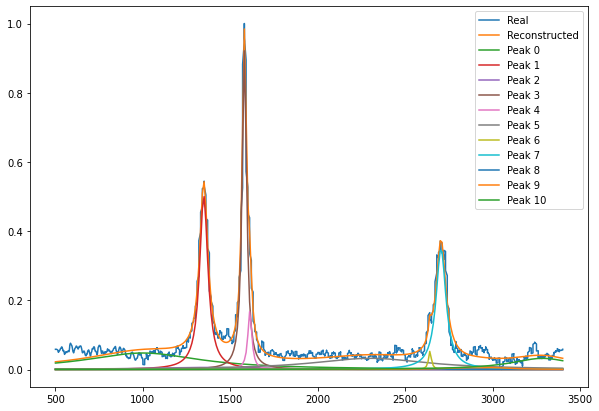

In [30]:
fit_spectrum(sample_spectrum, 11, "linear", "lorentz", "MAE", 0.000001, 1000, 15, 2)

## Up Next:
Baseline (try fitting algorithm in reading list) <br>  
Add different errors <br>  
Output error from driver <br>  
Add the option to fit with less peaks (with/without 1&3) Do this automatically. Let user choose if this happens. <br>  
